## Parameter recovery summary

We were able to simulate data, estimate parameters using BHM and MLE. No we want to make some summary plots to evaluate each method.

In [585]:
# Built-in/Generic Imports
import os,sys
import glob
import math

# Libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999

### BHM heatmaps

In [586]:
def get_mse_diff(df,v):
    col1 = '{}_agg_mse'.format(v)
    col2 = '{}_mle_mse'.format(v)
    diff = df[col2]-df[col1]
    mse = diff.values.reshape(5,5)
    return mse

In [587]:
def heatmap_difference(df,var_fixed='',idx=1,var_fixed_value=1.0,vars_plot=[],ver=''):
    [y,x] = vars_plot
    for v in vars_plot:
        fig_dir = 'simul/img/{}/mse_diff'.format(ver)
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        fig_fn = os.path.join(fig_dir,'{0}_DeltaMSE_MLE_BHM_fixed_{1}_{2:03d}.png'.format(v,var_fixed,idx))
        mse = get_mse_diff(df,v)
        index = np.round(df['{}_gt'.format(y)].unique(),2)
        ylabel = y
        if 'alpha' in y:
            ylabel = 'log ' + ylabel
            index = np.round(np.log(df['{}_gt'.format(y)].unique()),2)
        columns = np.round(df['{}_gt'.format(x)].unique(),2)
        mse_df = pd.DataFrame(mse,index=index,columns=columns)

        fig,ax = plt.subplots(figsize=(15,10))
        fmt = '.1f'
        s=sns.heatmap(mse_df,annot=True,fmt=fmt,ax=ax,vmin=-50,vmax=50,cmap='vlag',annot_kws={"fontsize":15})
        s.set(xlabel=x, ylabel=ylabel)
        ax.set_title(r'{0} $\Delta MSE: MLE-BHM$ (fixed {1}: {2:0.3f})'.format(v,var_fixed,var_fixed_value))
        fig.savefig(fig_fn)    


In [588]:
def heatmap_save_one(df,var_fixed='',idx=1,var_fixed_value=1.0,vars_plot=[],ver='',model='bhm',type='sing'):
    [y,x] = vars_plot
    for v in vars_plot:
        for err in ['mse','nmse']:
            err_col = '{}_{}_{}'.format(v,type,err)
            fig_dir = 'simul/img/{}/{}'.format(ver,err)
            if not os.path.exists(fig_dir):
                os.makedirs(fig_dir)
            fig_fn = os.path.join(fig_dir,'{0}_{1}_fixed_{2}_{3:03d}.png'.format(v,model,var_fixed,idx))
            if len(type)==0:
                err_col = '{}_{}_{}'.format(v,model,err)
            mse = df[err_col].values.reshape(5,5)
            index = np.round(df['{}_gt'.format(y)].unique(),2)
            ylabel = y
            if 'alpha' in y:
                ylabel = 'log ' + ylabel
                index = np.round(np.log(df['{}_gt'.format(y)].unique()),2)
            columns = np.round(df['{}_gt'.format(x)].unique(),2)
            mse_df = pd.DataFrame(mse,index=index,columns=columns)

            fig,ax = plt.subplots(figsize=(15,10))
            fmt = '.1f'
            s=sns.heatmap(mse_df,annot=True,fmt=fmt,ax=ax,vmin=0,vmax=100,annot_kws={"fontsize":15})
            s.set(xlabel=x, ylabel=ylabel)
            ax.set_title('{0} {1} {2} (fixed {3}: {4:0.3f})'.format(err,model.upper(),v,var_fixed,var_fixed_value))
            fig.savefig(fig_fn)


In [589]:
def get_bhm_df(ver='v002'):
    bhm_fn = os.path.join('simul/parameter_estimate_bhm_{}.csv'.format(ver))
    bhm_df = pd.read_csv(bhm_fn,index_col=0)

    for v in ['alpha','beta','gamma']:
        for type in ['agg']:
            bhm_df['{}_{}_mse'.format(v,type)] = (bhm_df['{}_bhm_{}'.format(v,type)]-bhm_df['{}_gt'.format(v)])**2
            # bhm_df['{}_{}_nmse'.format(v,type)] = 100*(bhm_df['{}_bhm_{}'.format(v,type)]-bhm_df['{}_gt'.format(v)])**2 / (bhm_df['{}_bhm_{}'.format(v,type)])**2
            bhm_df['{}_{}_nmse'.format(v,type)] = 100*(bhm_df['{}_bhm_{}'.format(v,type)]-bhm_df['{}_gt'.format(v)])**2 / (bhm_df['{}_gt'.format(v)])**2
    return bhm_df


In [590]:
def get_mle_df(bhm_df,ver='v002'):
    mle_fn = os.path.join('simul/utility/split_CRDM_analysis_{}.csv'.format(ver))
    df = pd.read_csv(mle_fn,index_col=0)
    mle_df = bhm_df[['alpha_gt','beta_gt','gamma_gt']].copy()
    mle_df['alpha_mle'] = df['alpha']
    mle_df['beta_mle'] = df['beta']
    mle_df['gamma_mle'] = df['gamma']
    # return mle_df
    for v in ['alpha','beta','gamma']:
        mle_df['{}_mle_mse'.format(v)] = (mle_df['{}_mle'.format(v)]-mle_df['{}_gt'.format(v)])**2
        # mle_df['{}_mle_nmse'.format(v)] = 100*(mle_df['{}_mle'.format(v)]-mle_df['{}_gt'.format(v)])**2 / (mle_df['{}_mle'.format(v)])**2
        mle_df['{}_mle_nmse'.format(v)] = 100*(mle_df['{}_mle'.format(v)]-mle_df['{}_gt'.format(v)])**2 / (mle_df['{}_gt'.format(v)])**2
    return mle_df

In [591]:
def scatter_one(df,ver='',v='',err='',x='sing',y='agg'):
    ycol = '{}_{}_{}'.format(v,y,err)
    xcol = '{}_{}_{}'.format(v,x,err)
    fig,ax = plt.subplots(figsize=(6,4))
    s=sns.scatterplot(data=df,x=xcol,y=ycol,ax=ax)
    s.set(xlabel=x, ylabel=y)
    min_val = np.min([np.min(df[ycol]),np.min(df[xcol])])
    max_val = np.max([np.max(df[ycol]),np.max(df[xcol])])
    plt.plot([min_val, max_val],[min_val, max_val],'k-')
    title = '{} {}:{} versus {}'.format(v,err,y,x)
    ax.set_title(title)
    fig_dir = 'simul/img/{}/vs/'.format(ver)
    if err == 'mse':
        fig_dir = os.path.join(fig_dir,err)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)    
    fig_fn = os.path.join(fig_dir,'{}_{}_{}_vs_{}.png'.format(v,err,y,x))
    fig.savefig(fig_fn)

def scatter_two(df,ver='',vars=['kappa','gamma'],err='',mod='agg'):
    ycol = '{}_{}_{}'.format(vars[0],mod,err)
    xcol = '{}_{}_{}'.format(vars[1],mod,err)
    fig,ax = plt.subplots(figsize=(6,4))
    s=sns.scatterplot(data=df,x=xcol,y=ycol,ax=ax)
    s.set(xlabel=vars[1], ylabel=vars[0])
    min_val = np.min([np.min(df[ycol]),np.min(df[xcol])])
    max_val = np.max([np.max(df[ycol]),np.max(df[xcol])])
    plt.plot([min_val, max_val],[min_val, max_val],'k-')
    title = '{} {}:{} versus {}'.format(mod,err,vars[0],vars[1])
    ax.set_title(title)
    fig_dir = 'simul/img/{}/vs/'.format(ver)
    if err == 'mse':
        fig_dir = os.path.join(fig_dir,err)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)    
    fig_fn = os.path.join(fig_dir,'{}_{}_{}_vs_{}.png'.format(mod,err,vars[0],vars[1]))
    fig.savefig(fig_fn)

def scatter_mse(df,ver='v002'):
    print(list(df))
    for err in ['mse','nmse']:
        vars = ['alpha','beta','gamma']
        scatter_two(df,ver=ver,vars=vars[:-1],err=err,mod='agg')
        scatter_two(df,ver=ver,vars=vars[1:],err=err,mod='agg')
        scatter_two(df,ver=ver,vars=[vars[0],vars[2]],err=err,mod='agg')
        # scatter_two(df,ver=ver,vars=vars,err=err,mod='sing')
        for v in vars:
            # agg versus sing
            # scatter_one(df,ver=ver,v=v,err=err,x='sing',y='agg')
            # agg versus MLE
            scatter_one(df,ver=ver,v=v,err=err,x='mle',y='agg')
            # sing versus MLE
            # scatter_one(df,ver=ver,v=v,err=err,x='mle',y='sing')


In [592]:
def scatter_plot(df,ver='',model='bhm',type='sing'):
    for v in ['alpha','beta','gamma']:
        gt_col = '{}_gt'.format(v)
        model_col = '{}_{}_{}'.format(v,model,type)
        ylabel = '{} {} {}'.format(v,model,type)
        xlabel = '{} ground truth'.format(v)
        title = '{} {} {}'.format(model.upper(),type,v)
        fig_dir = 'simul/img/{}/scatter/'.format(ver)
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)         
        fig_fn = os.path.join(fig_dir,'{}_{}_{}.png'.format(v,model,type))
        if len(type)==0:
            model_col = '{}_{}'.format(v,model)
            ylabel = '{} {}'.format(model,v)
            title = '{} {}'.format(model.upper(),v)
            fig_fn = os.path.join(fig_dir,'{}_{}.png'.format(v,model))

        fig,ax = plt.subplots(figsize=(8,6))
        s=sns.scatterplot(data=df,x=gt_col,y=model_col,ax=ax)

        min_val = np.min([np.min(df[model_col]),np.min(df[gt_col])])
        max_val = np.max([np.max(df[model_col]),np.max(df[gt_col])])
        plt.plot([min_val, max_val],[min_val, max_val],'k-')
        
        if 'alpha' in v:
            plt.xscale('log')
            plt.yscale('log')
            xlabel = 'log {}'.format(xlabel)
            ylabel = 'log {}'.format(ylabel)
        s.set(xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title)
        fig.savefig(fig_fn)


In [593]:
def get_sample(df,v='alpha'):
    # not taking log here, will take it later
    col = np.unique(df['{}_gt'.format(v)])
    samples = col[1:-1]
    # print(v,samples)
    return samples

In [594]:

def heatmap_save_vars(df,ver='',model='bhm',type='agg',plot_diff=False):
    # heatmap_save(bhm_df,ver=ver,model='bhm',type='sing')
    vars = ['alpha','beta','gamma']
    for var_fixed in vars:
        var_samples = get_sample(df,v=var_fixed)
        for idx,var_fixed_value in enumerate(var_samples):
            var_fixed_df = df.loc[df['{}_gt'.format(var_fixed)]==var_fixed_value]
            vars_plot = [var for var in vars if var != var_fixed]
            if plot_diff:
                heatmap_difference(var_fixed_df,var_fixed=var_fixed,idx=idx,var_fixed_value=var_fixed_value,vars_plot=vars_plot,ver=ver)
            else:
                heatmap_save_one(var_fixed_df,var_fixed=var_fixed,idx=idx,var_fixed_value=var_fixed_value,vars_plot=vars_plot,ver=ver,model=model,type=type)




In [595]:
ver='v002'
bhm_df = get_bhm_df(ver=ver)
mle_df = get_mle_df(bhm_df,ver=ver)
df = pd.concat([bhm_df,mle_df],axis=1)
# drop duplicate columns if there are any
df = df.loc[:,~df.columns.duplicated()].copy()

# display(list(df))



['alpha_gt', 'beta_gt', 'gamma_gt', 'alpha_bhm_agg', 'beta_bhm_agg', 'gamma_bhm_agg', 'alpha_agg_mse', 'alpha_agg_nmse', 'beta_agg_mse', 'beta_agg_nmse', 'gamma_agg_mse', 'gamma_agg_nmse', 'alpha_mle', 'beta_mle', 'gamma_mle', 'alpha_mle_mse', 'alpha_mle_nmse', 'beta_mle_mse', 'beta_mle_nmse', 'gamma_mle_mse', 'gamma_mle_nmse']


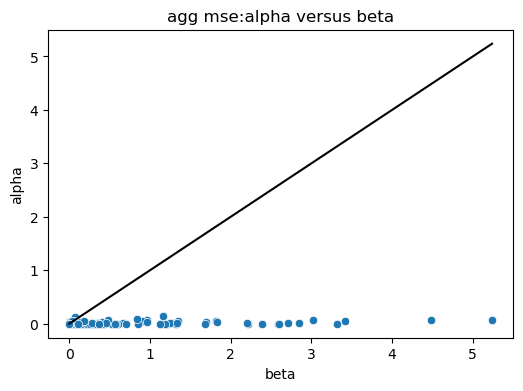

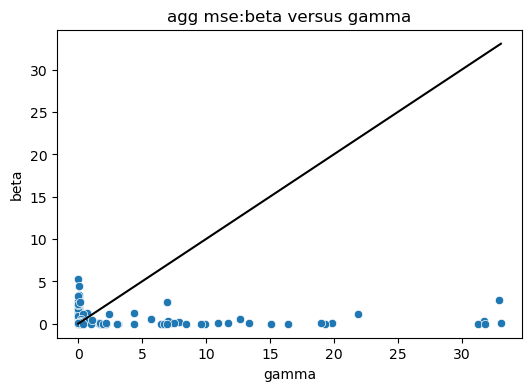

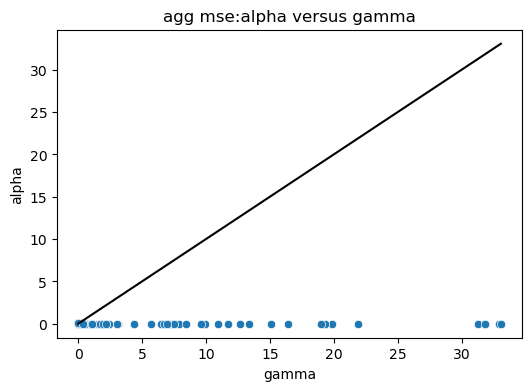

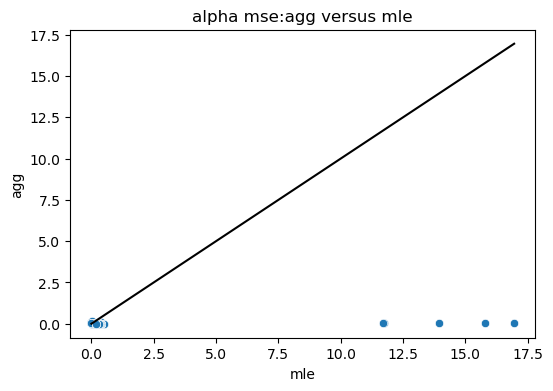

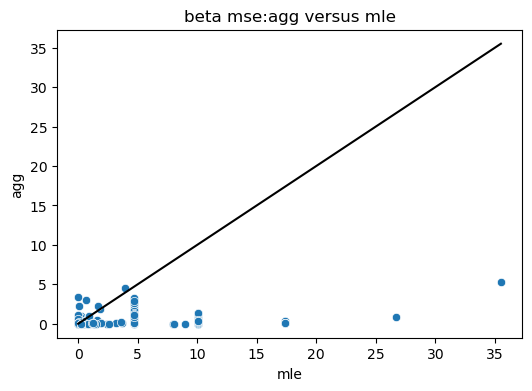

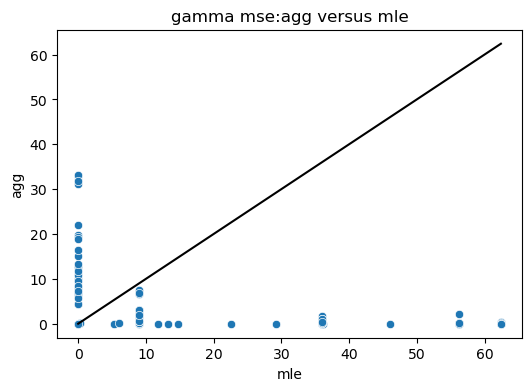

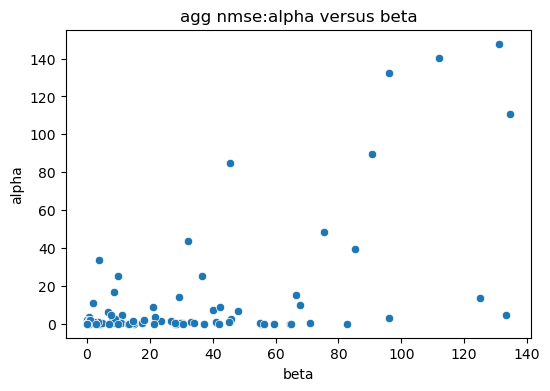

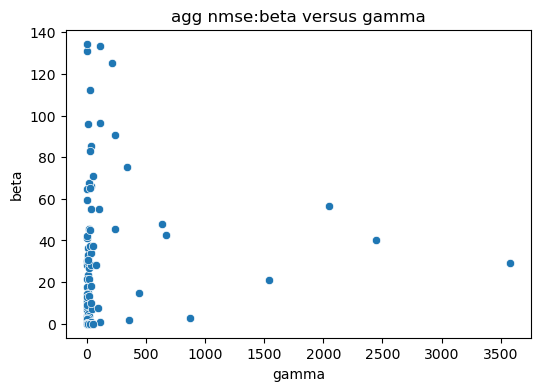

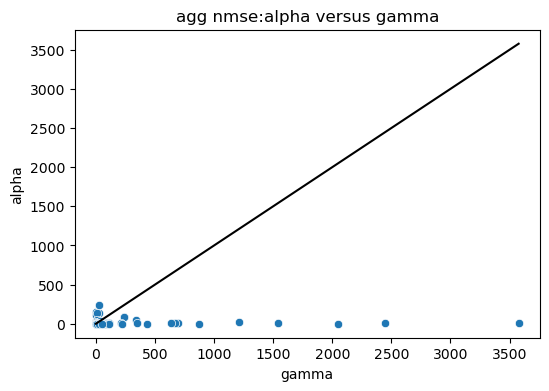

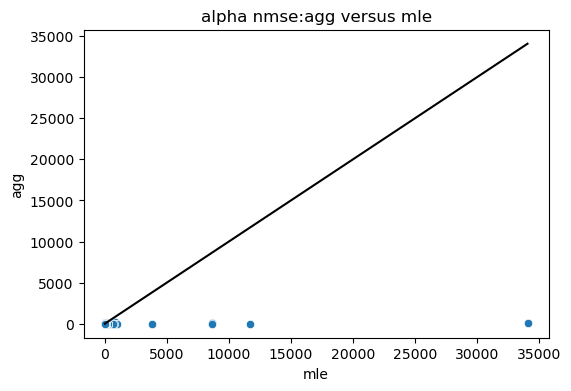

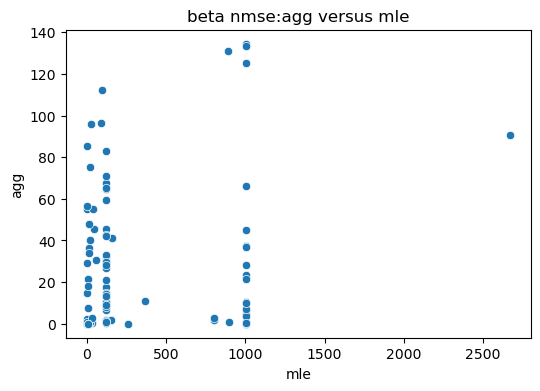

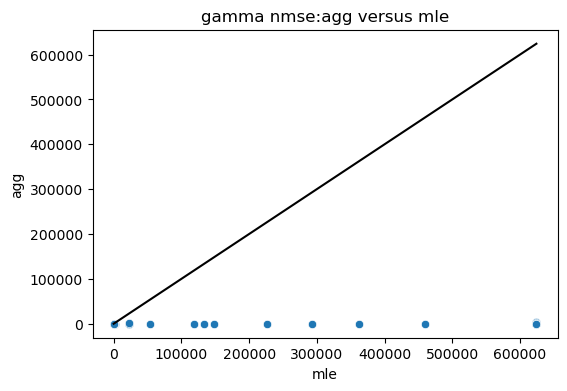

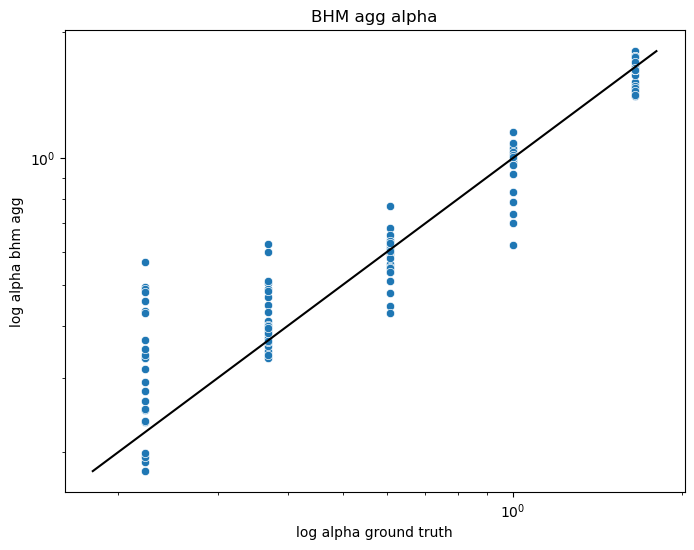

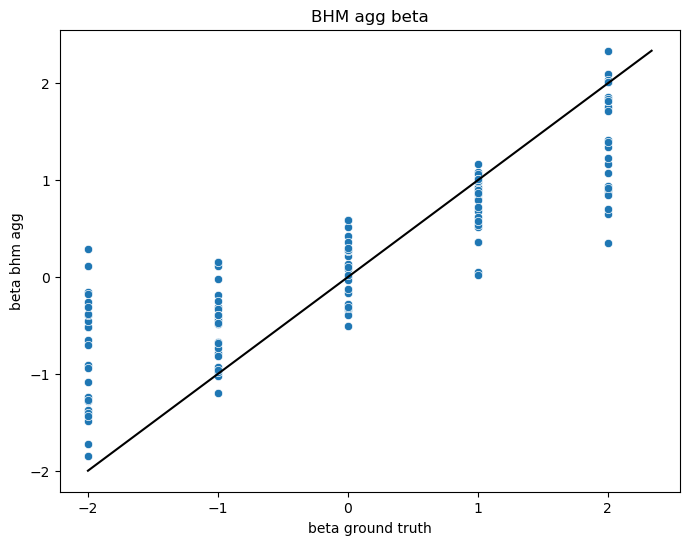

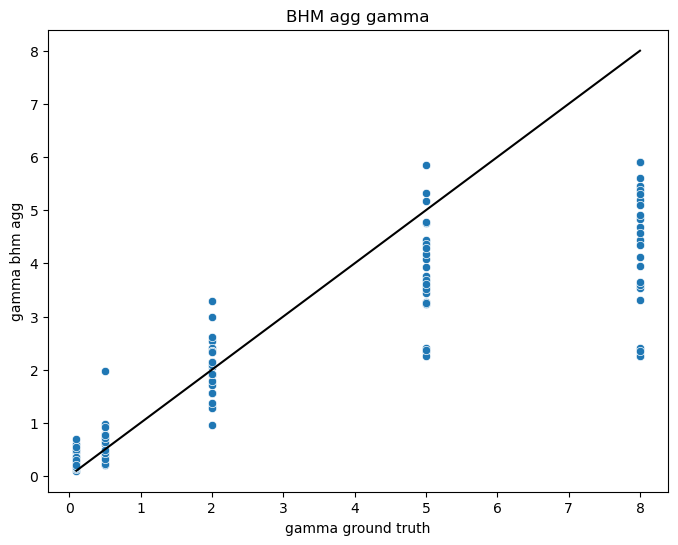

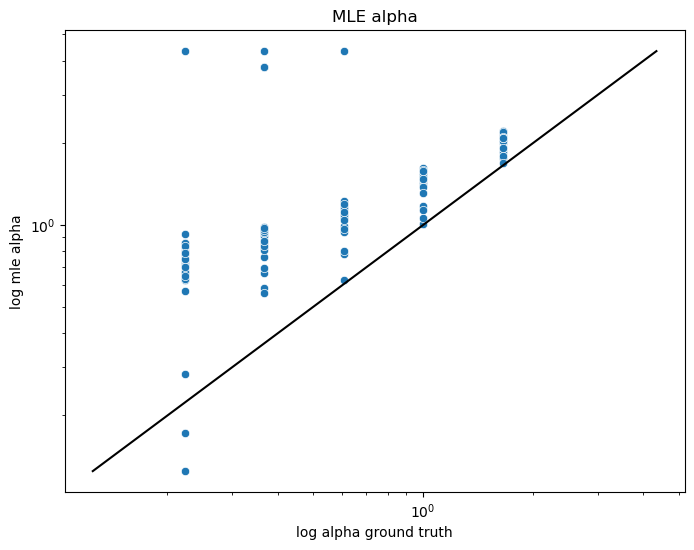

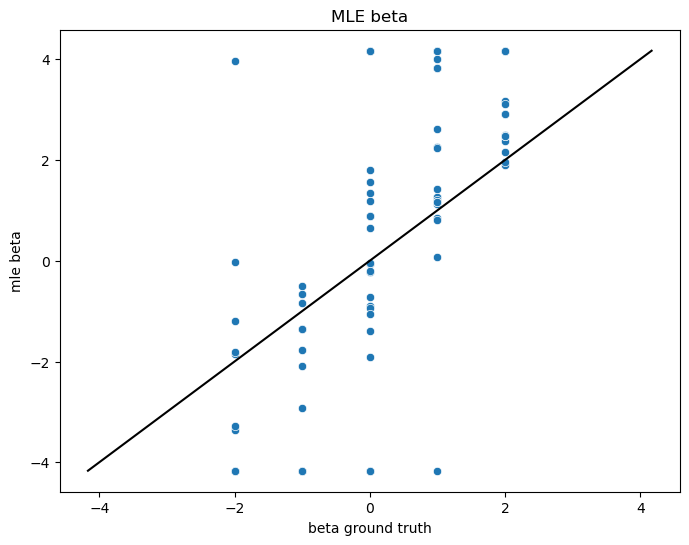

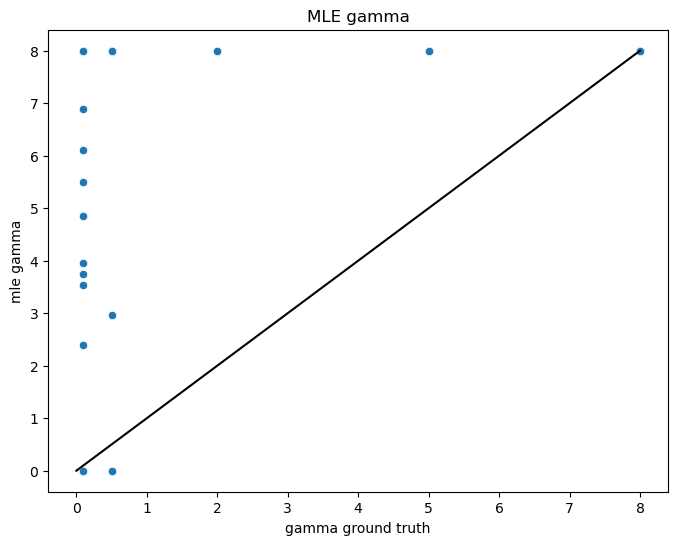

In [596]:
scatter_mse(df,ver=ver)

# scatter_plot(bhm_df,ver=ver,model='bhm',type='sing')
scatter_plot(df,ver=ver,model='bhm',type='agg')
scatter_plot(df,ver=ver,model='mle',type='')



/var/folders/ts/wpzrly5j2yxb42zf5v0w5rvh0000gs/T/ipykernel_44734/1749408261.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(15,10))


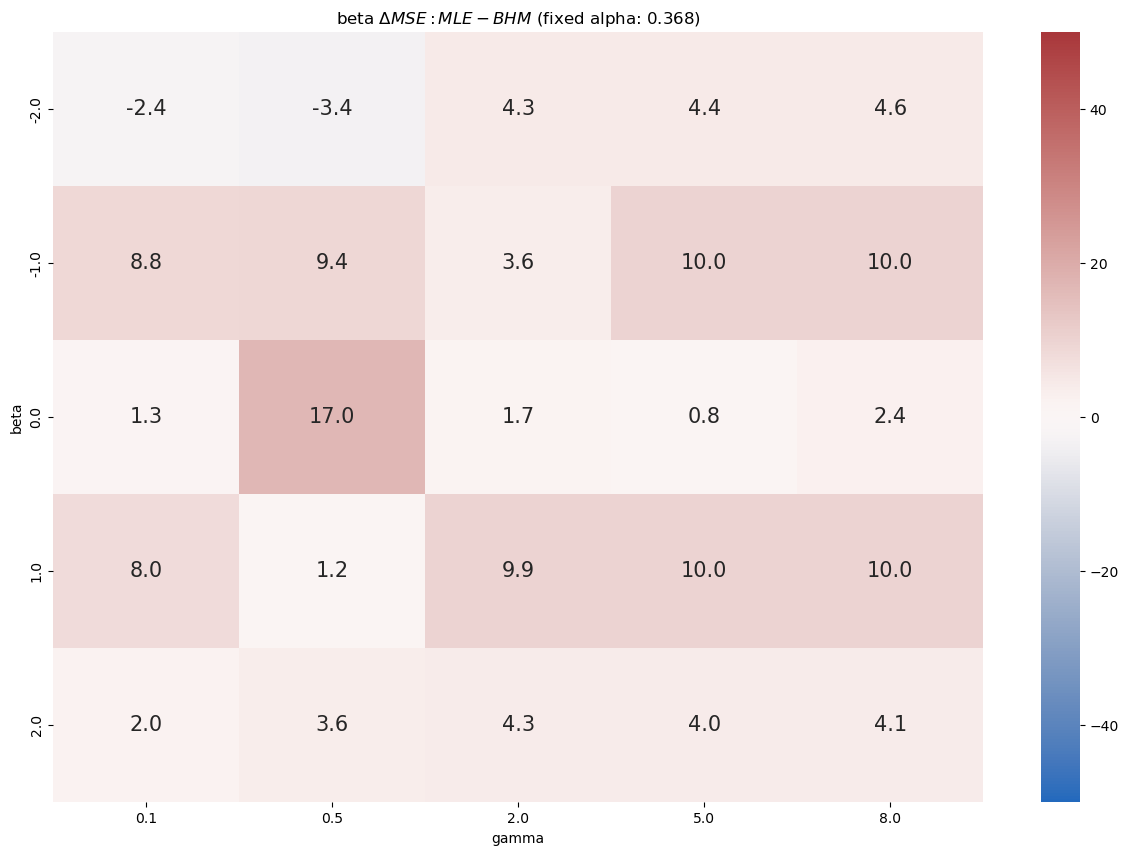

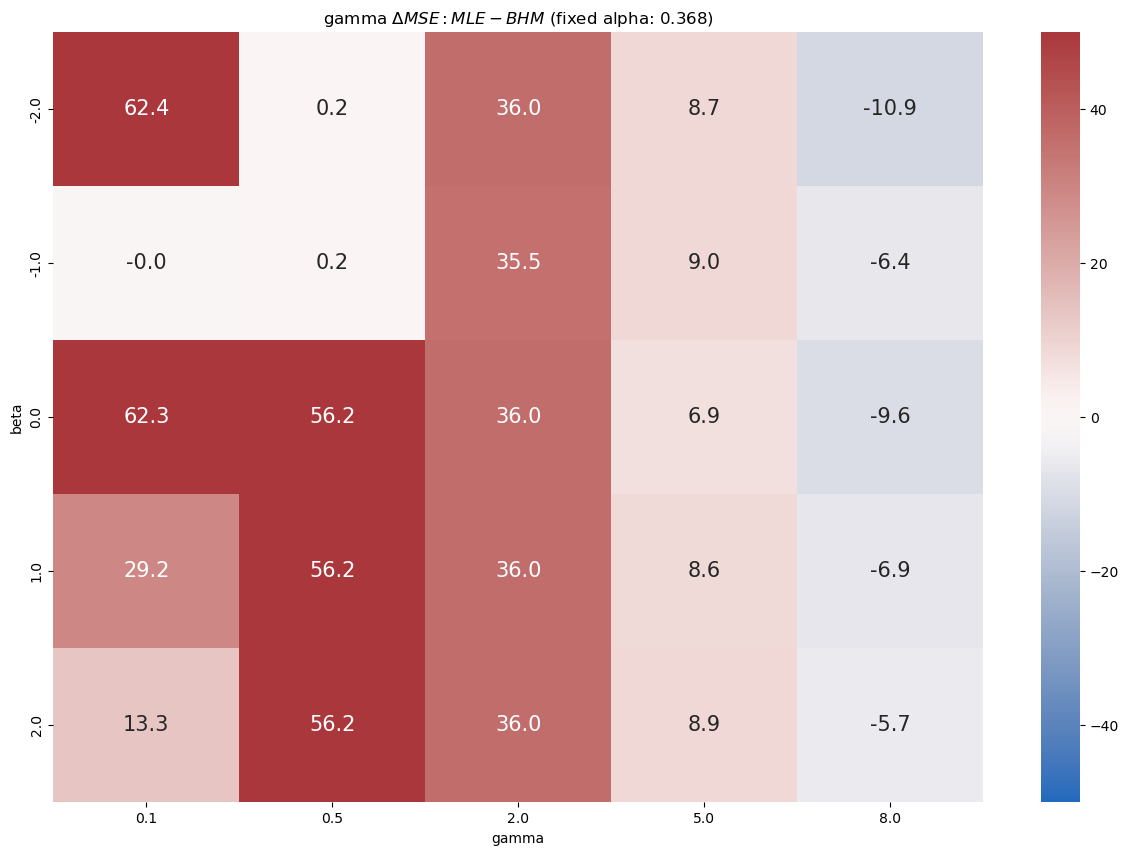

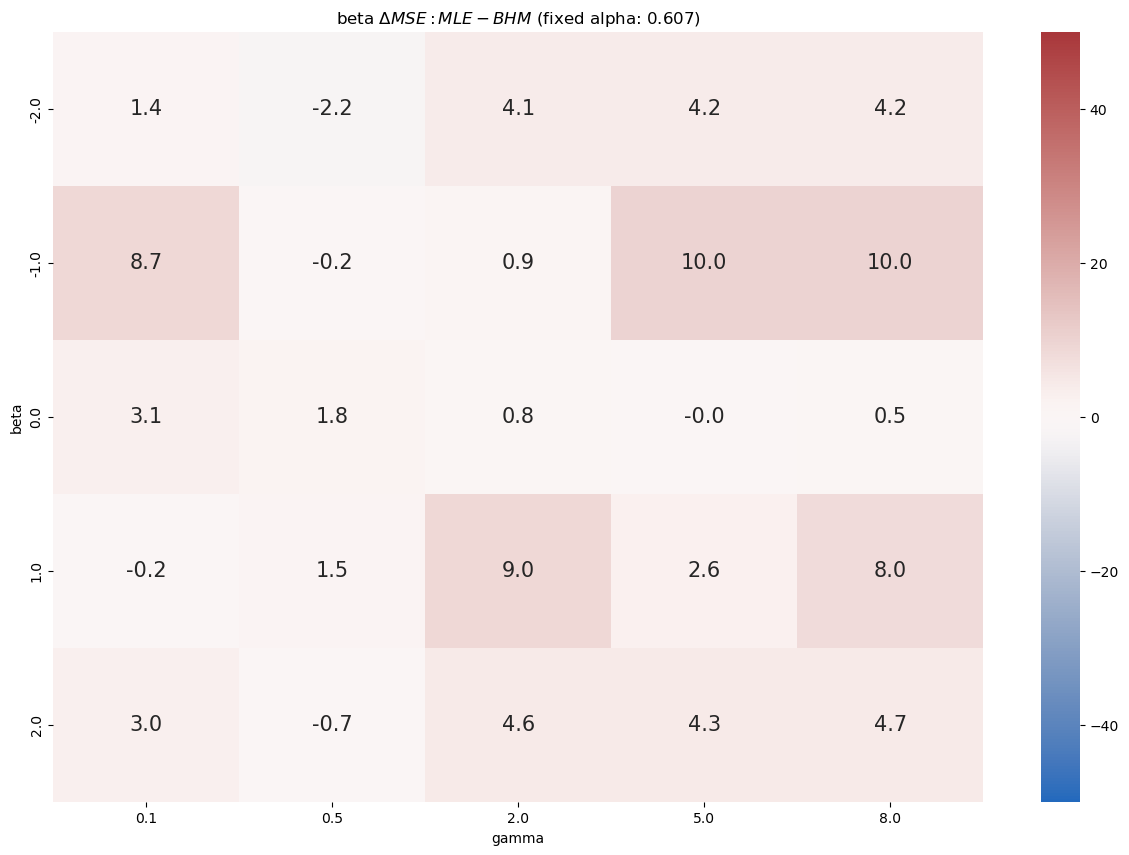

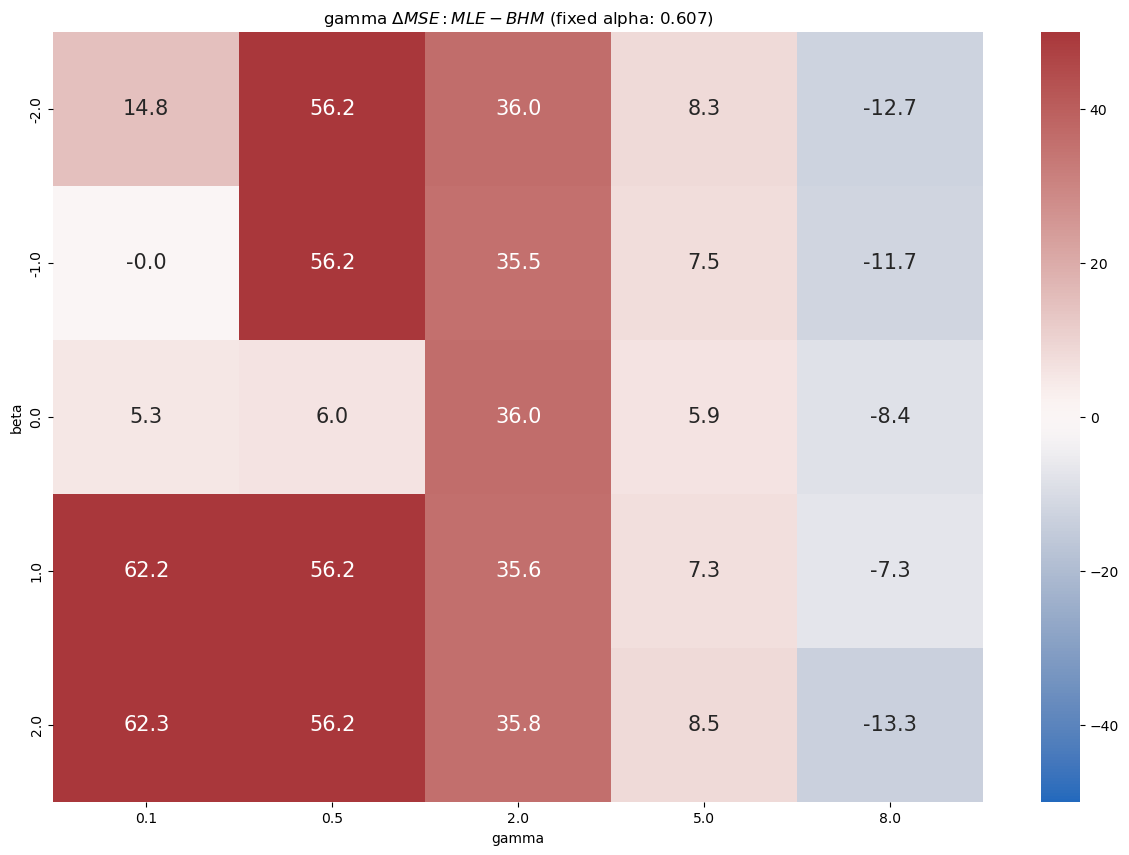

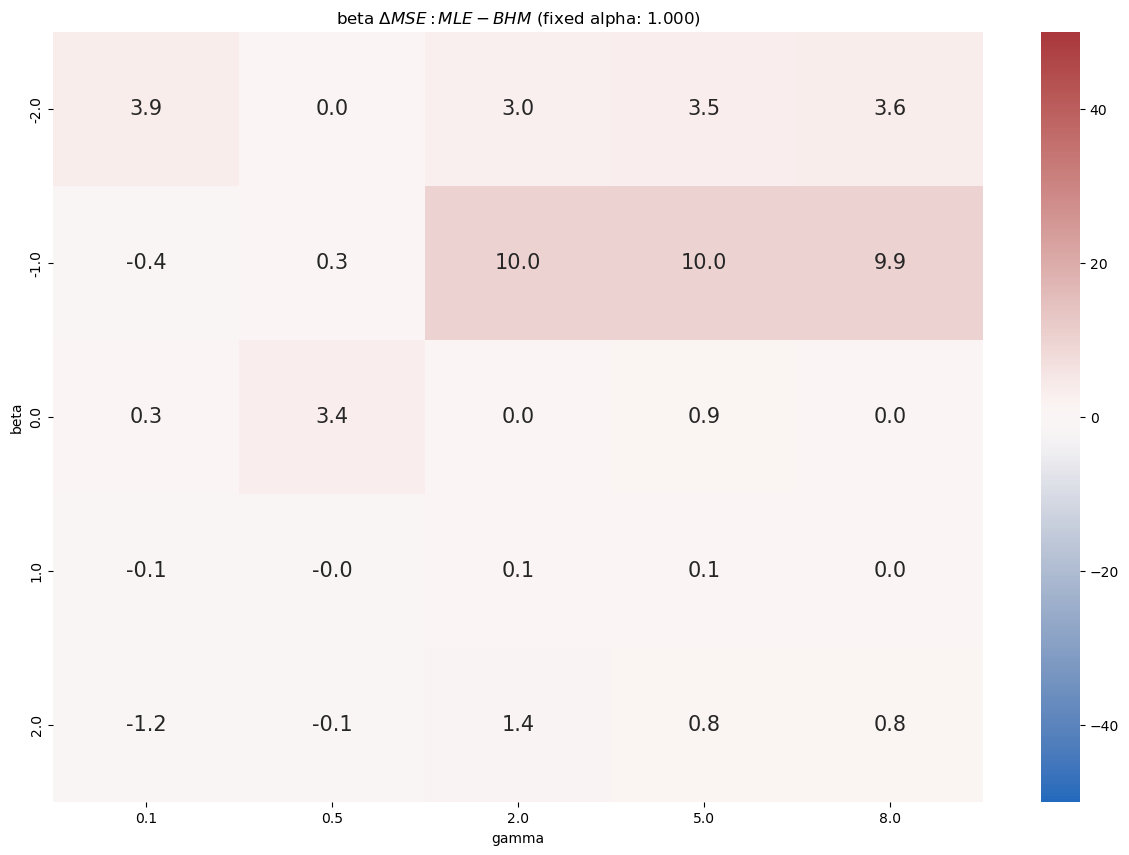

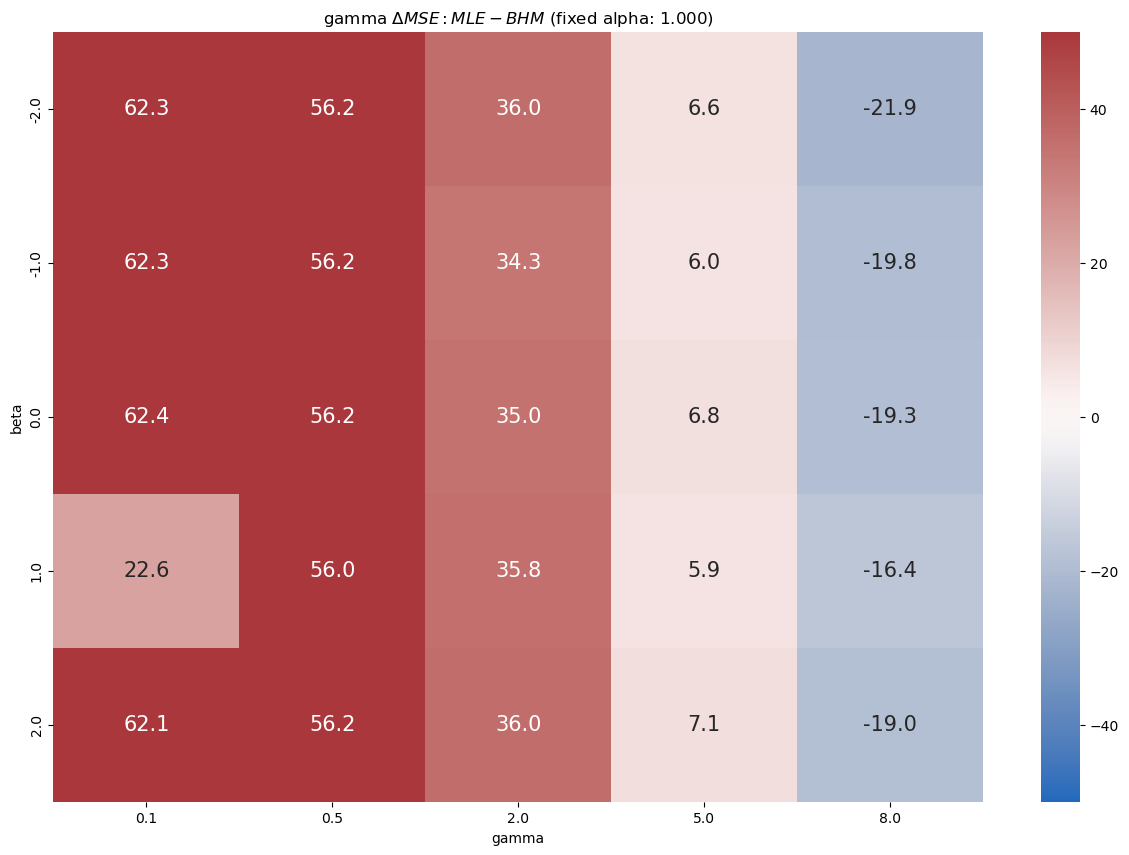

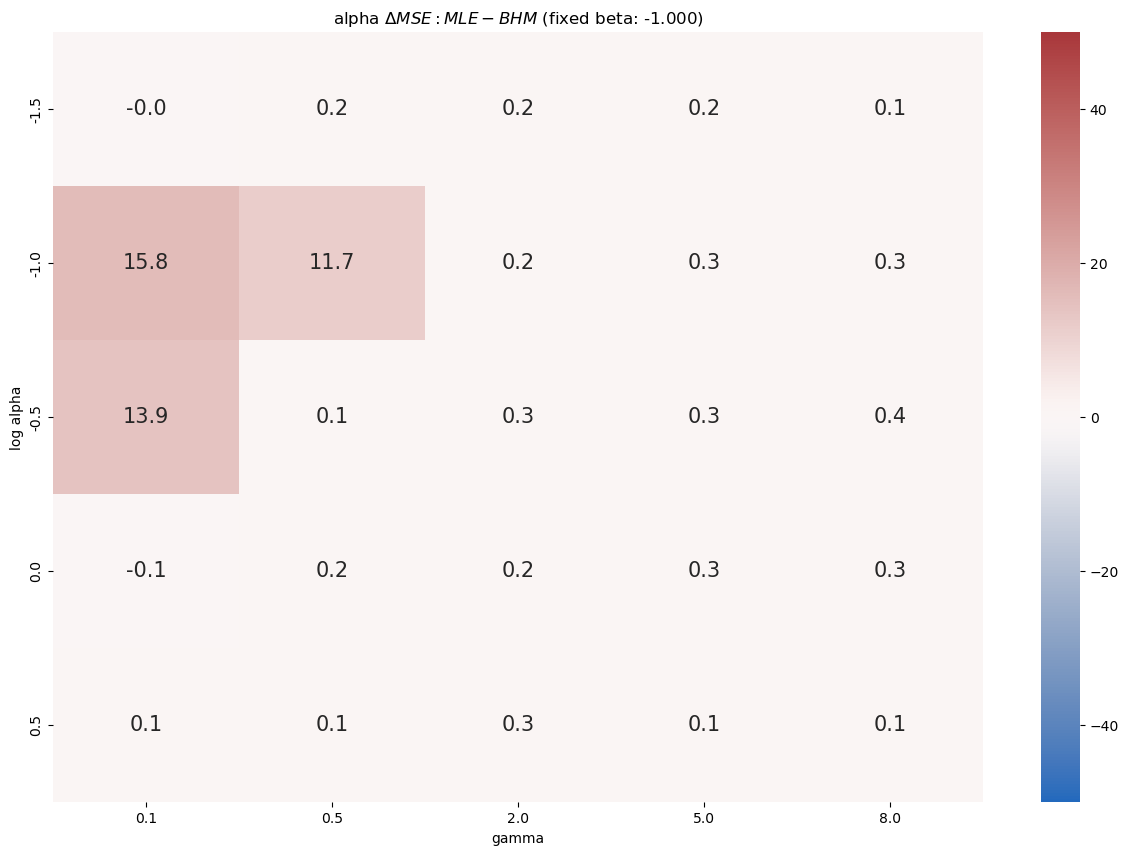

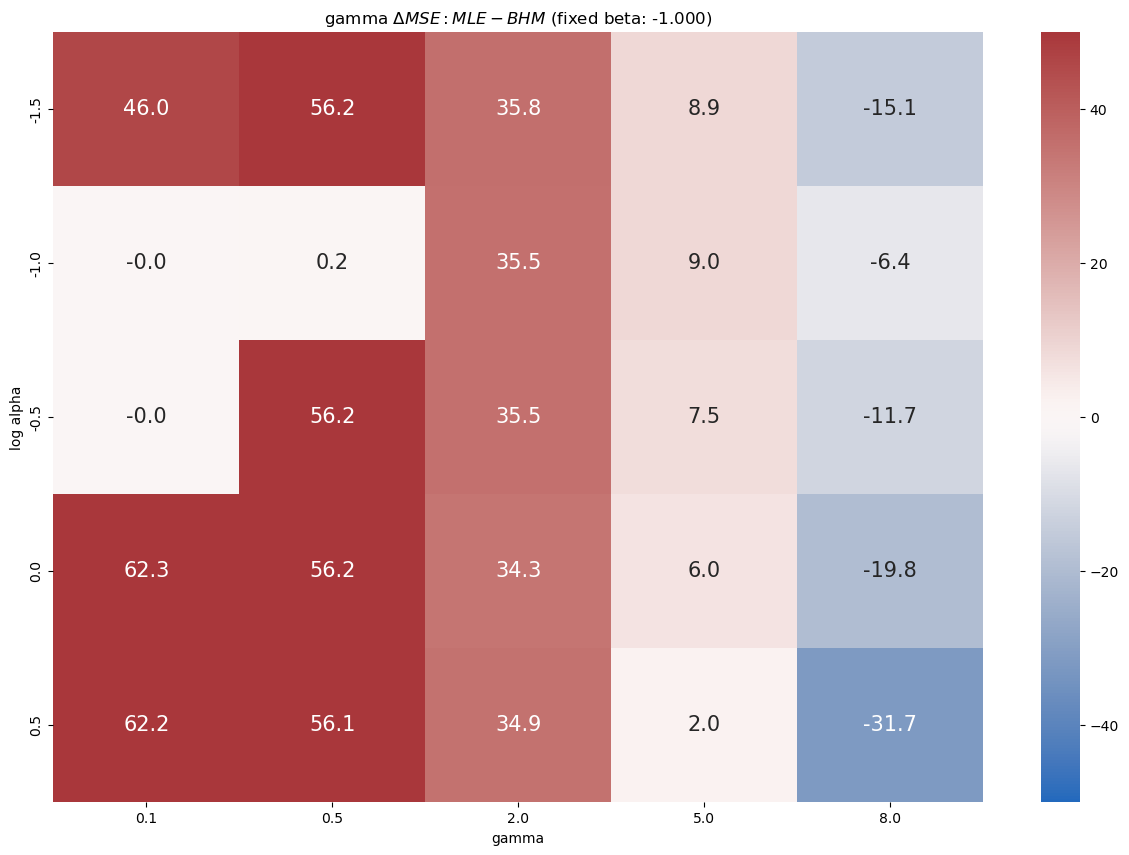

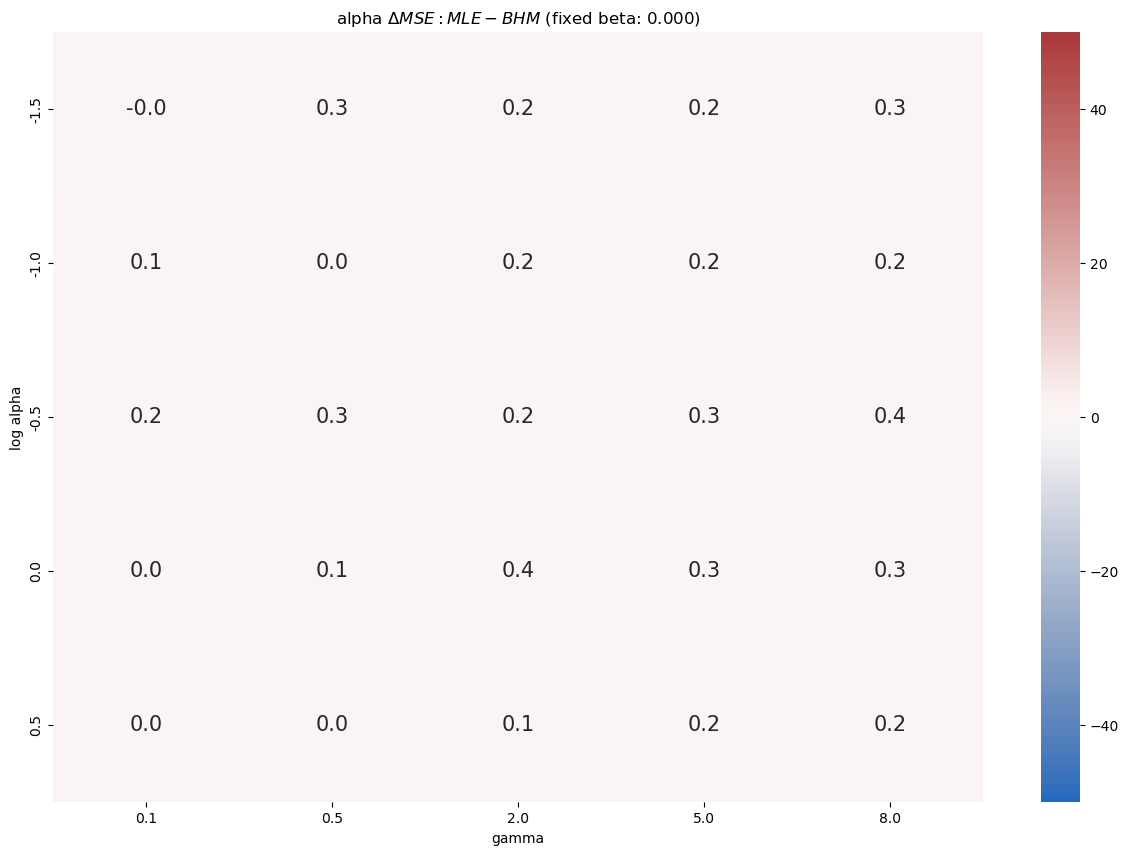

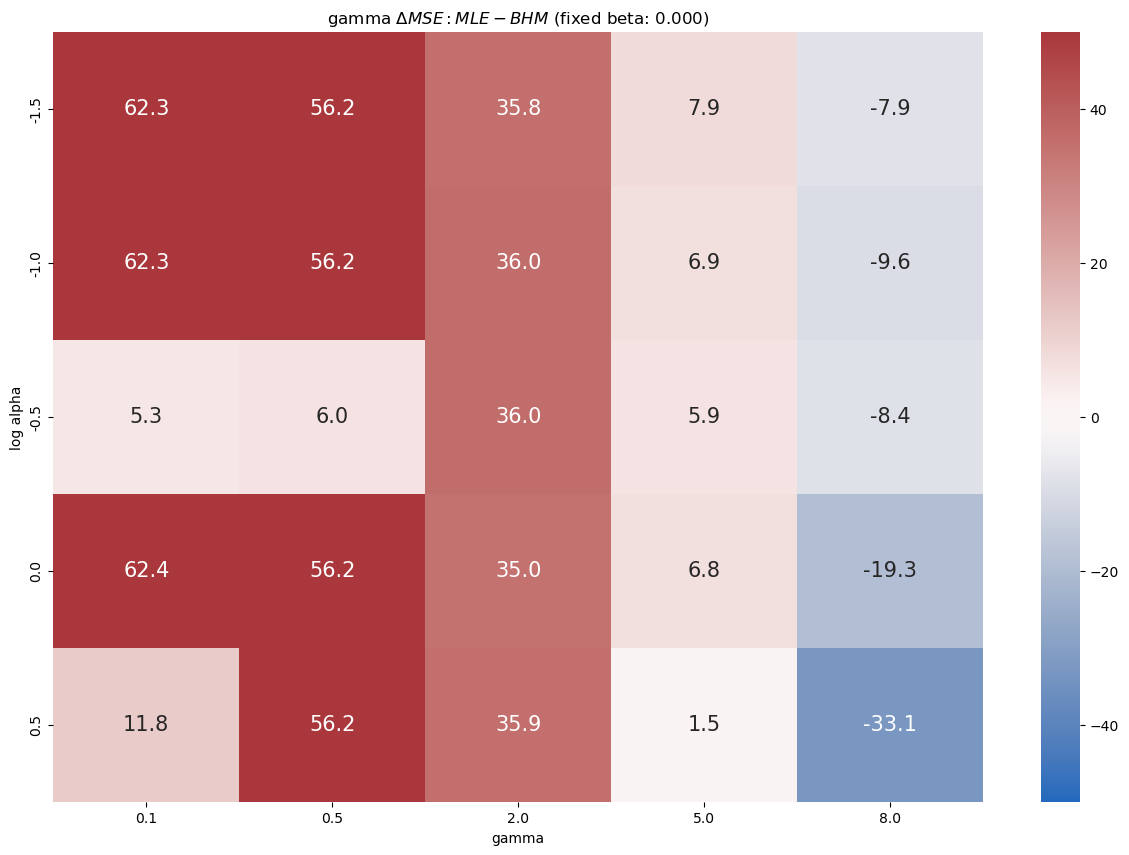

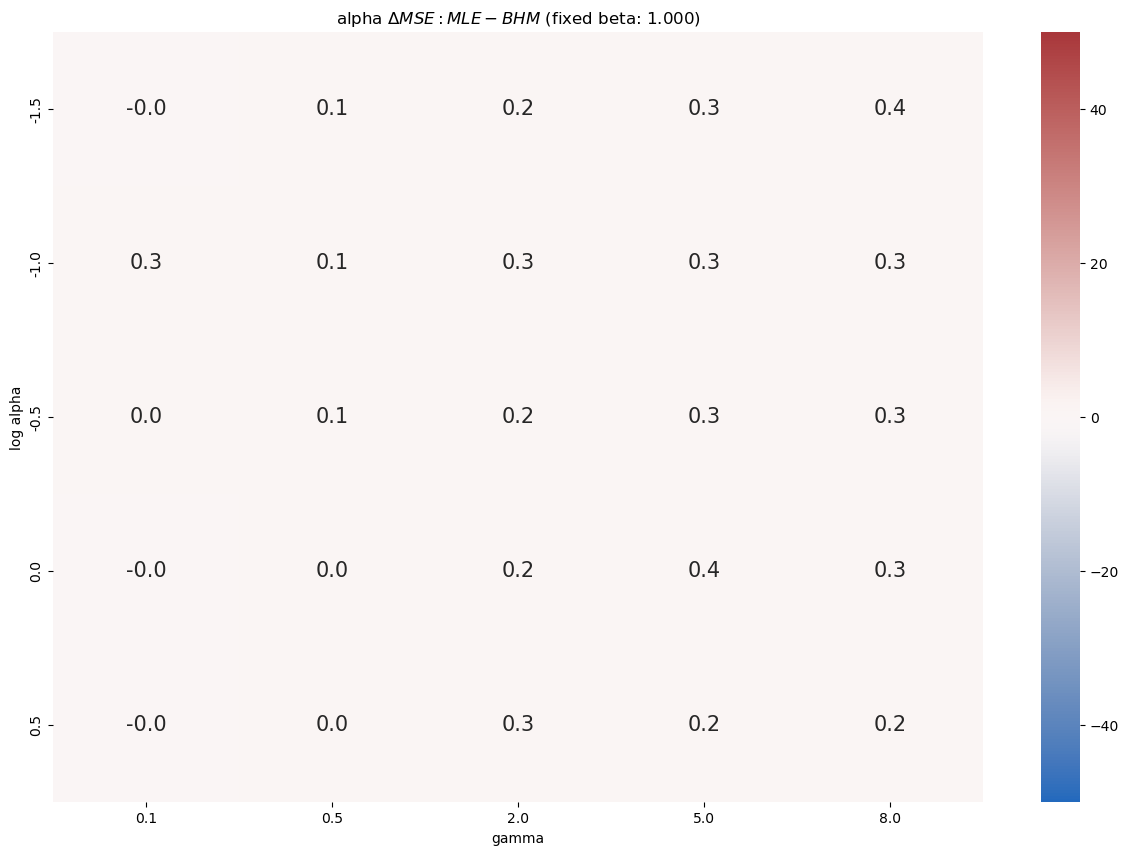

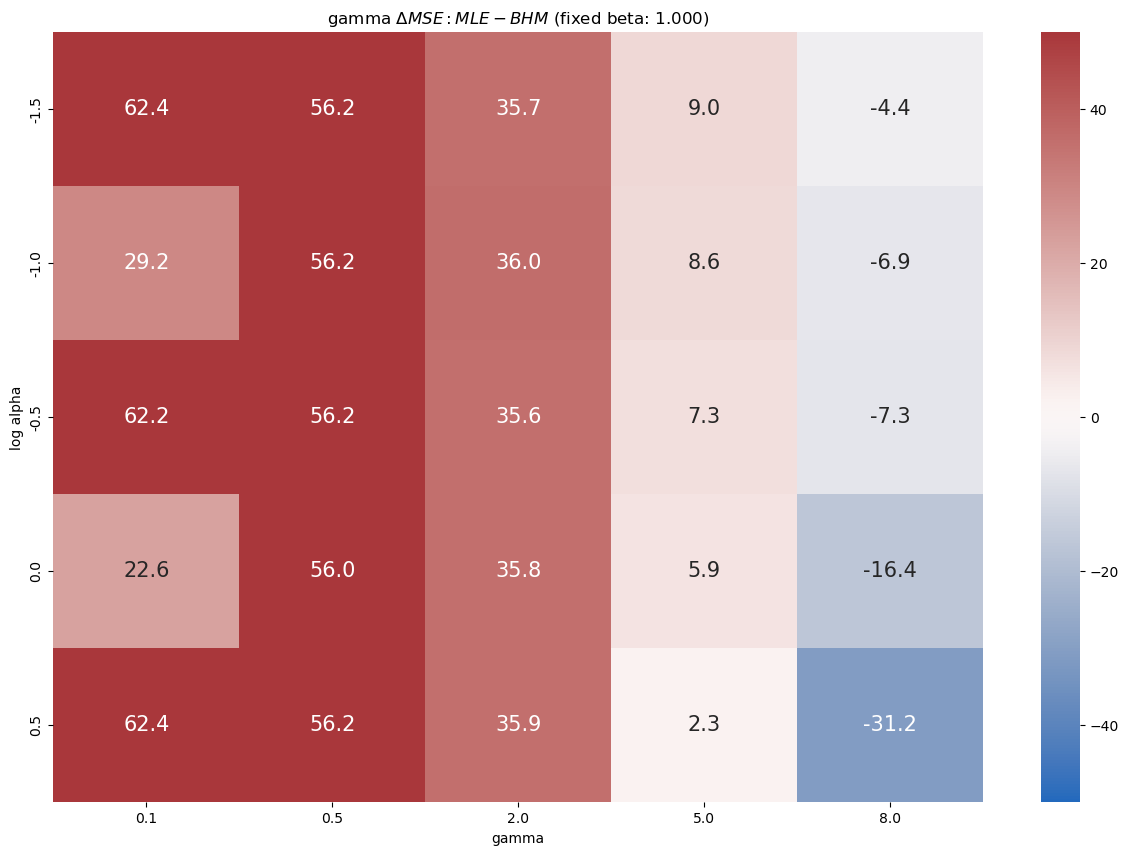

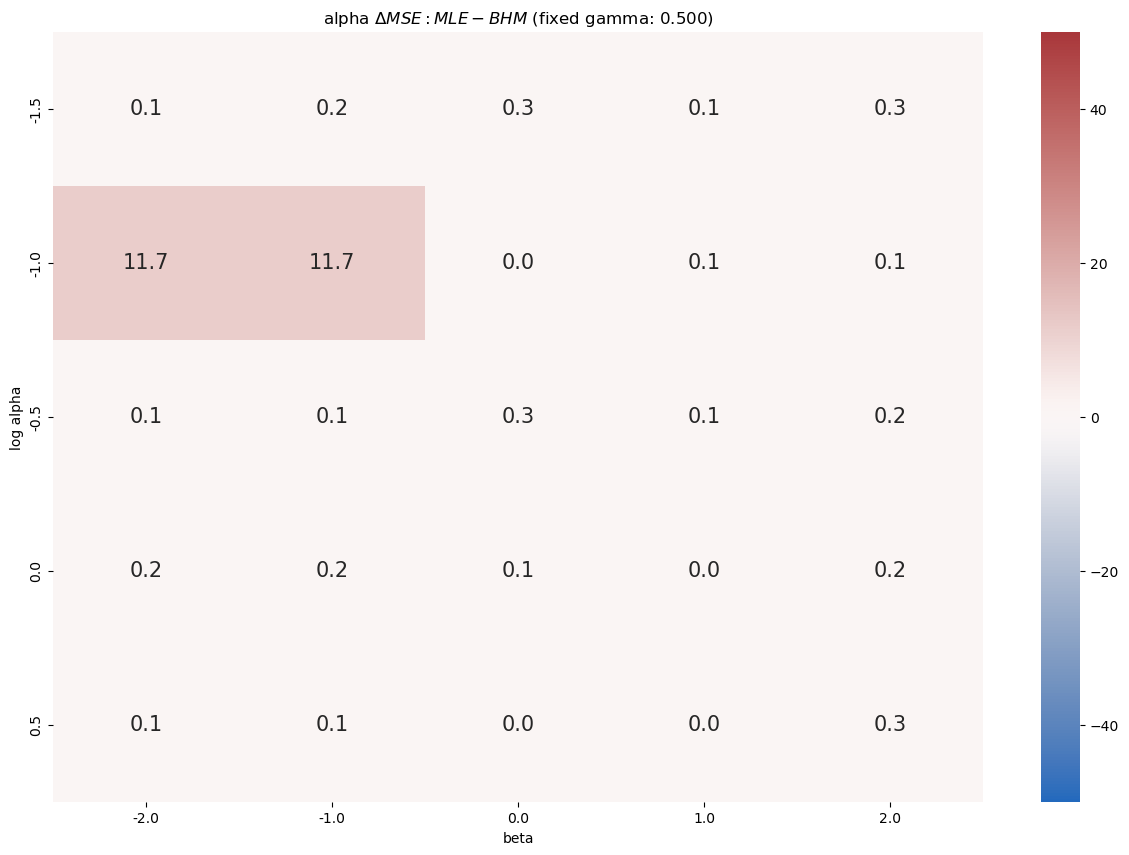

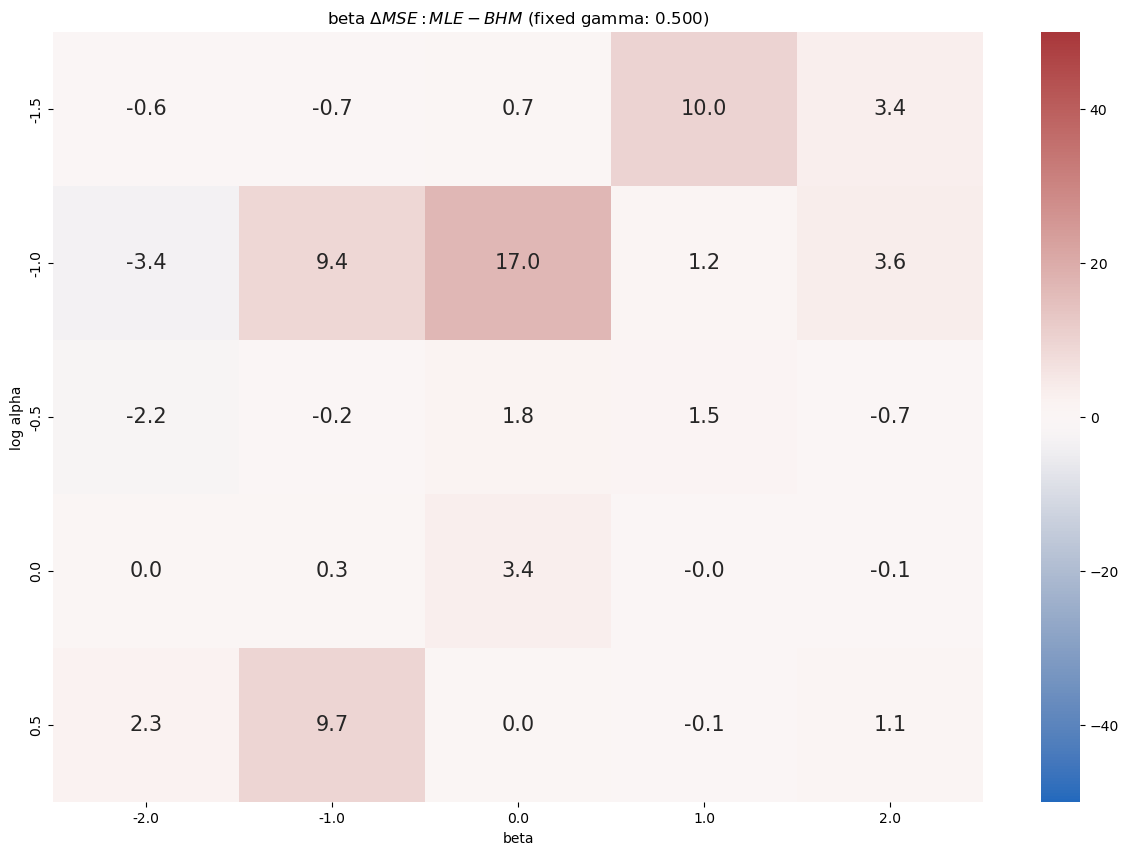

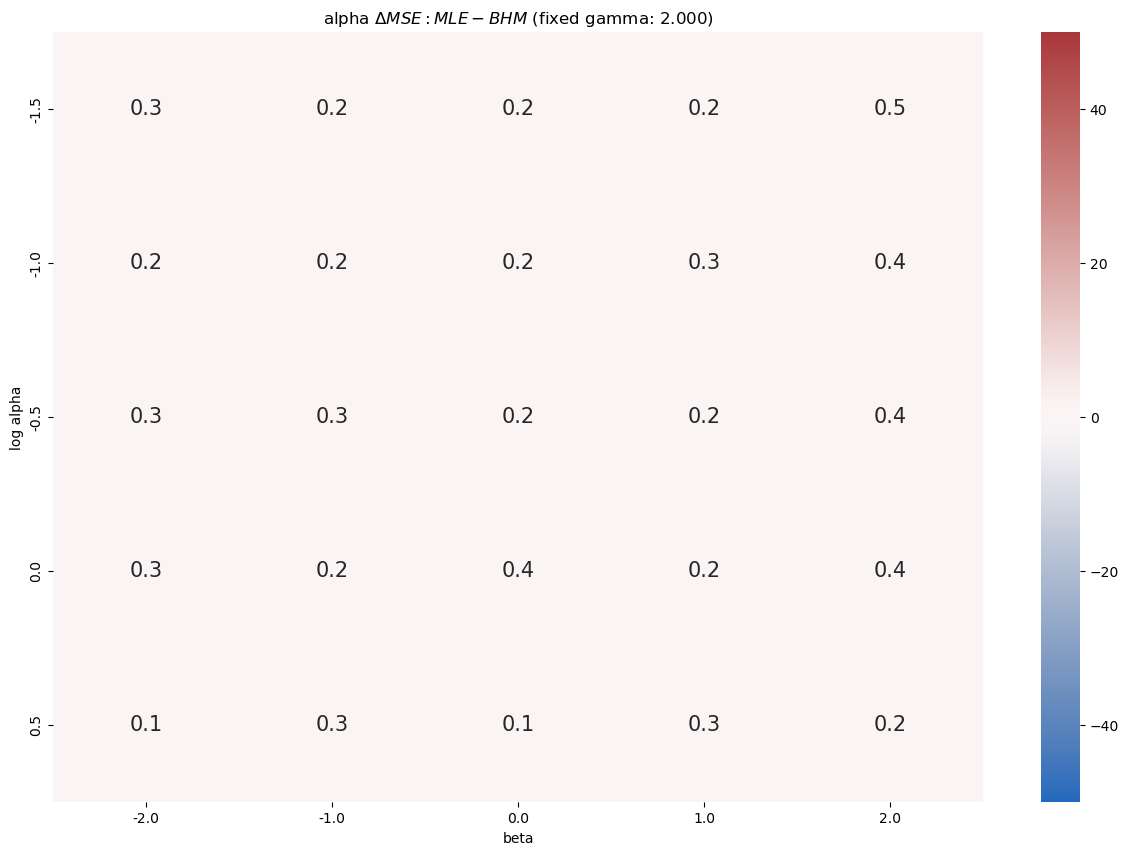

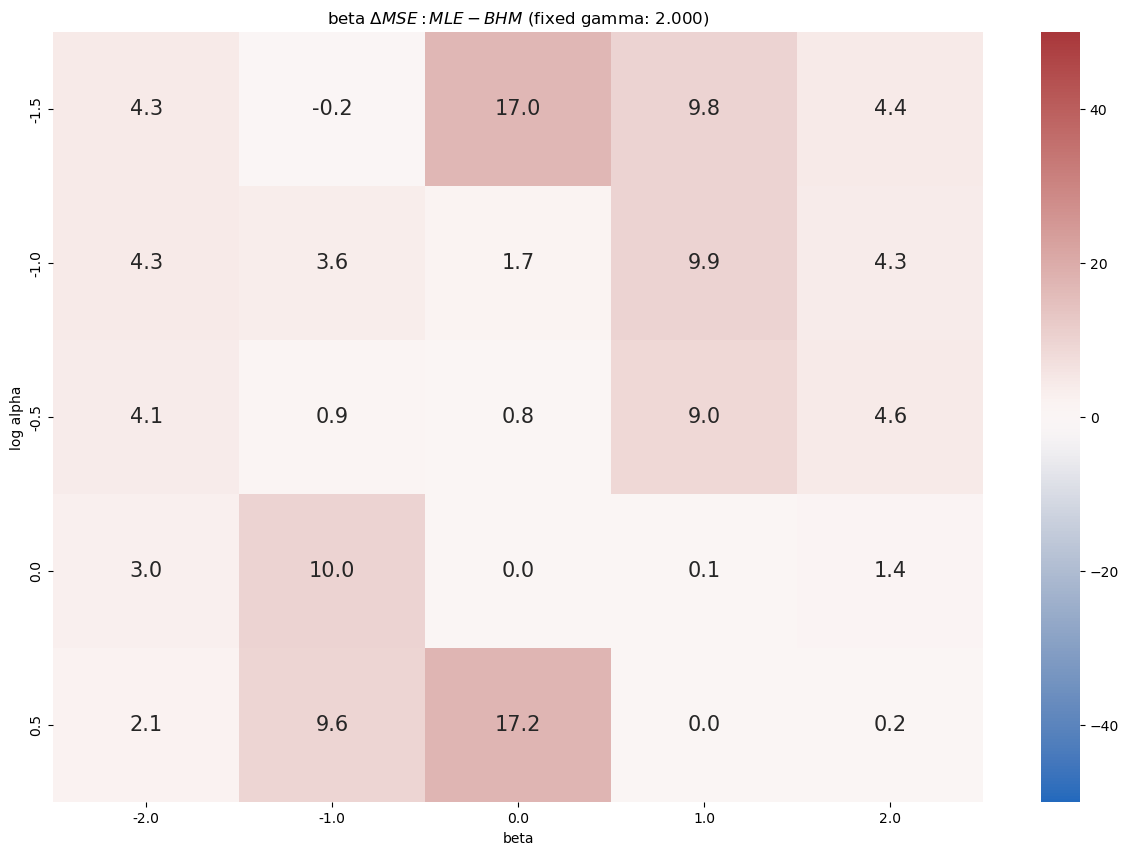

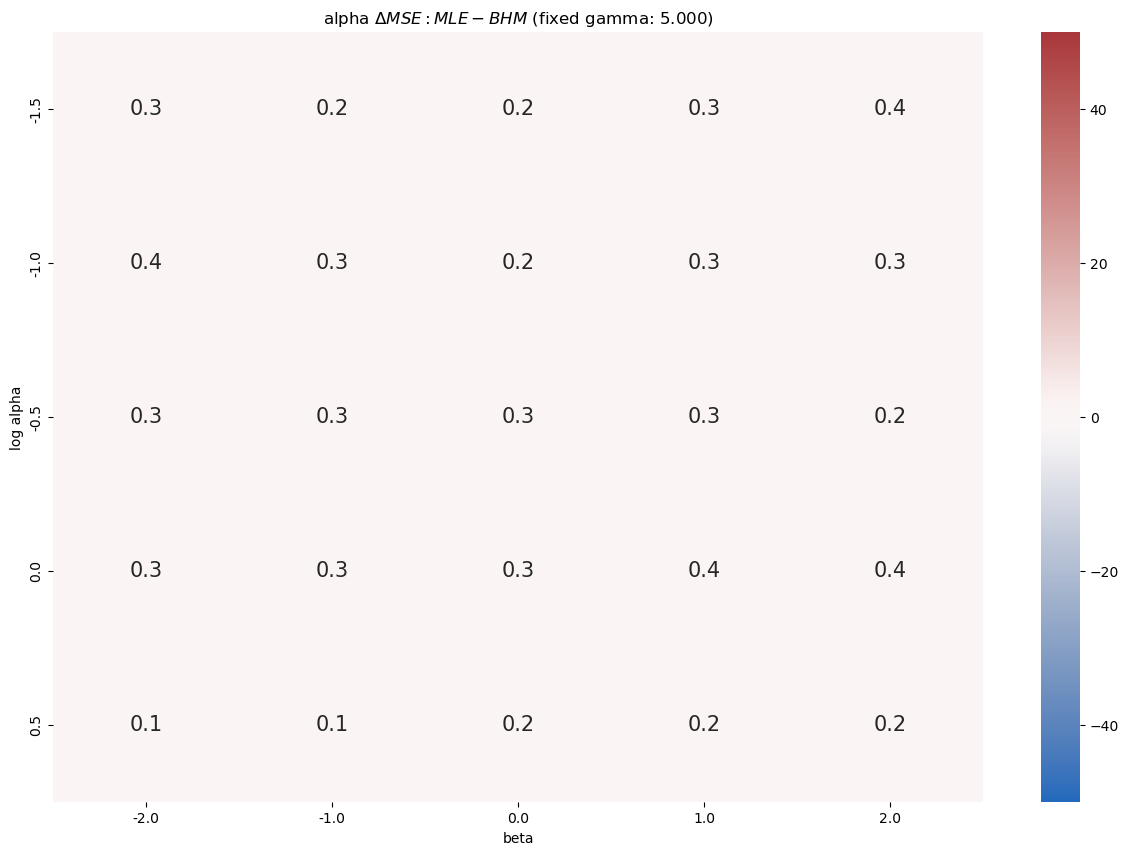

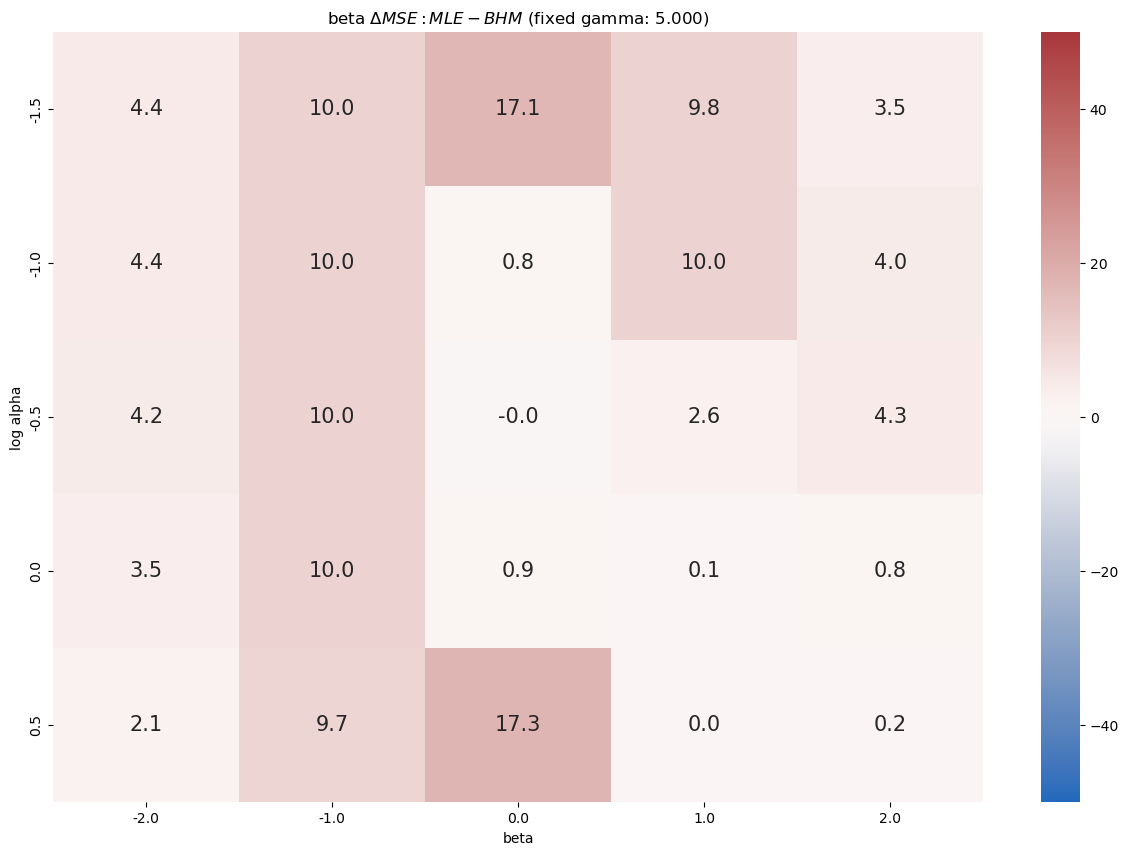

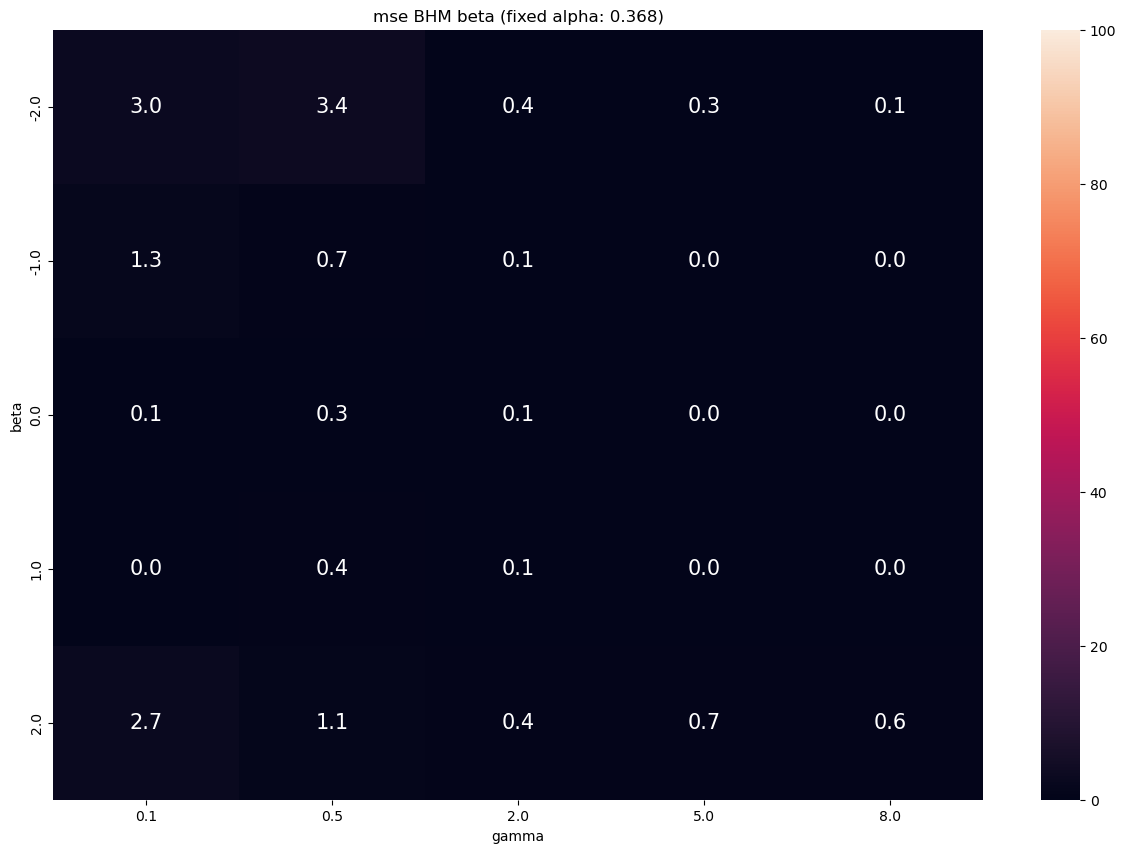

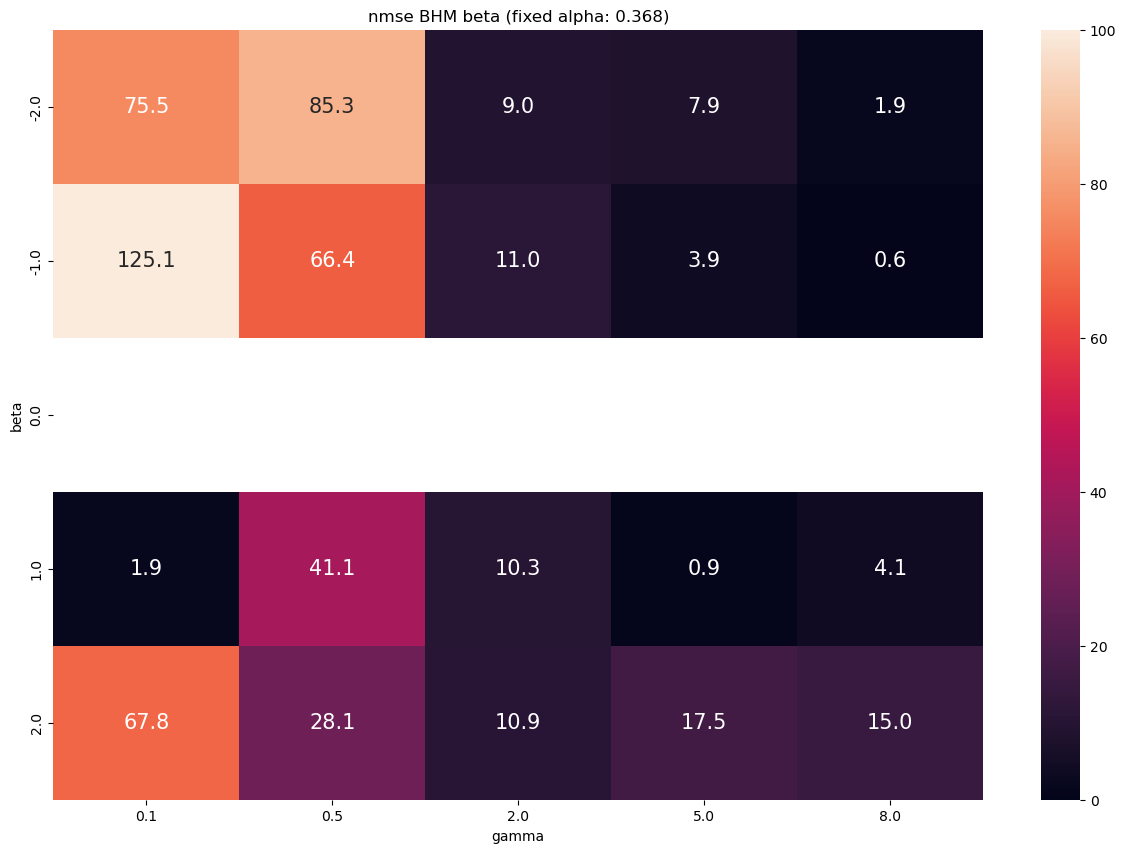

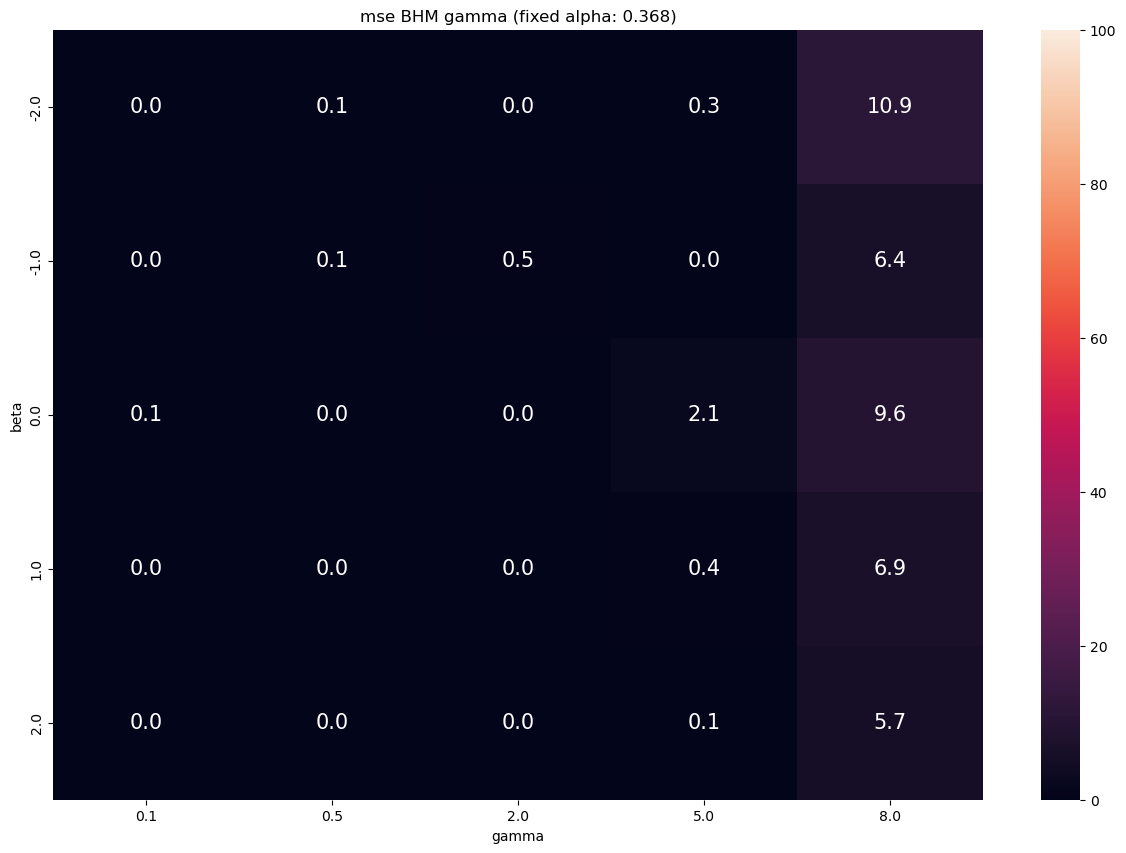

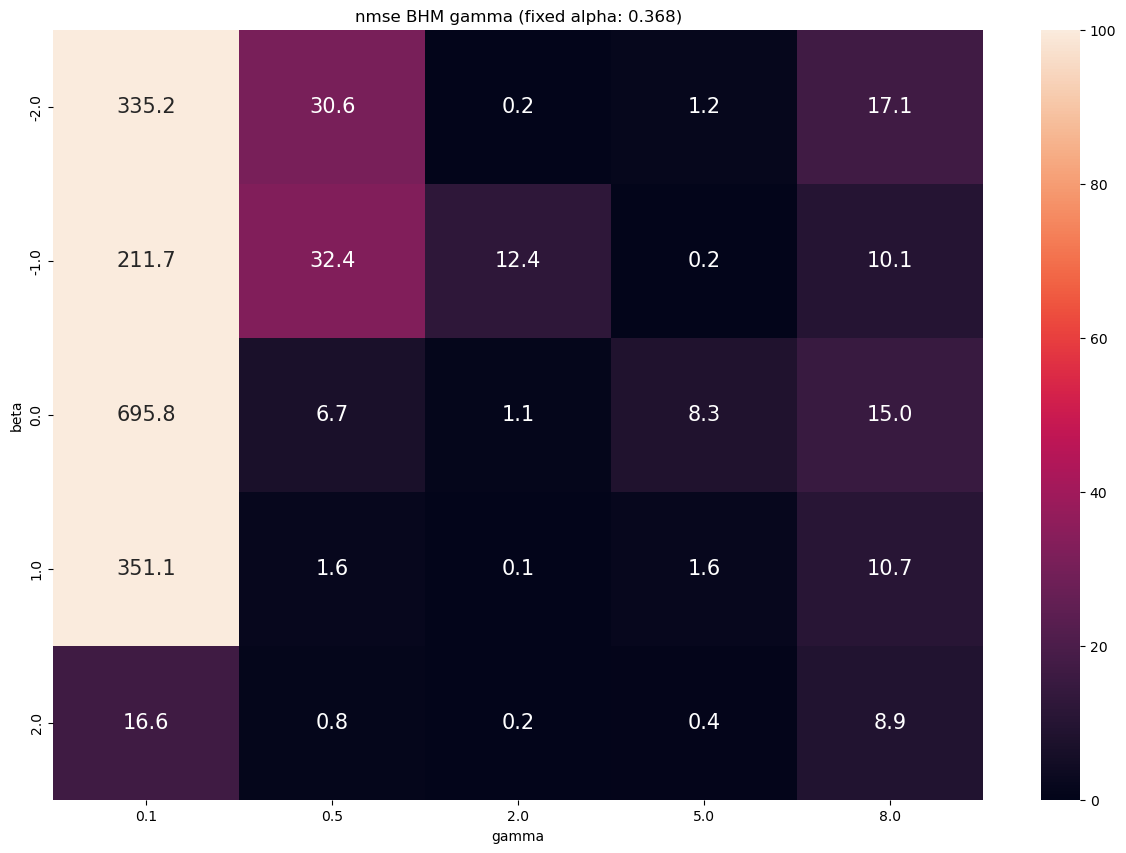

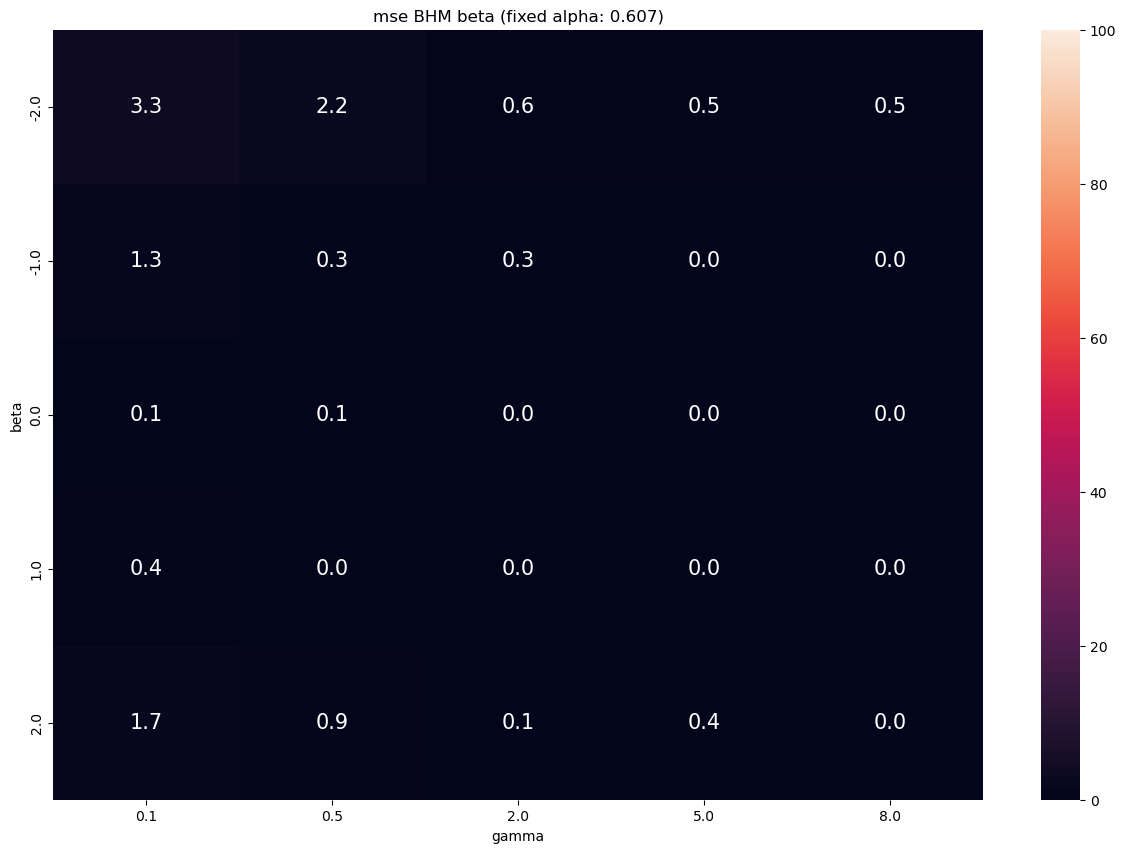

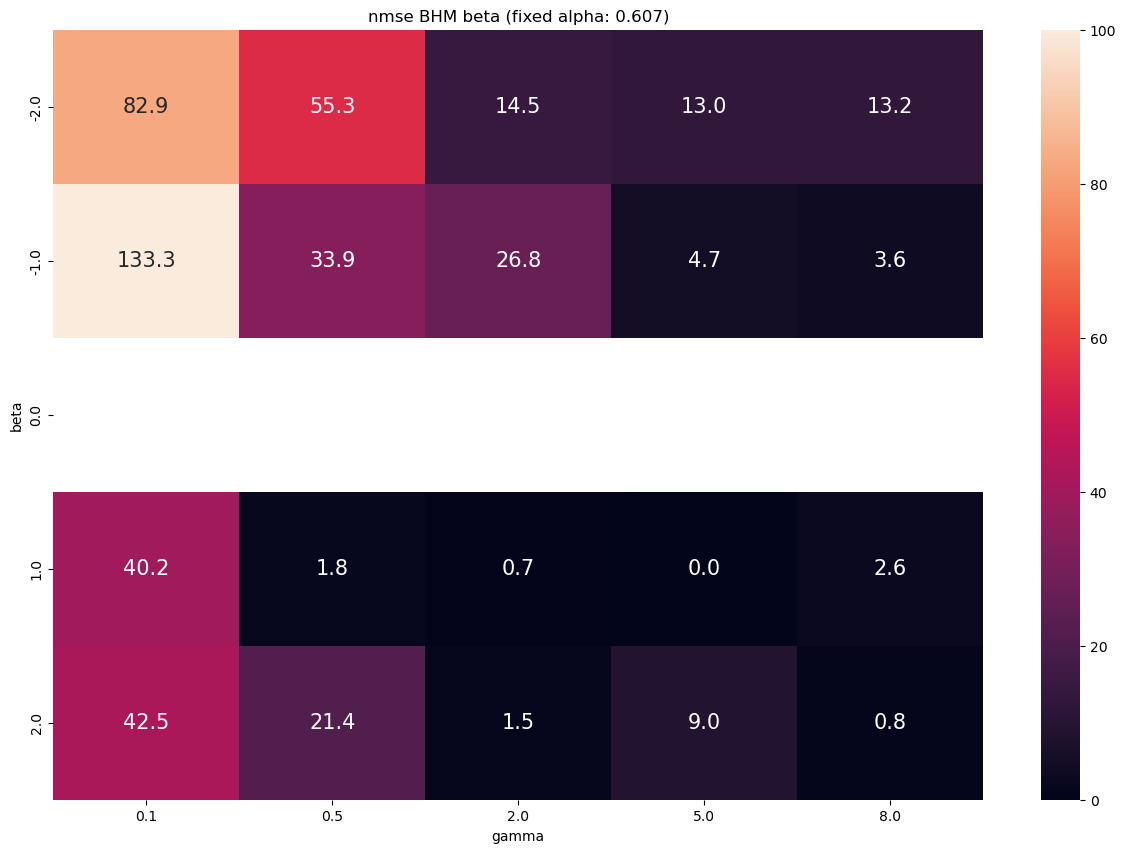

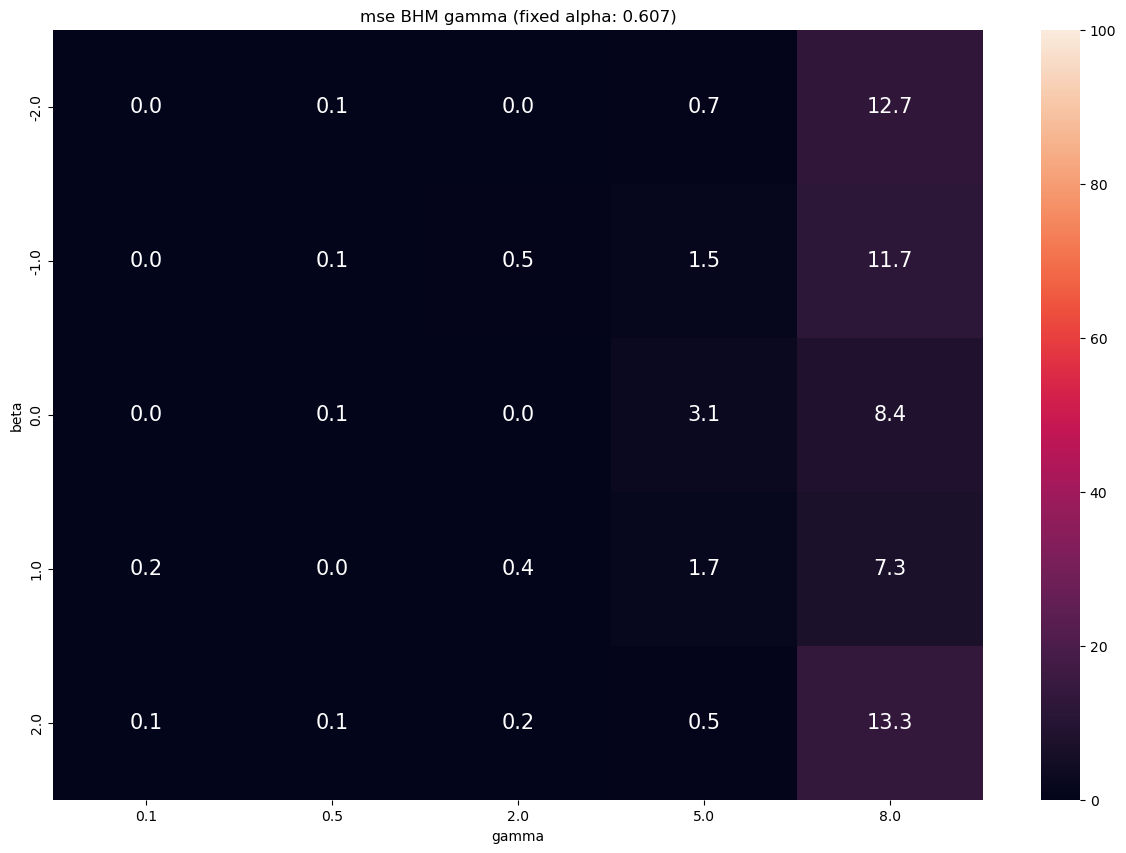

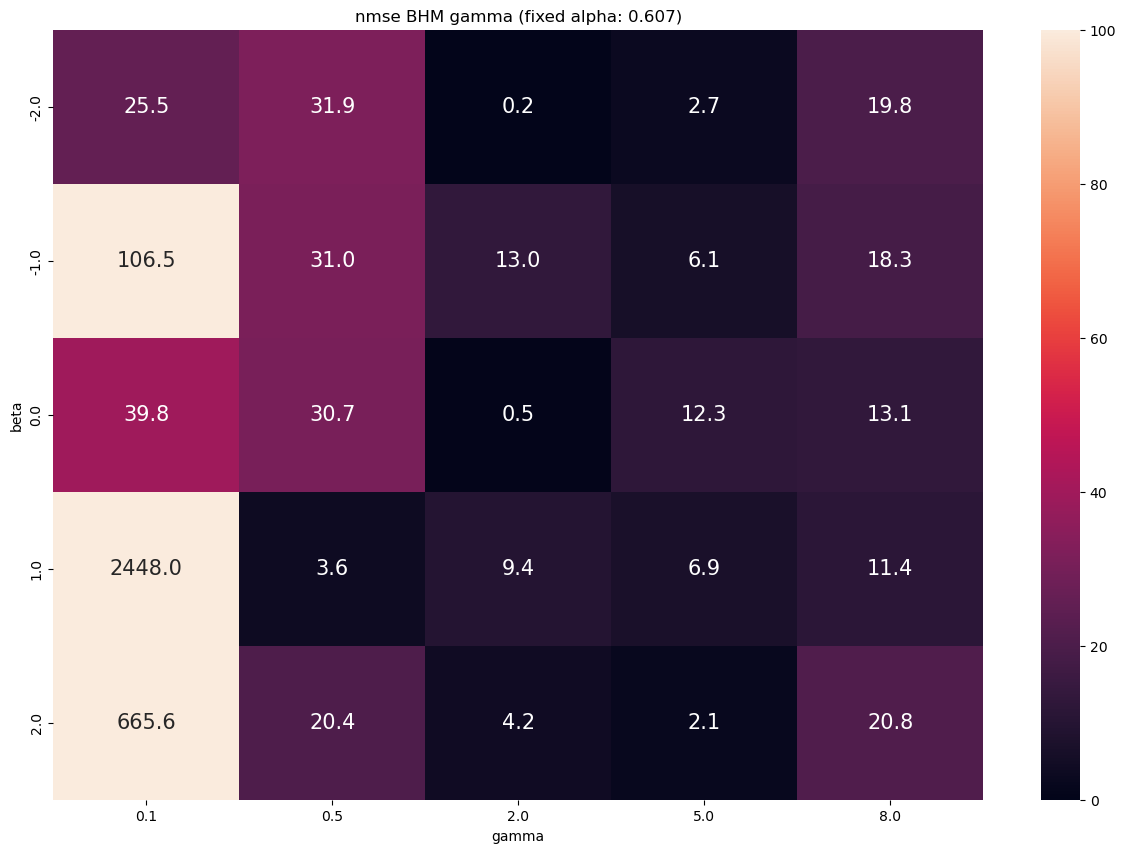

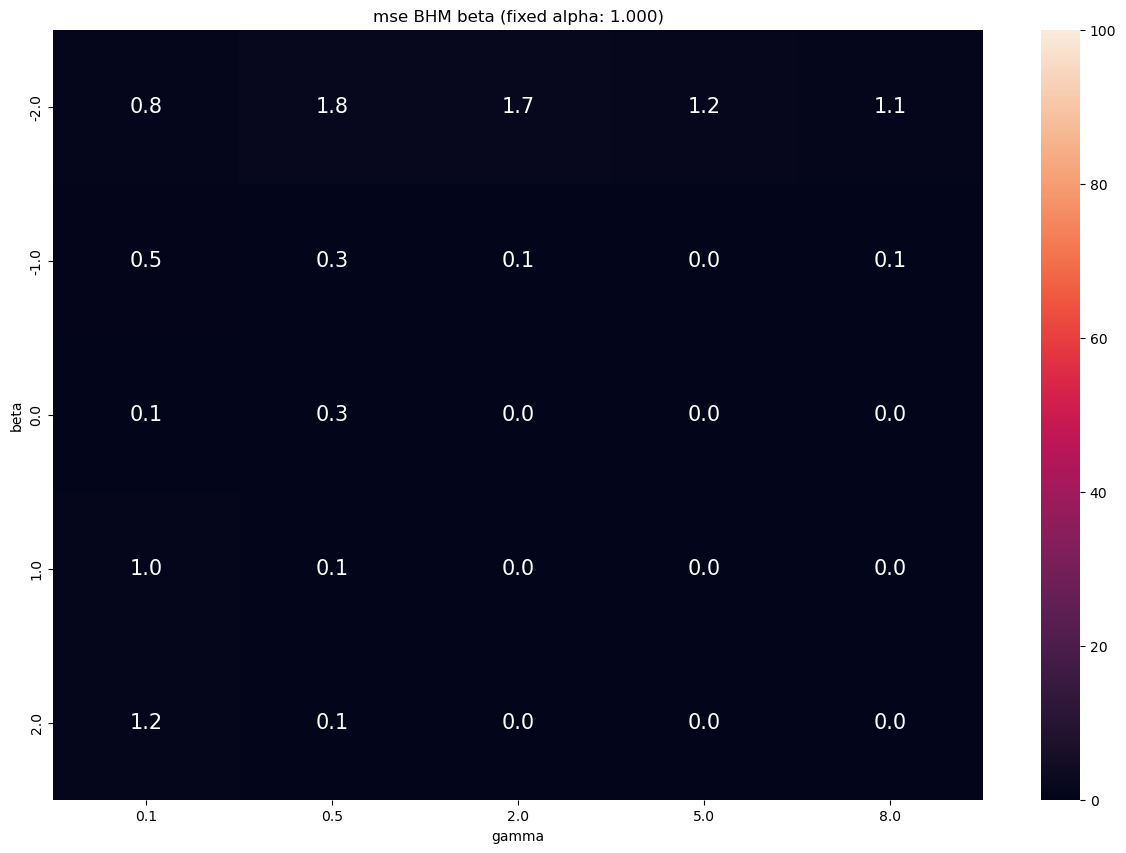

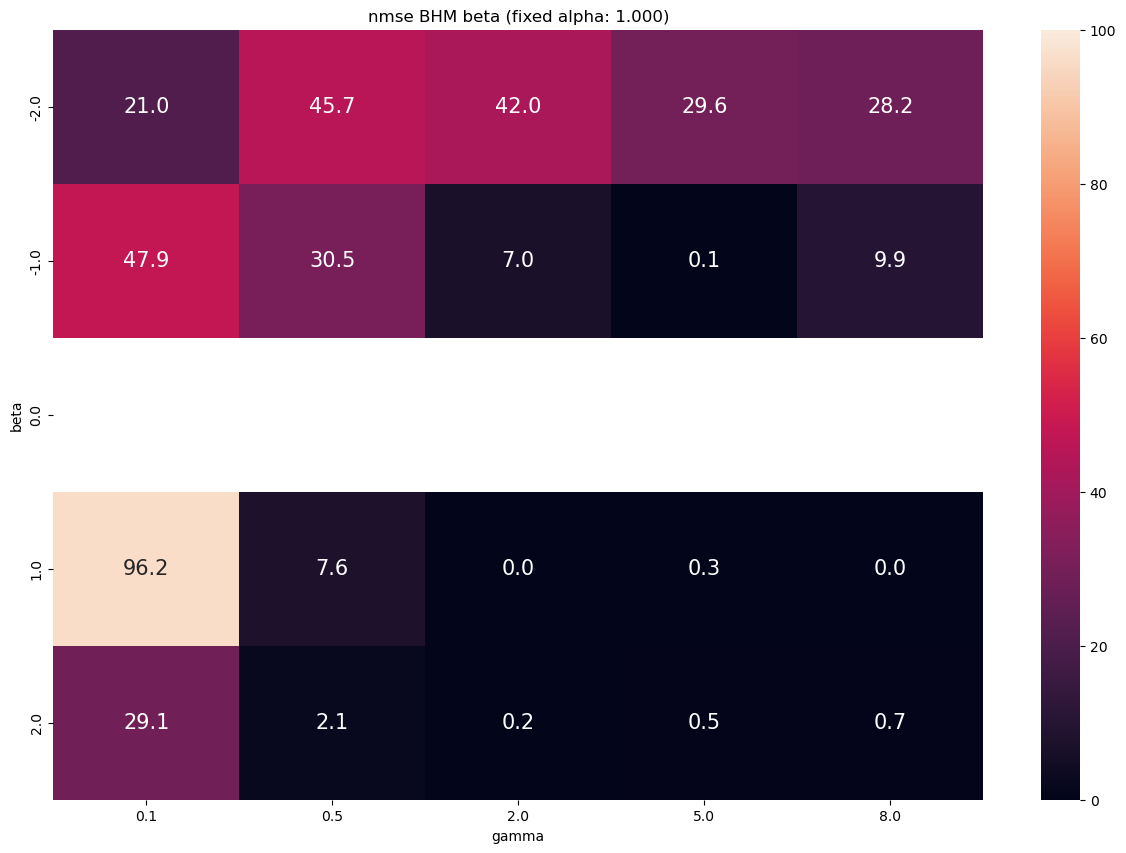

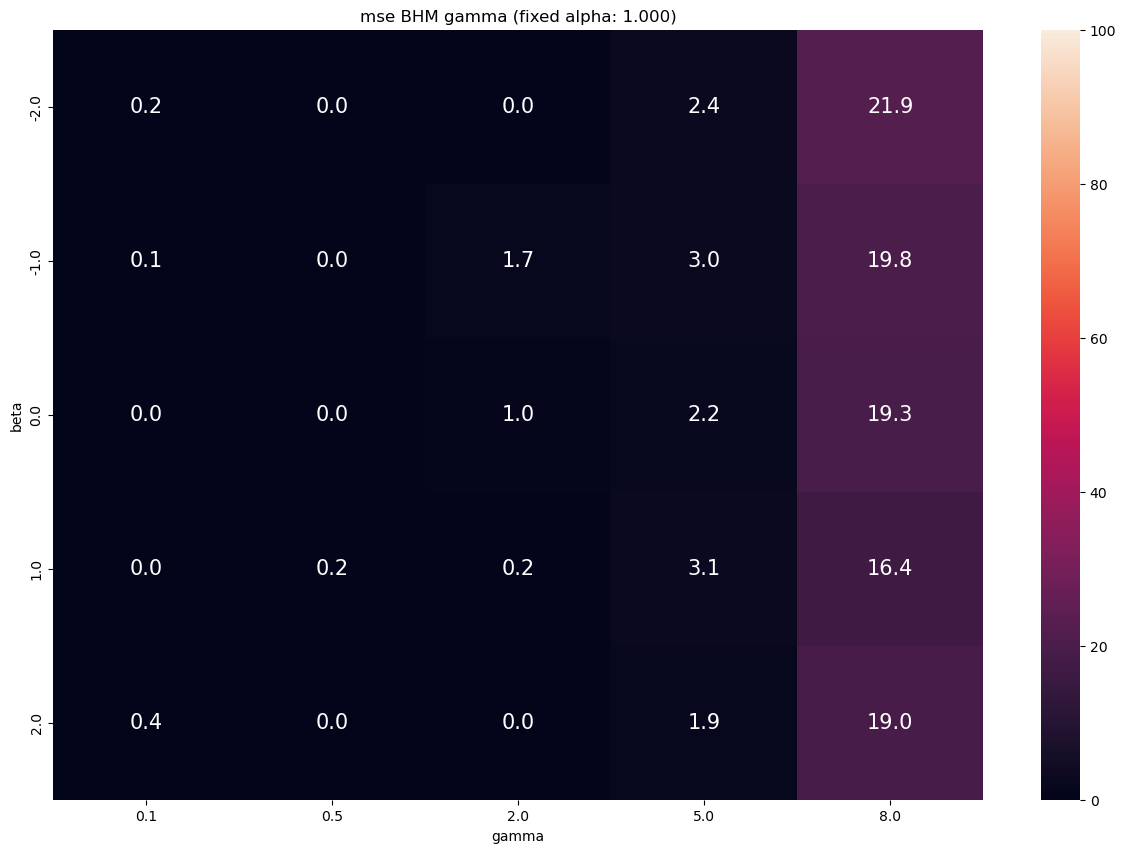

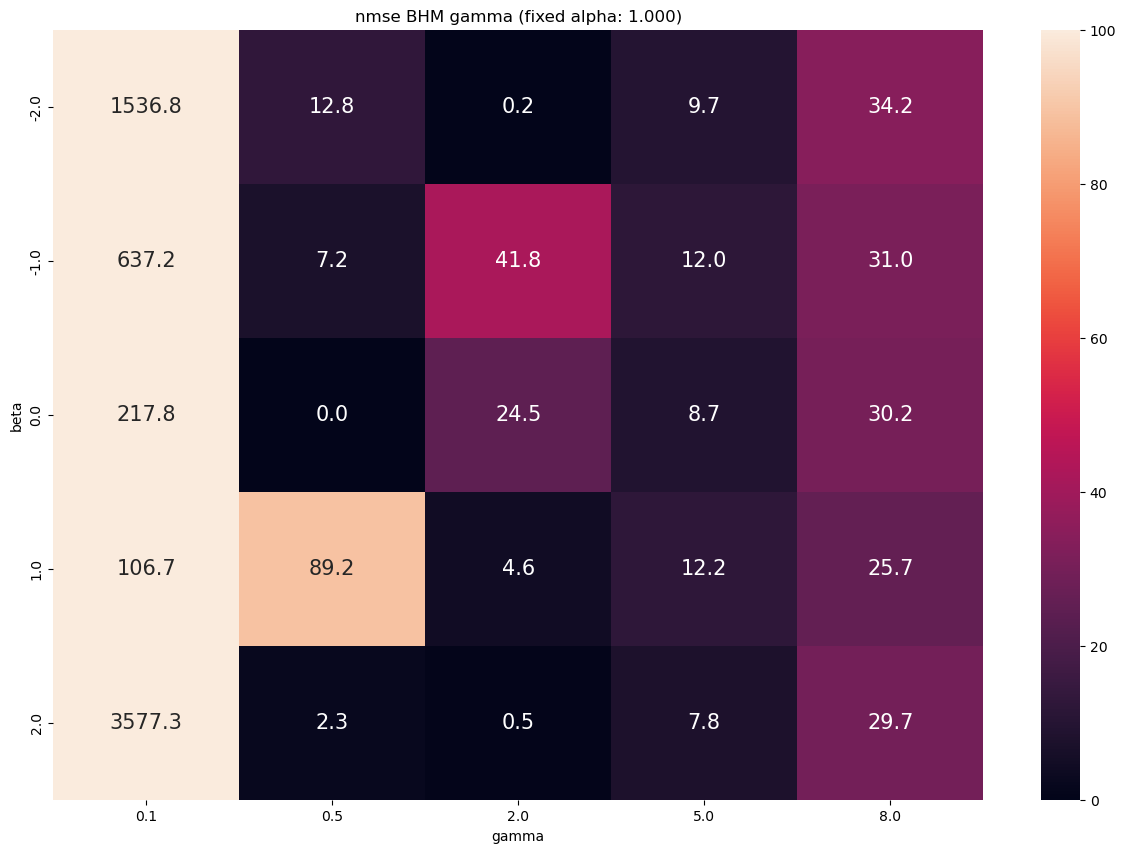

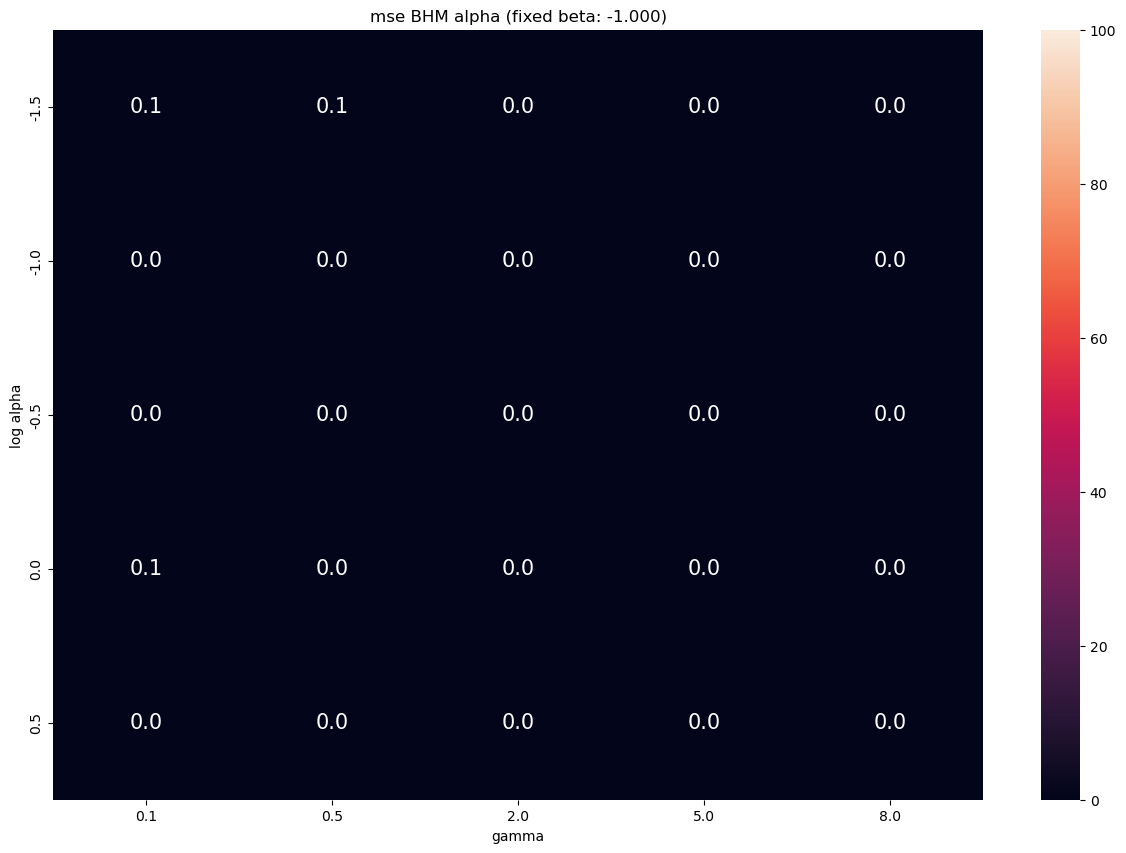

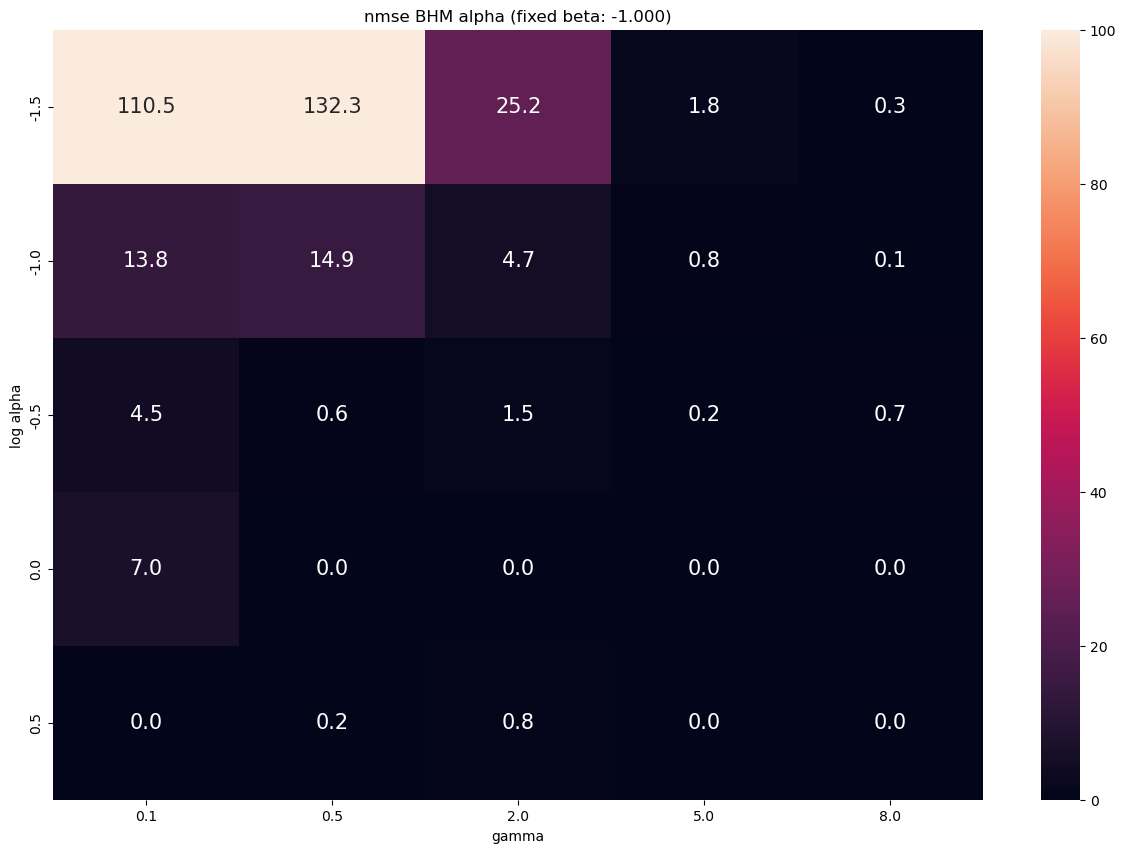

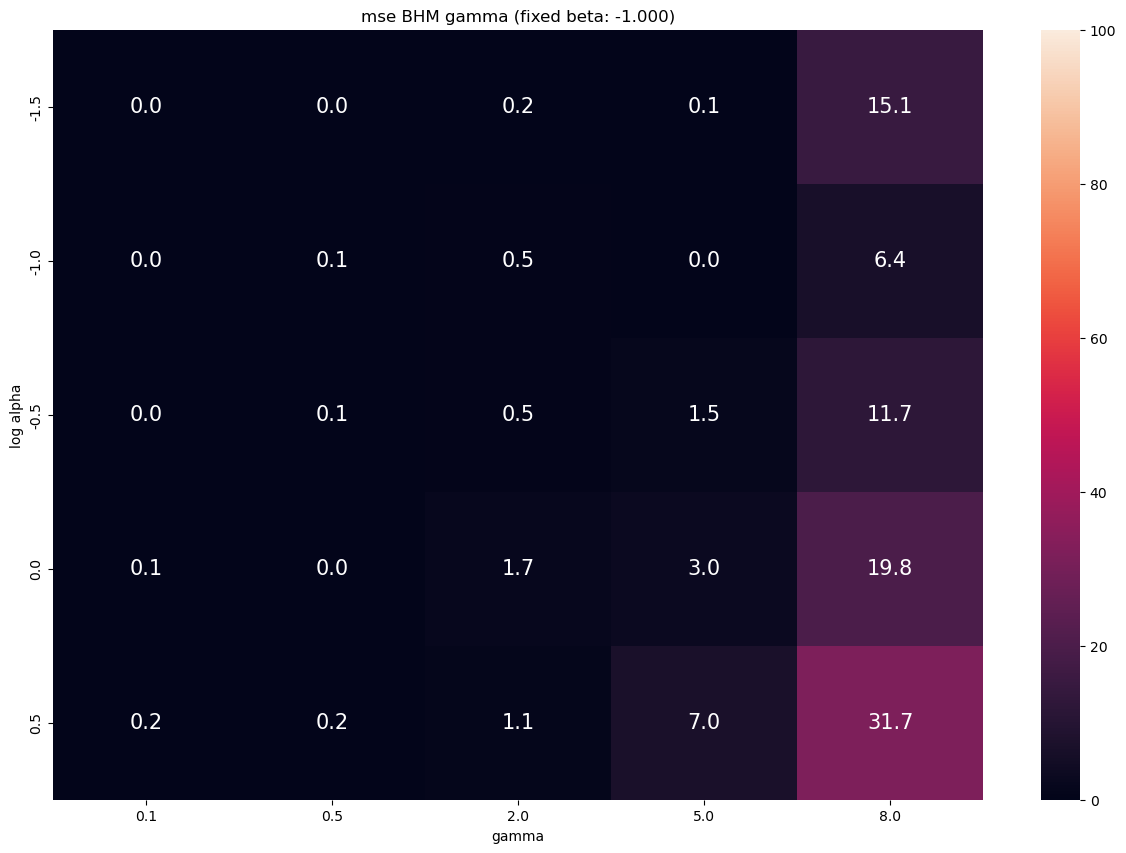

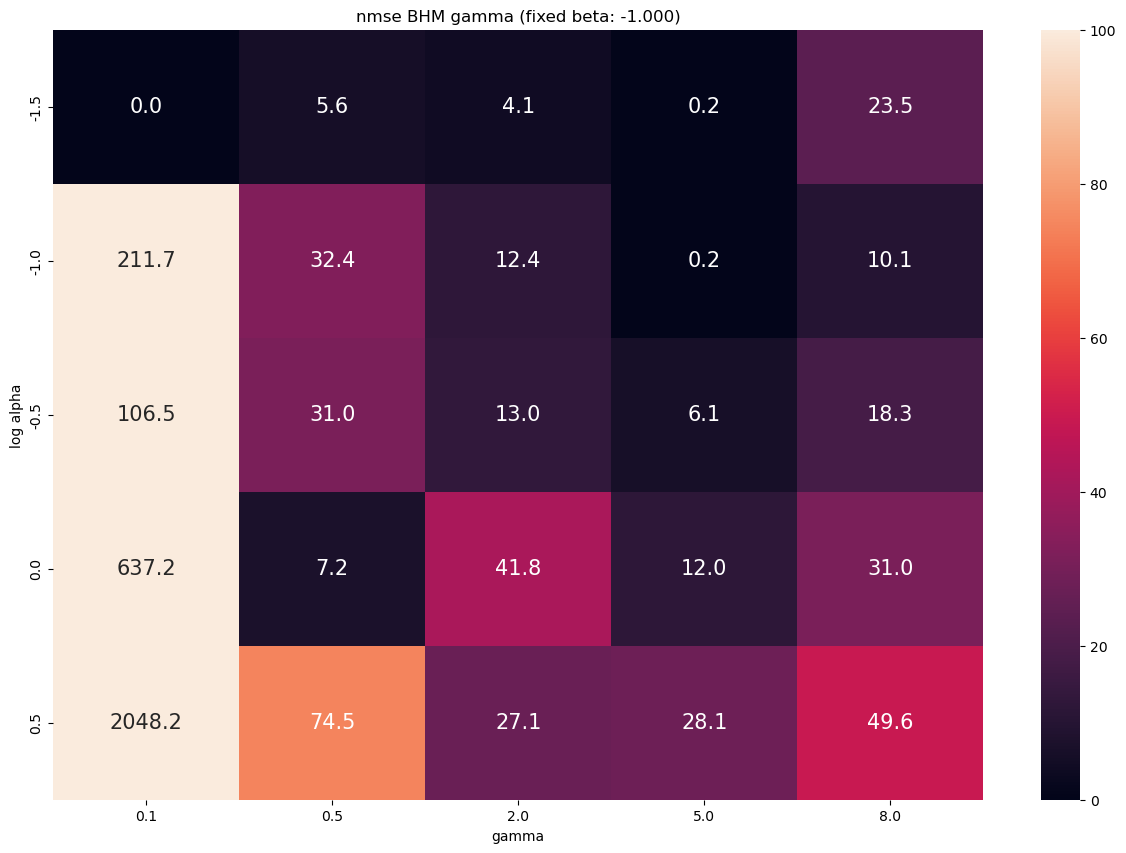

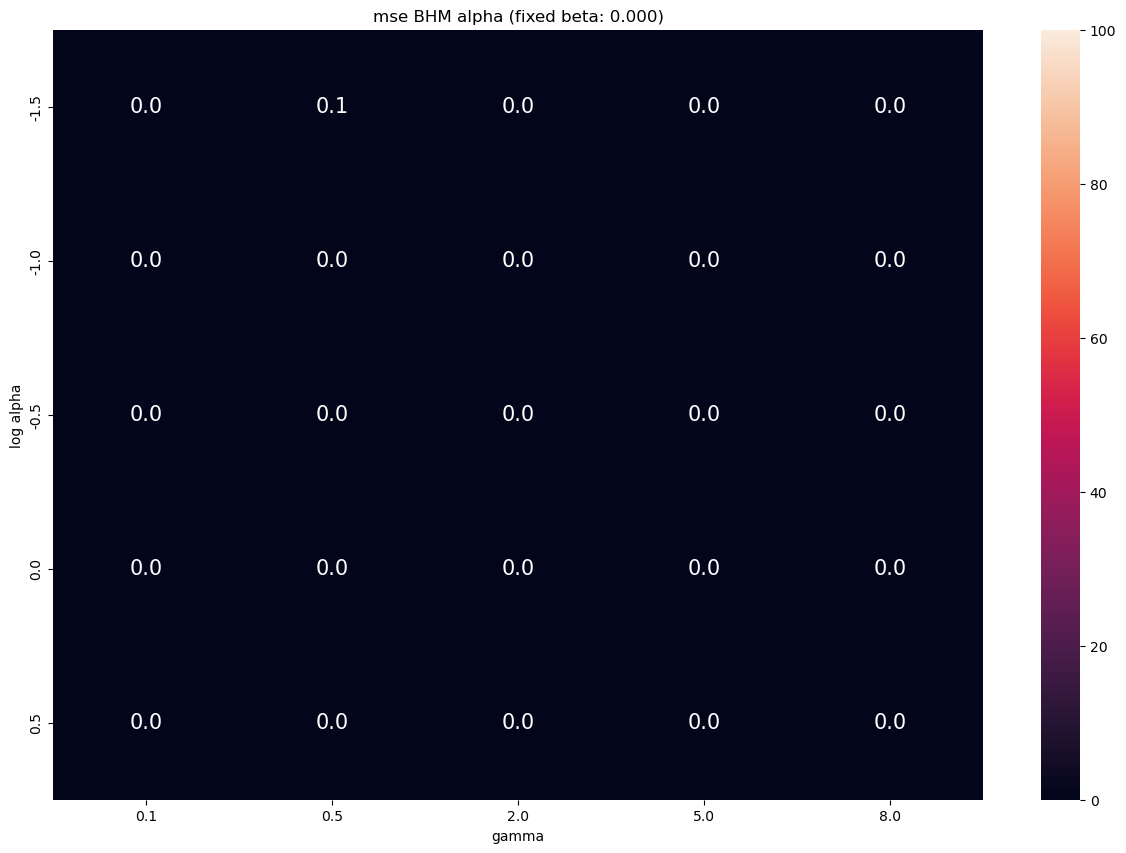

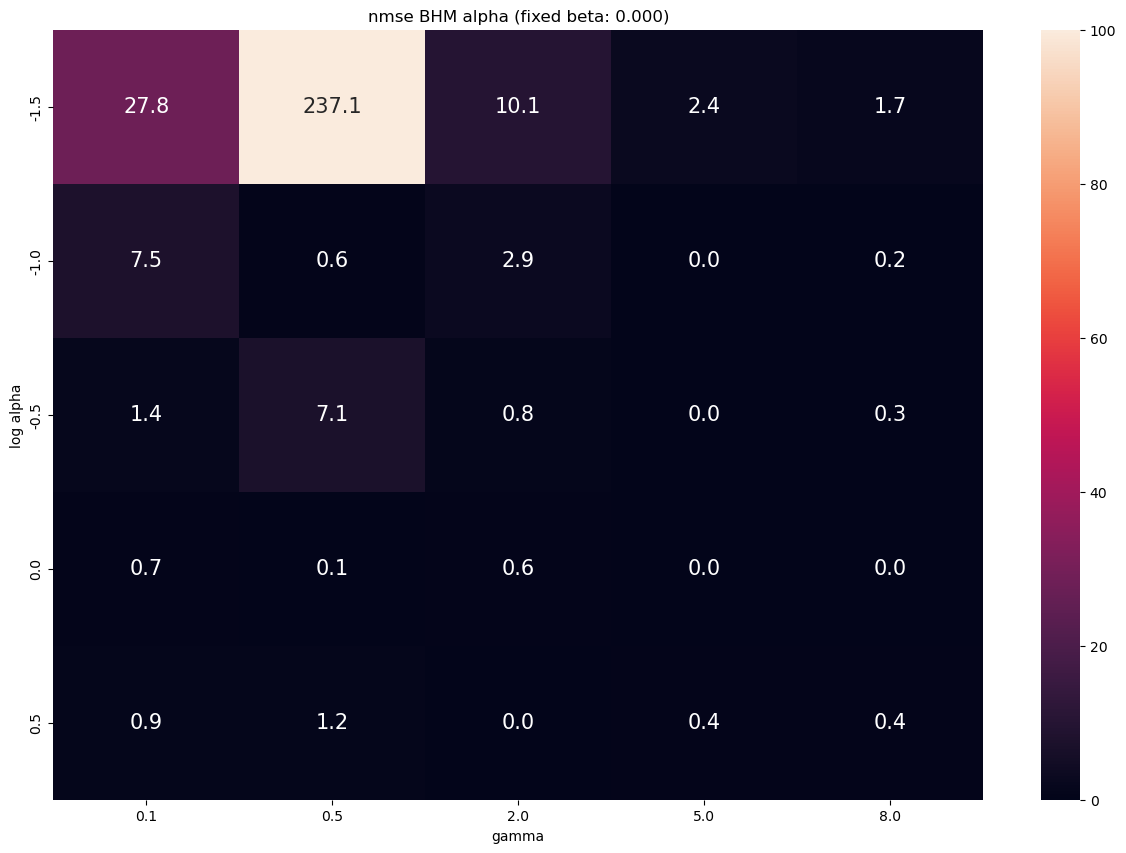

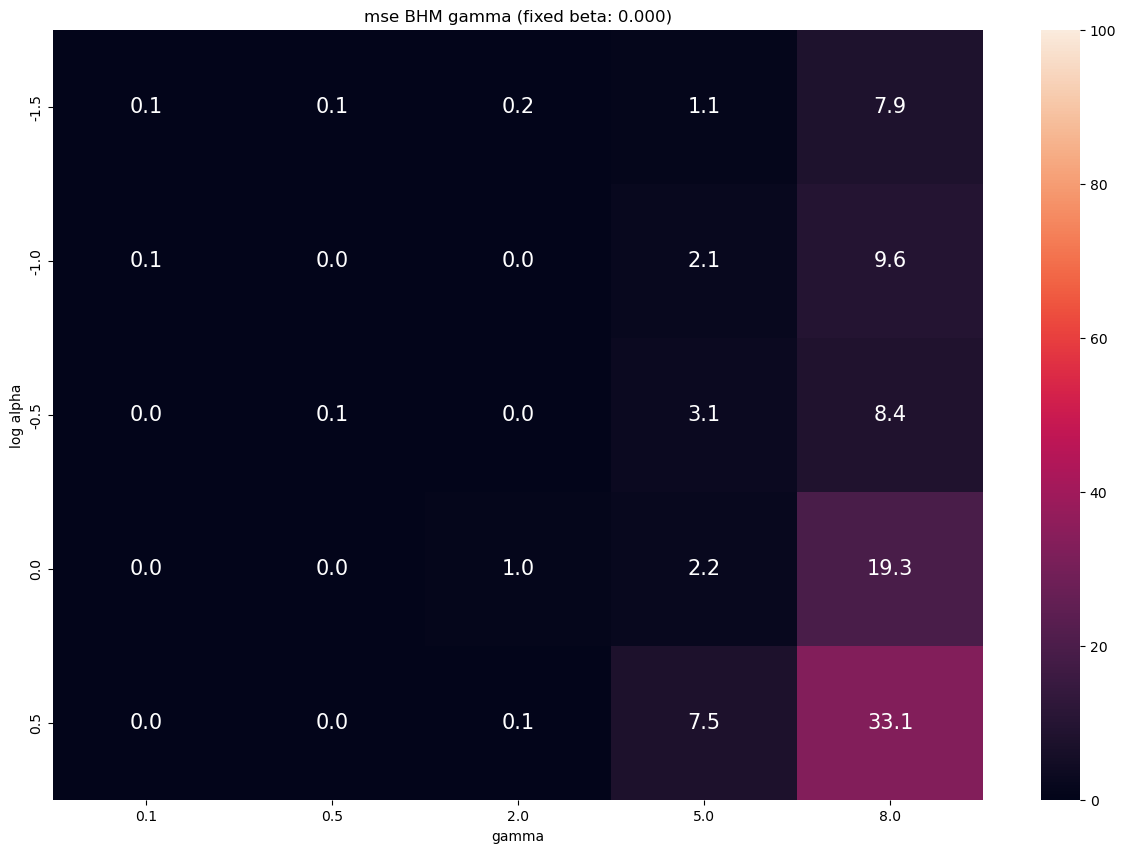

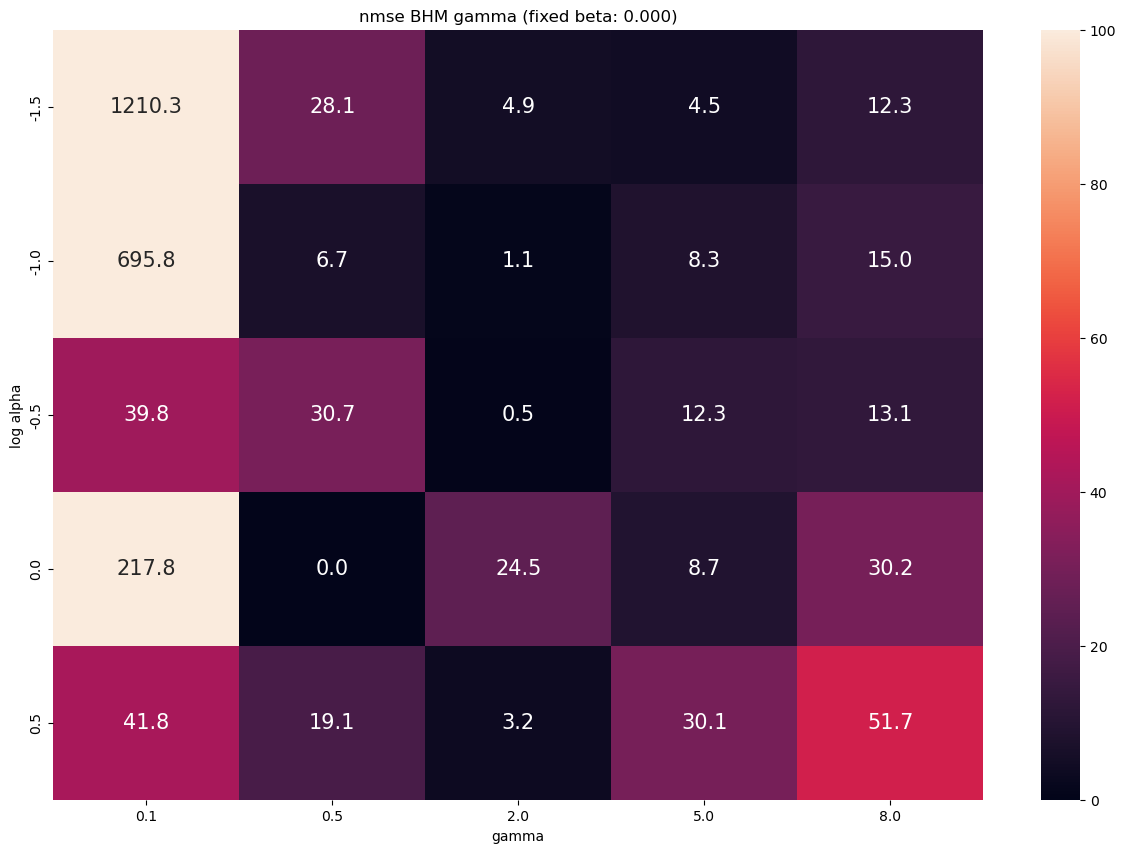

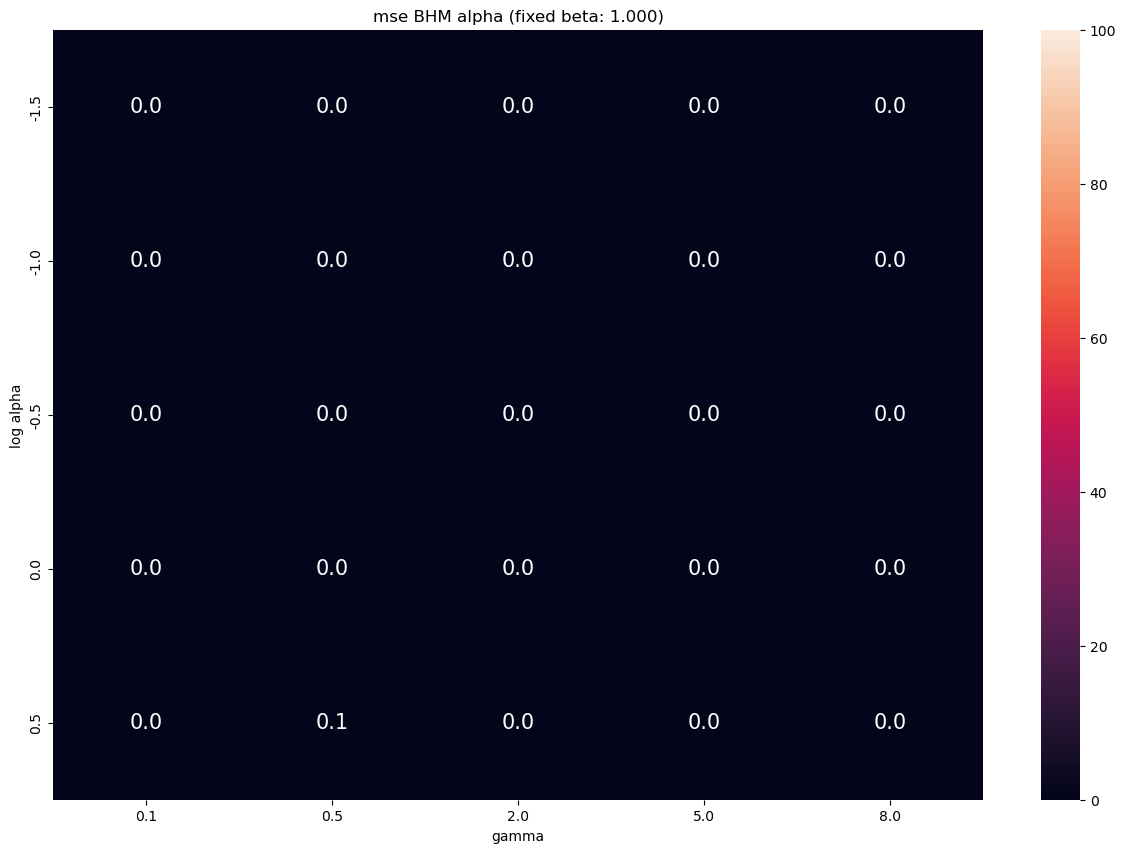

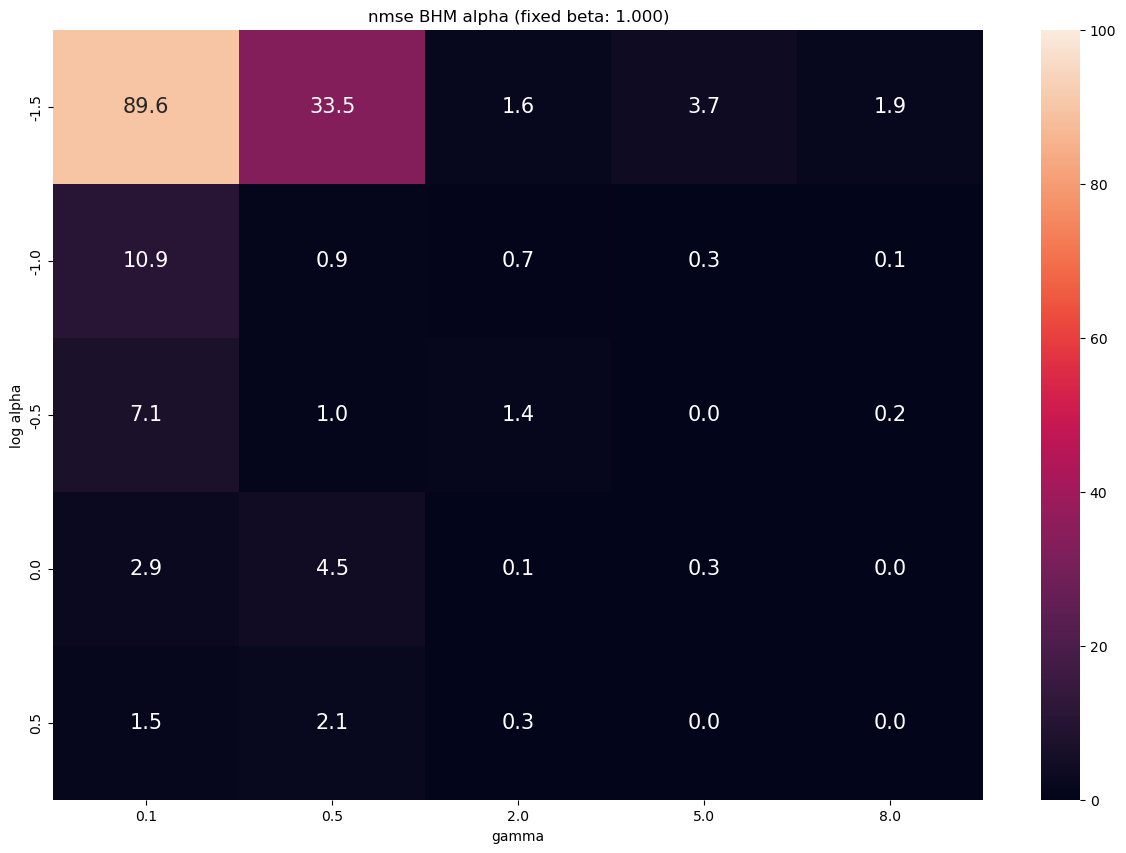

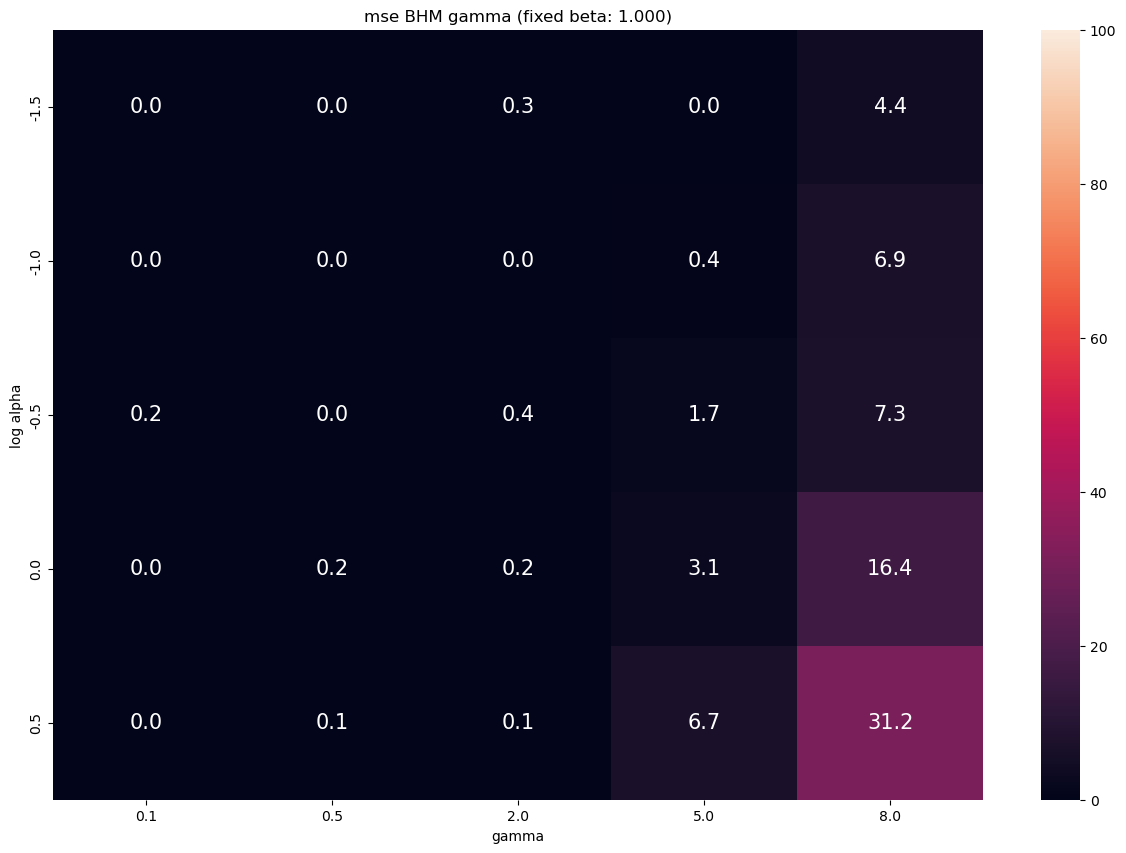

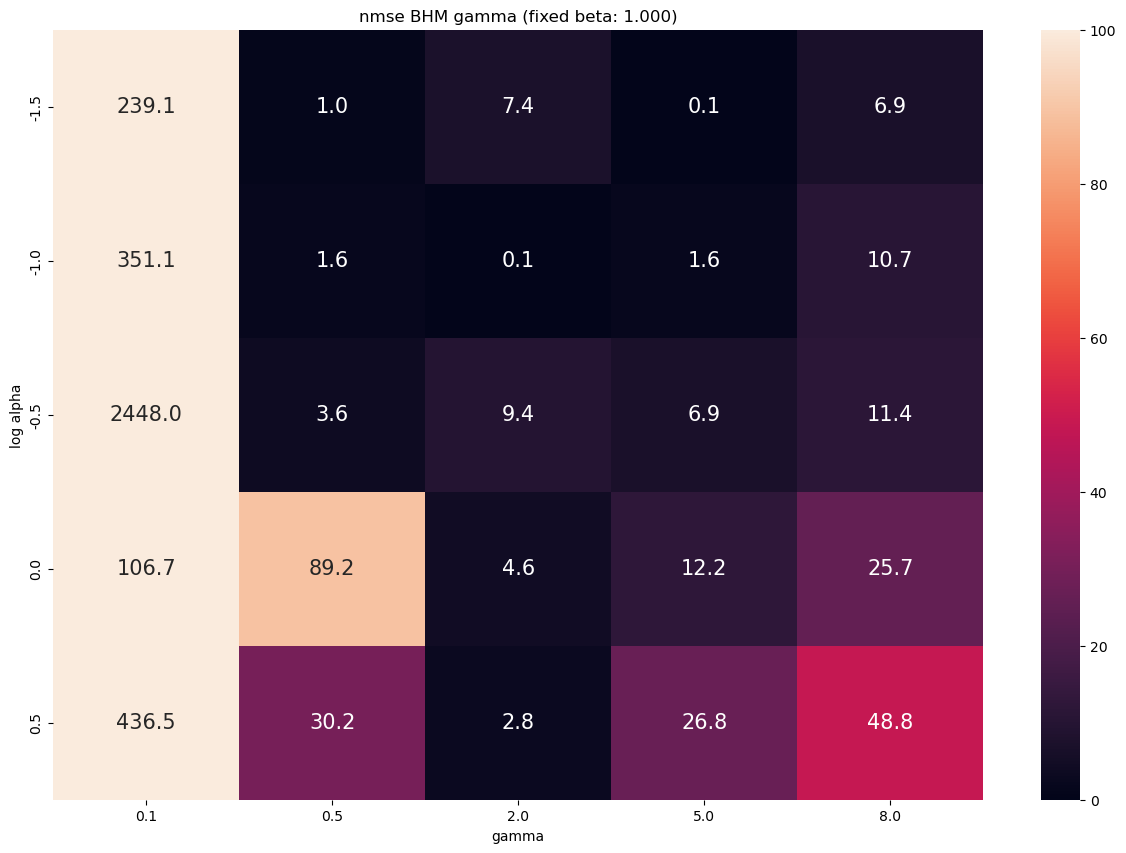

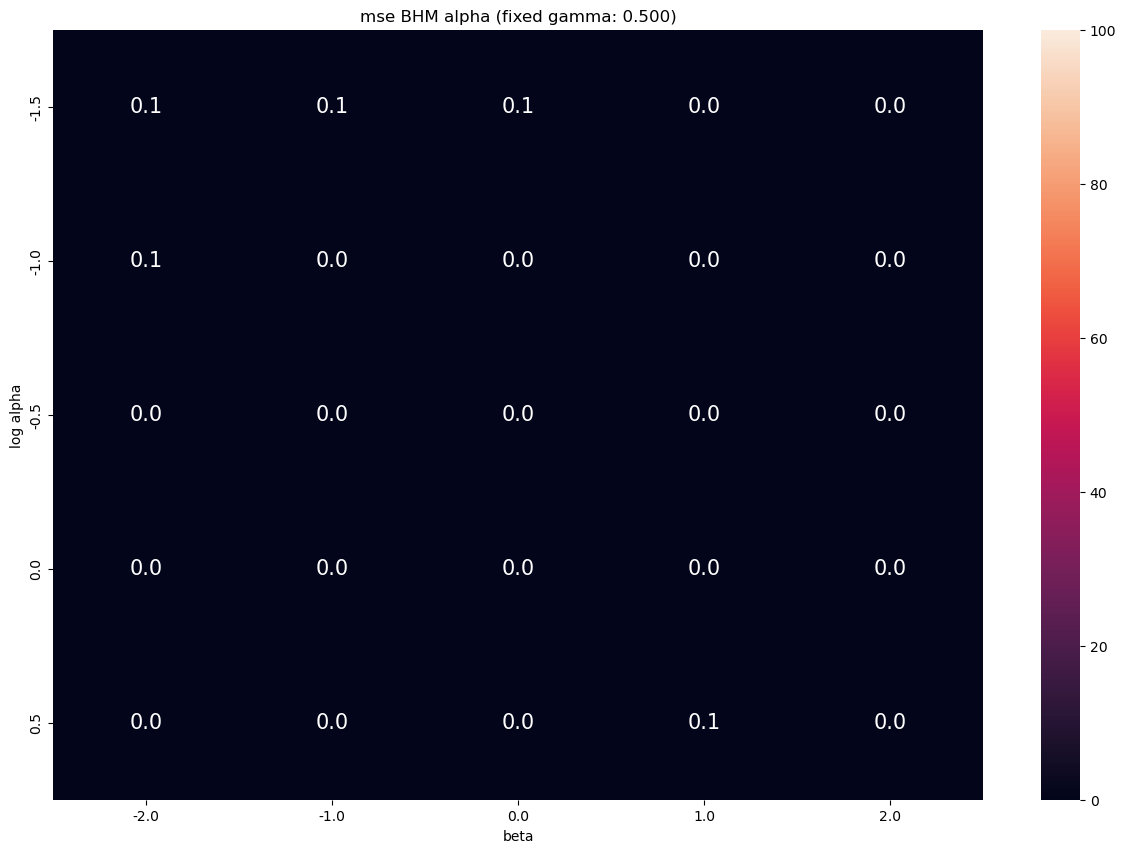

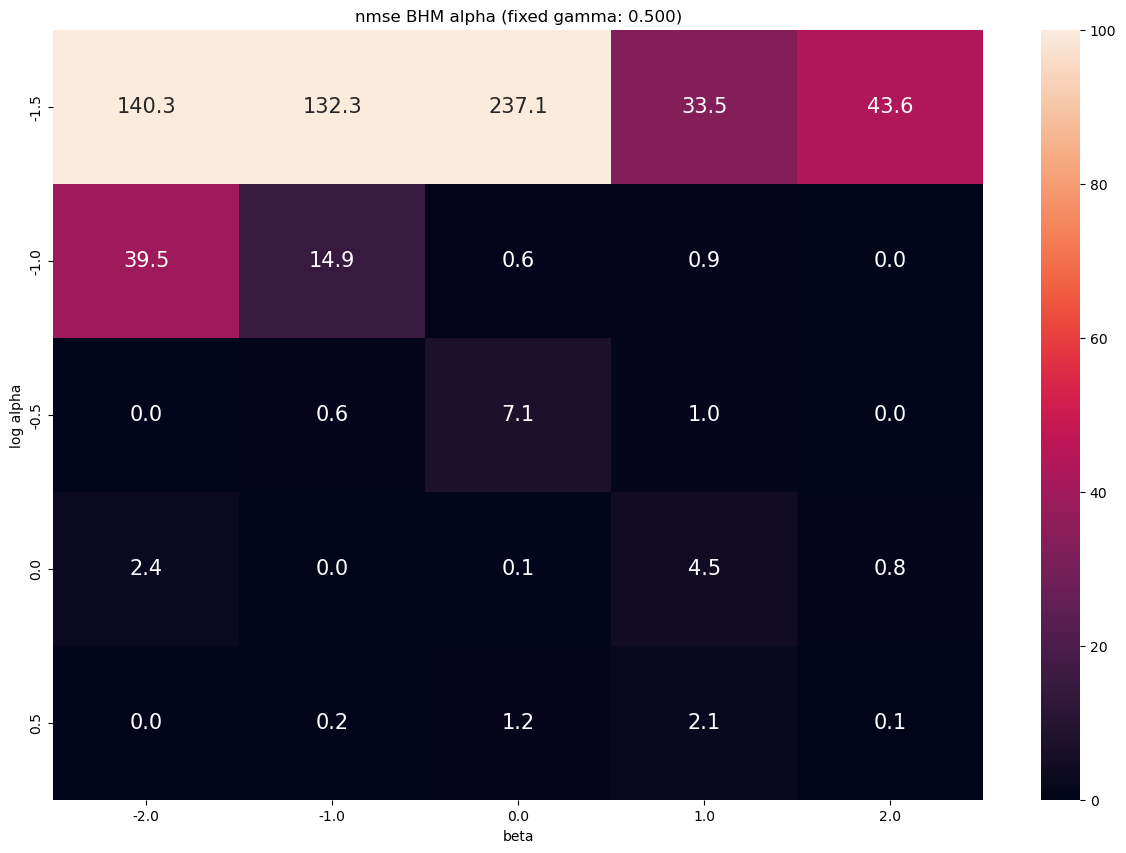

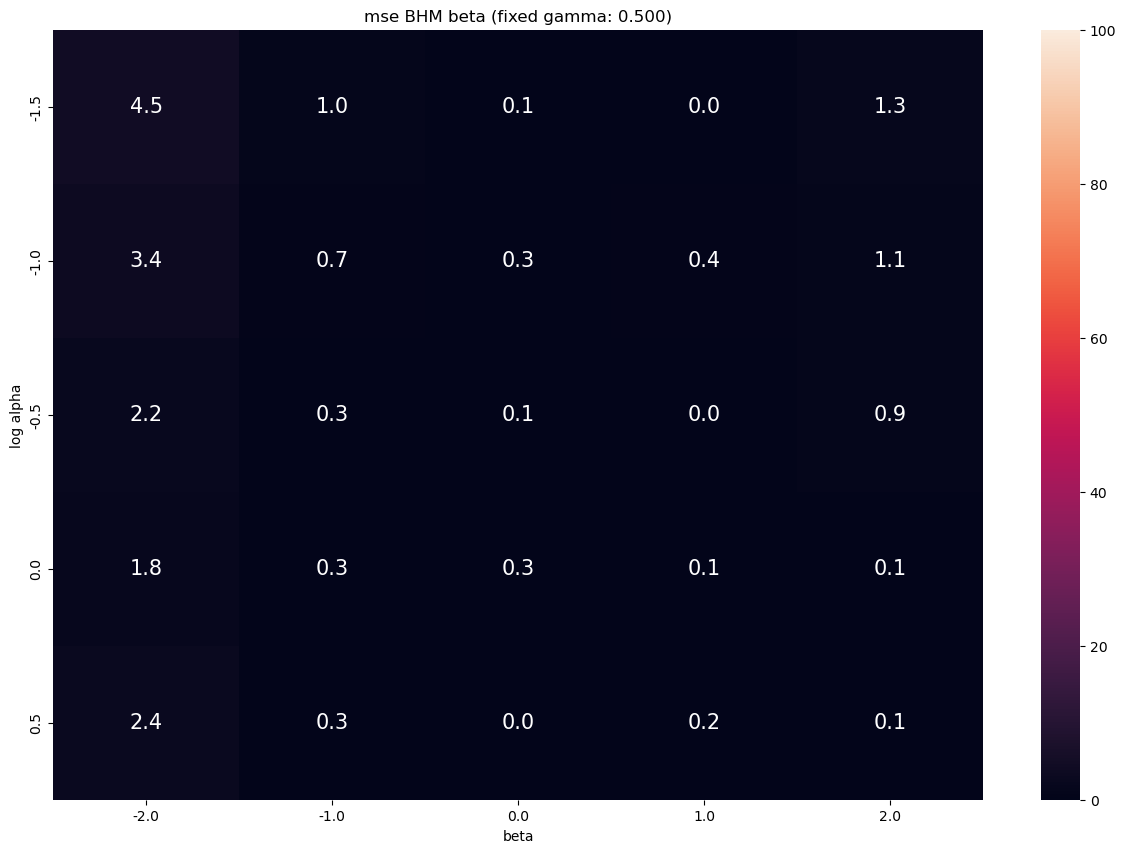

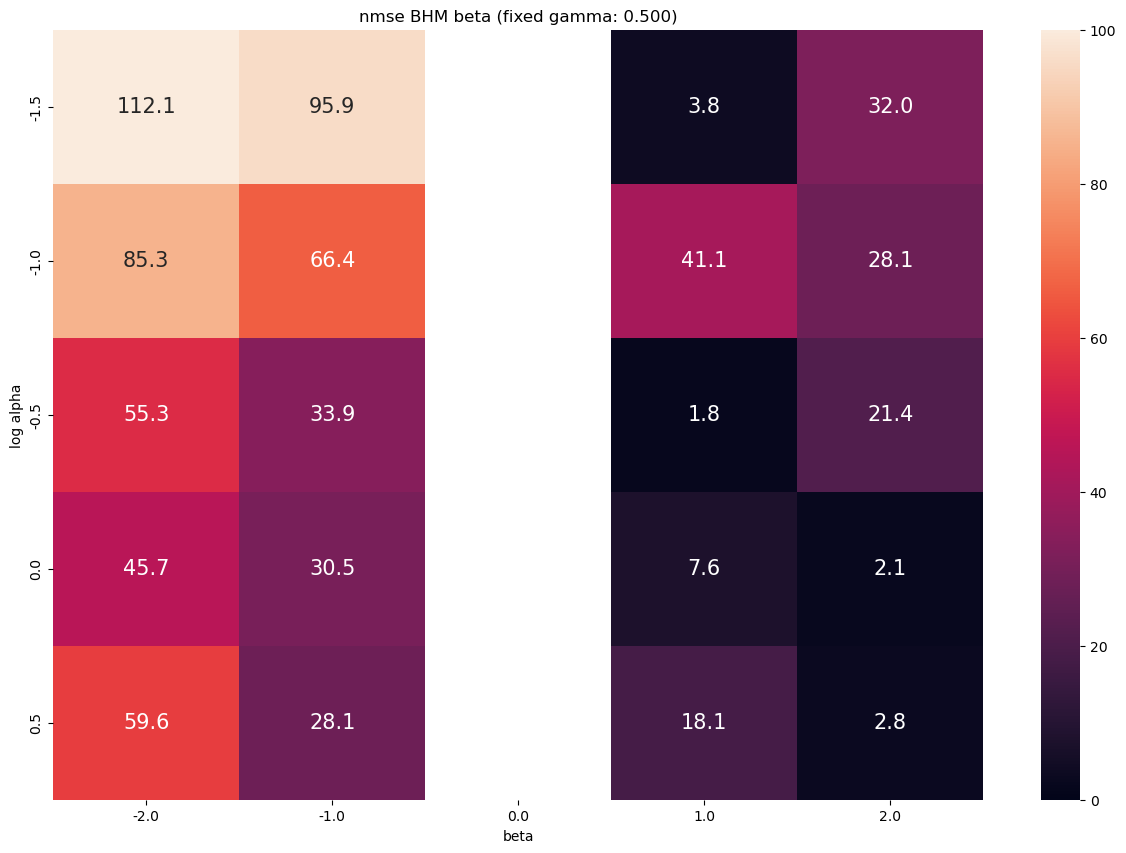

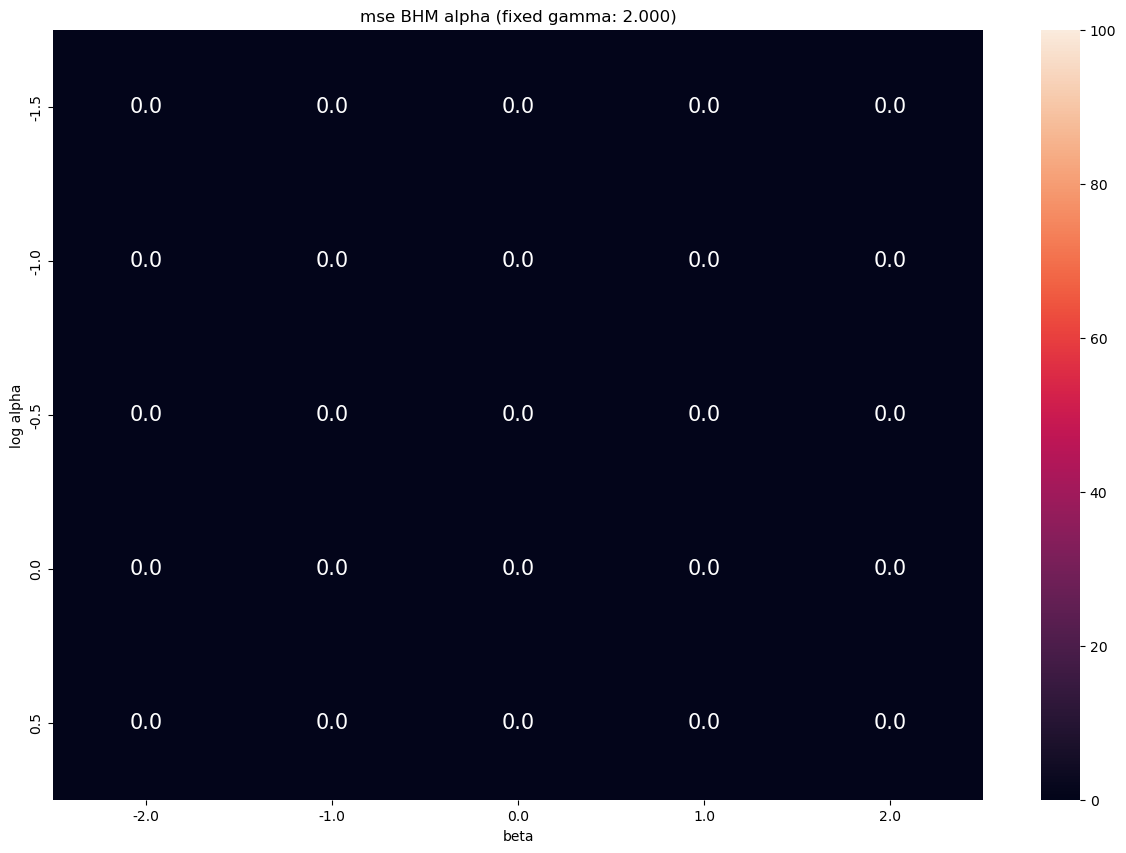

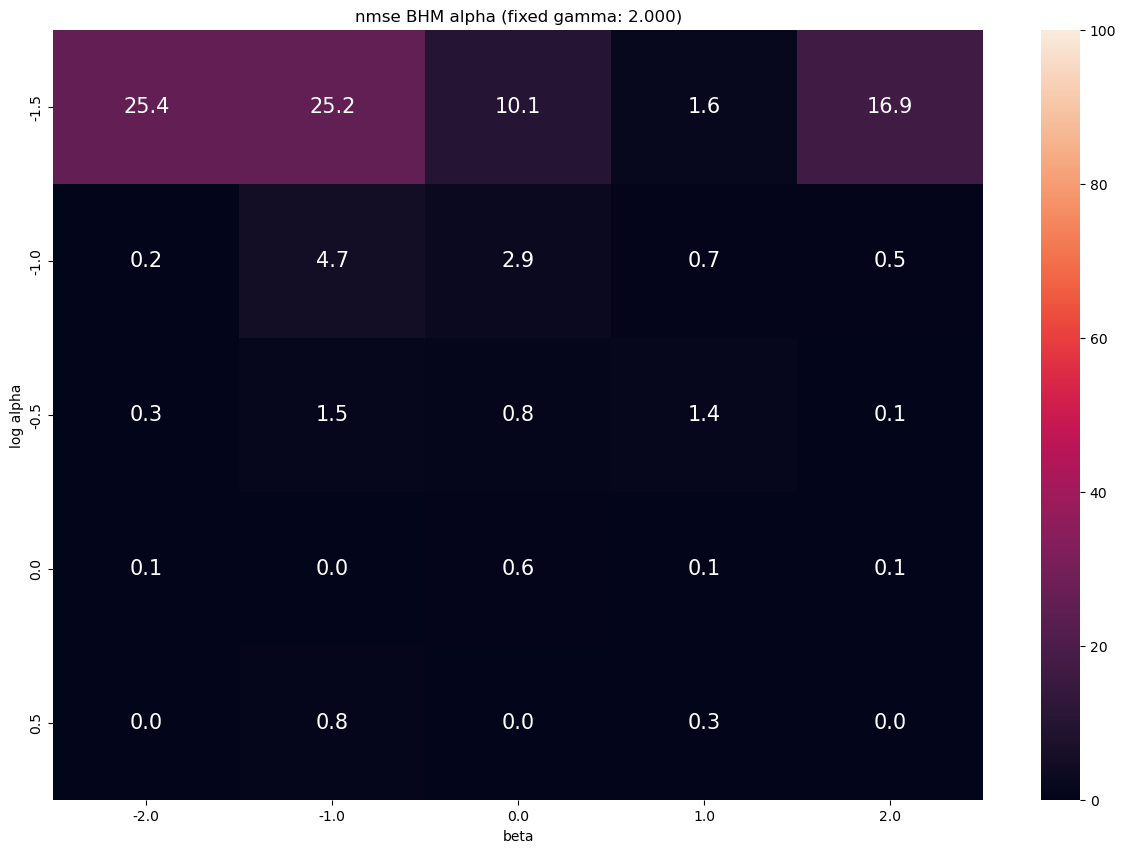

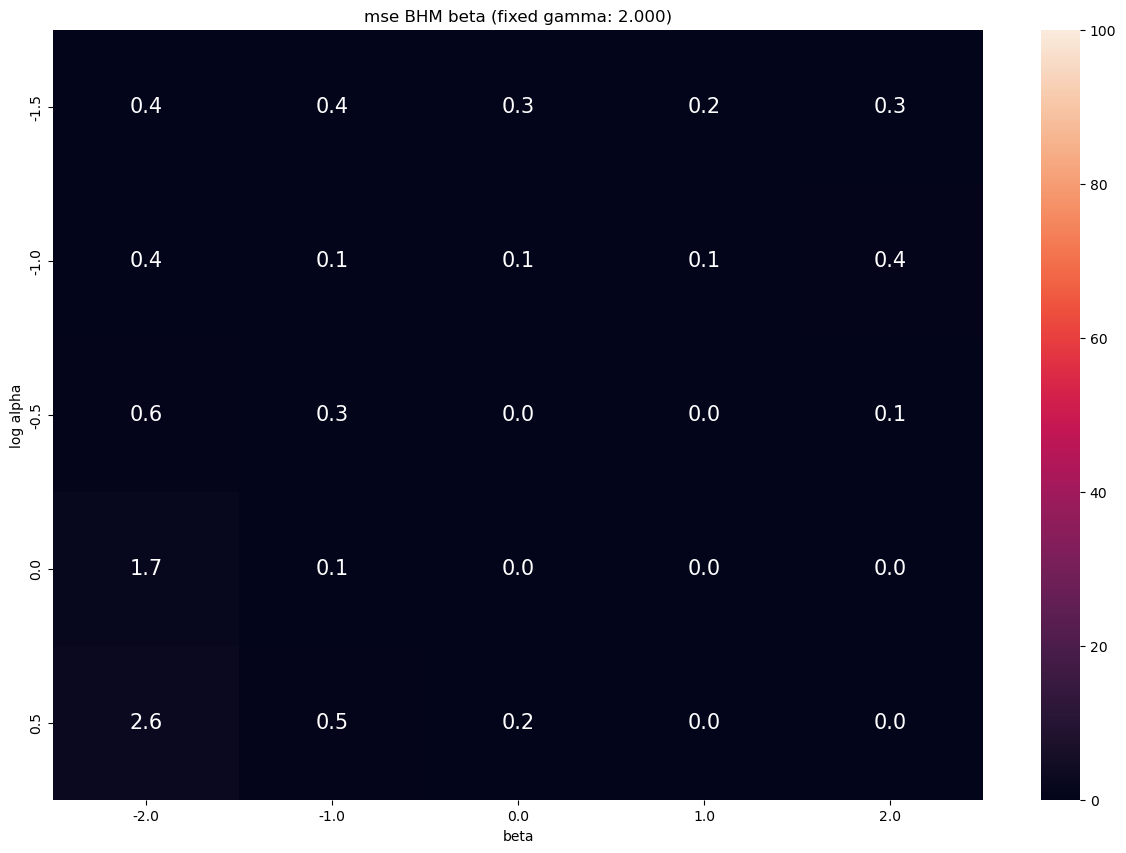

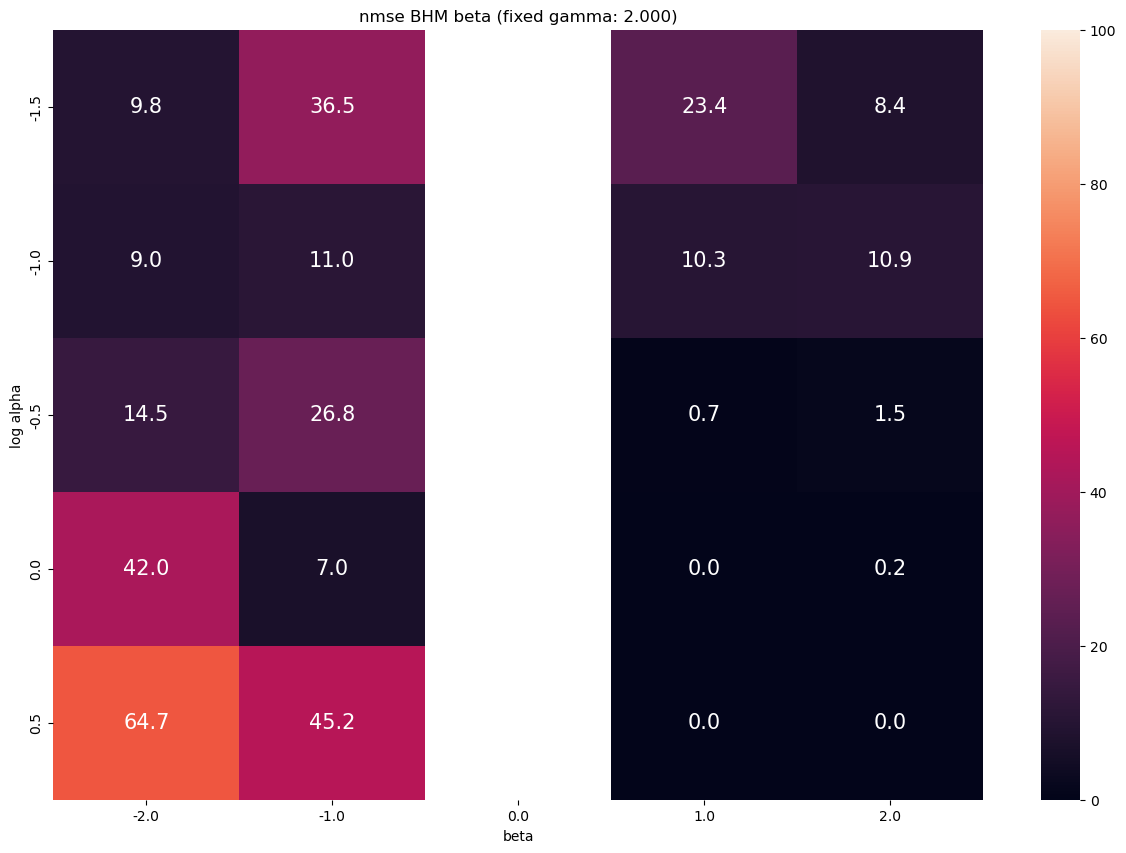

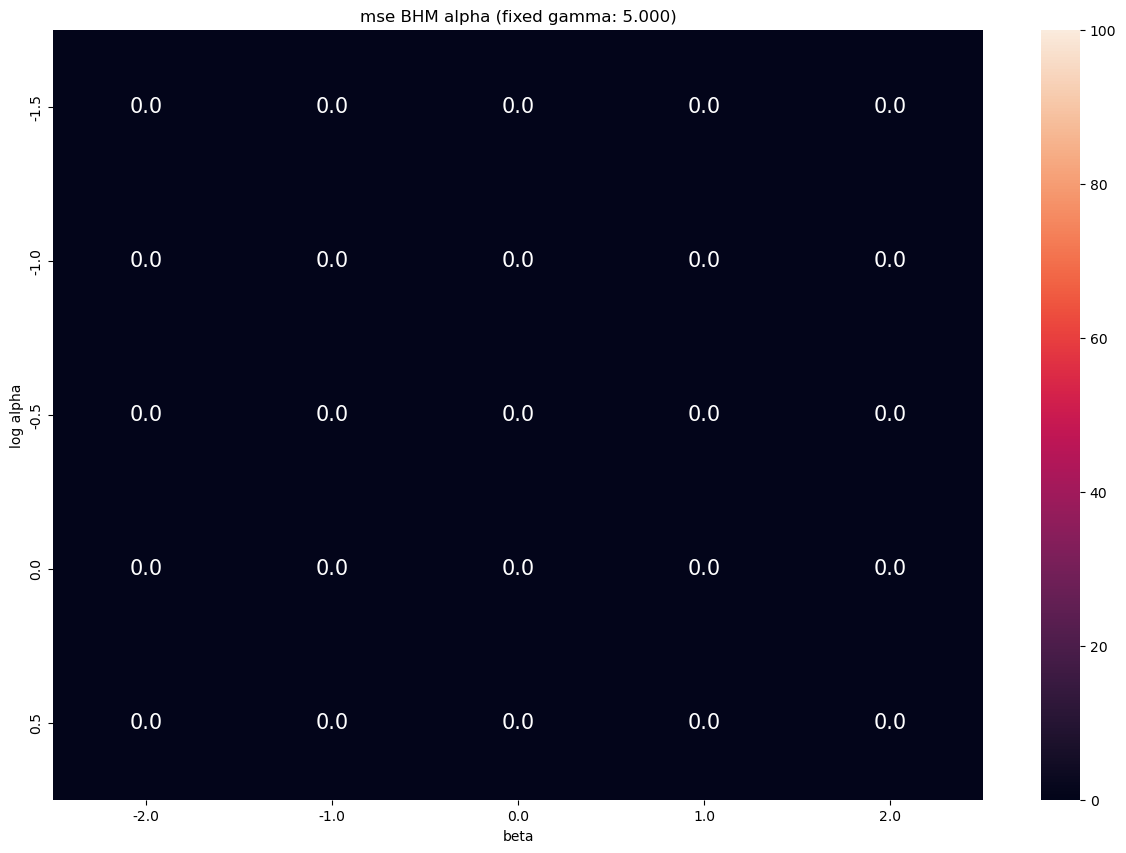

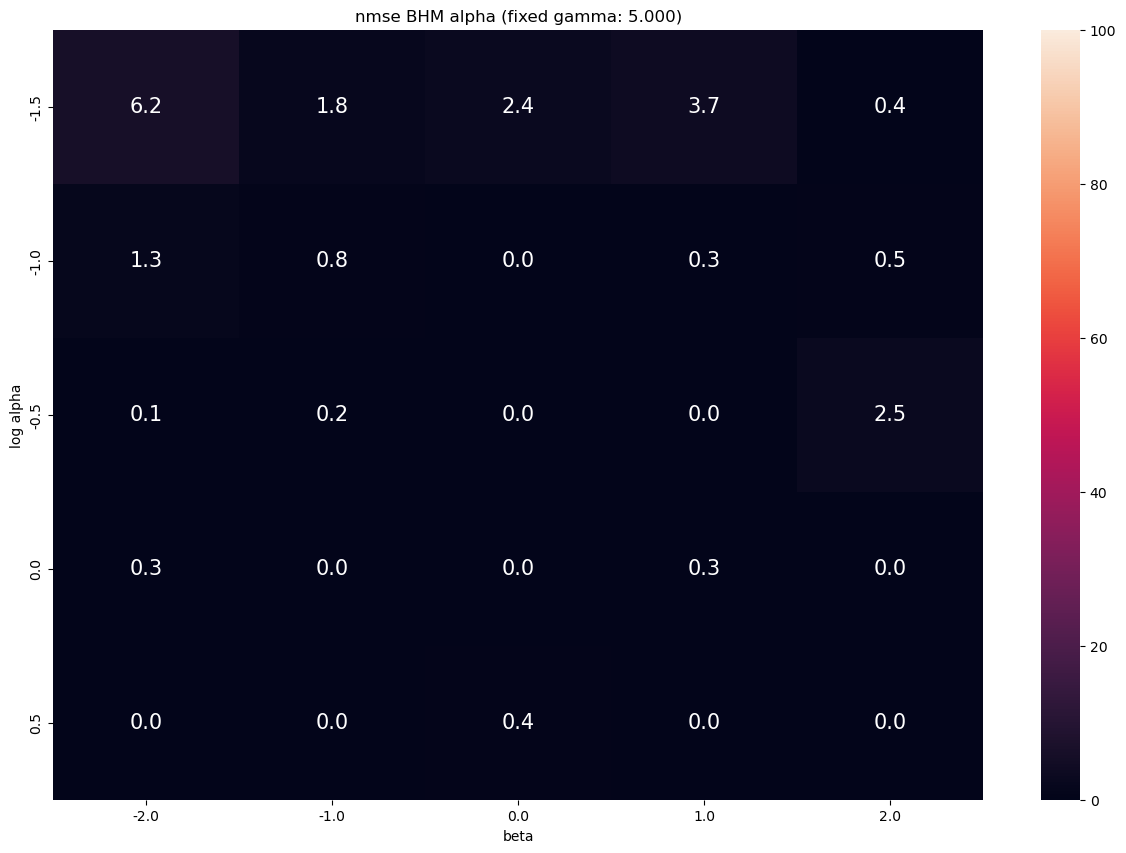

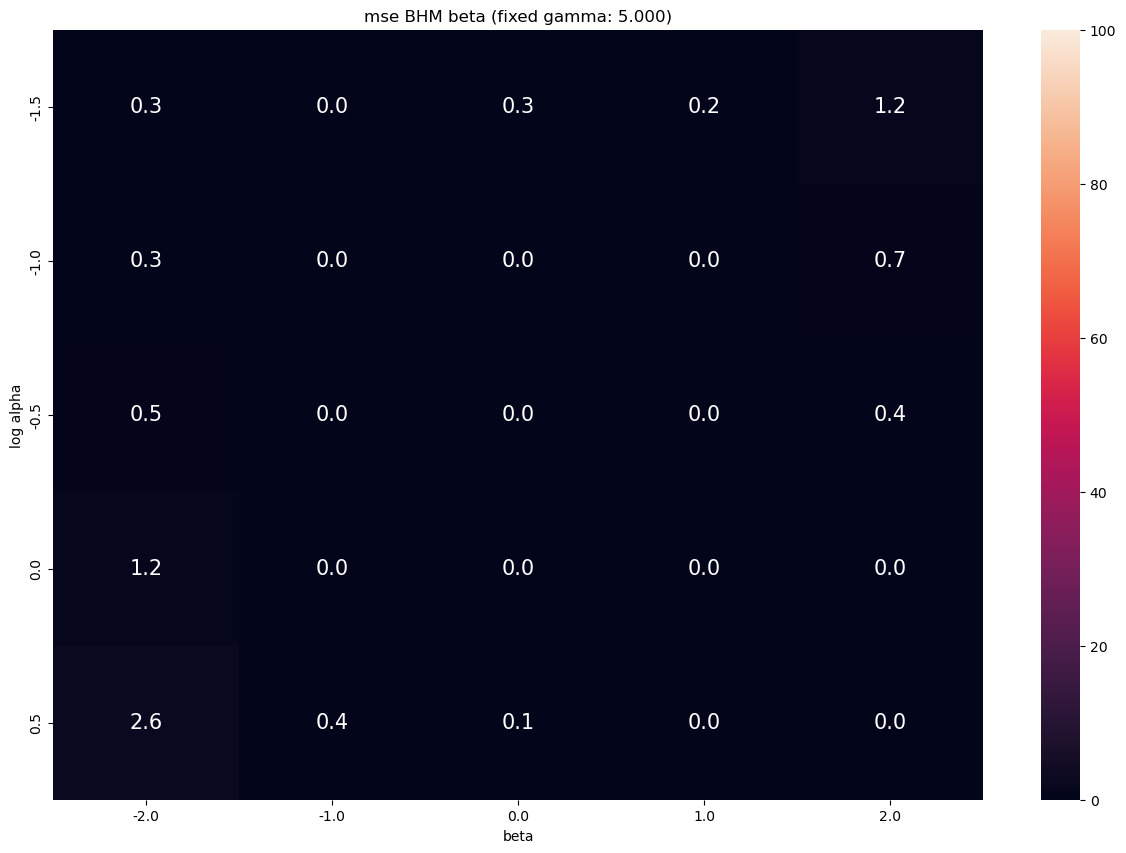

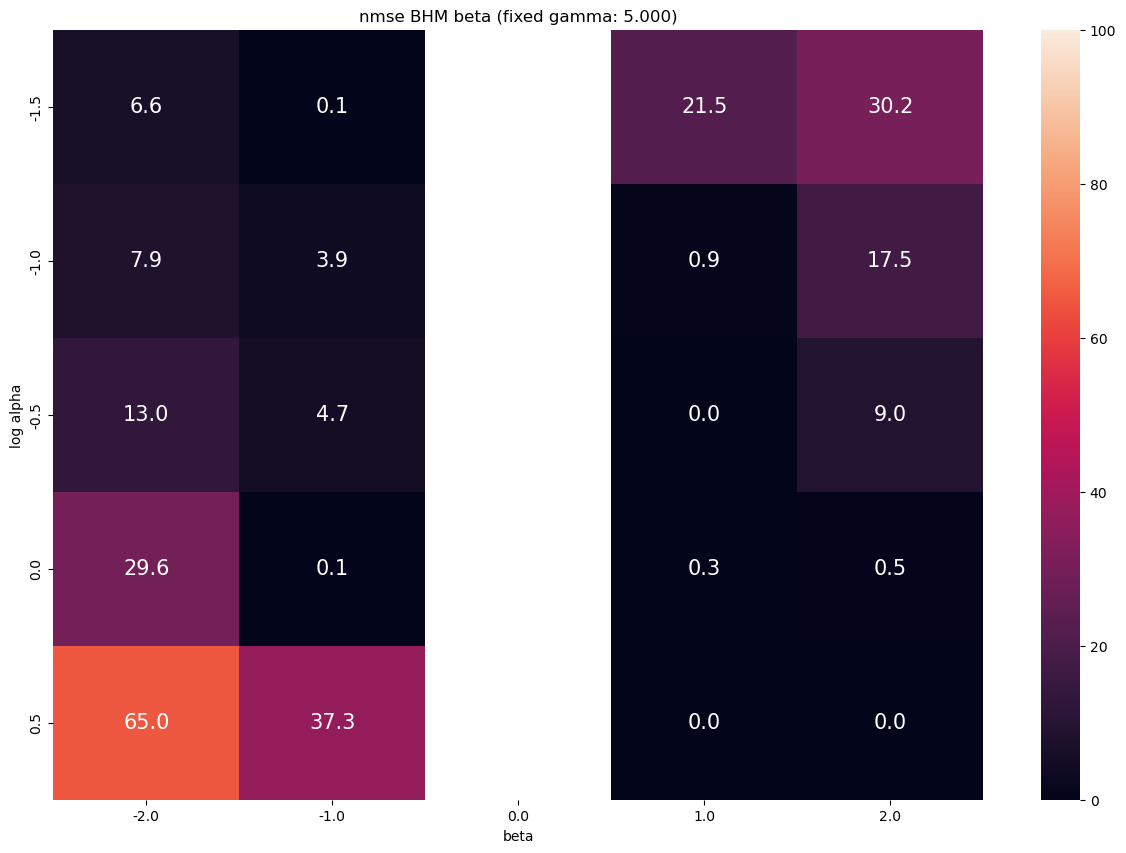

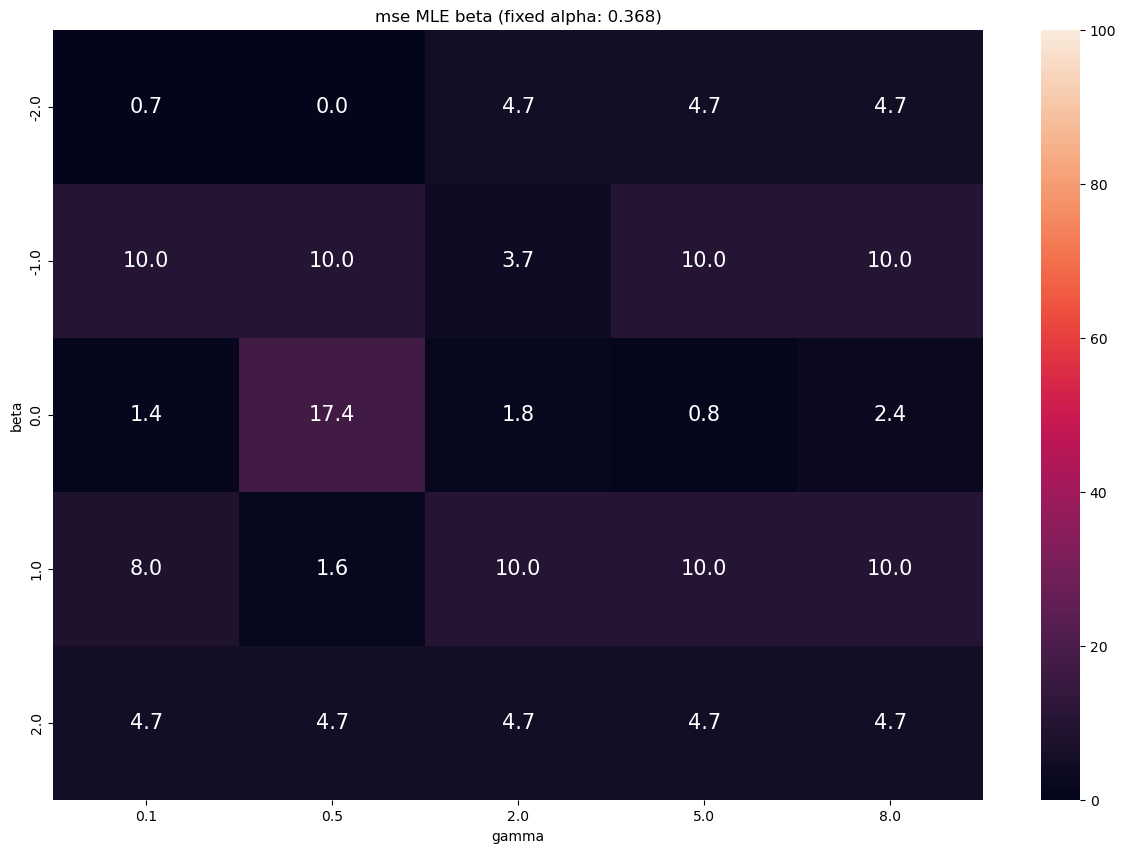

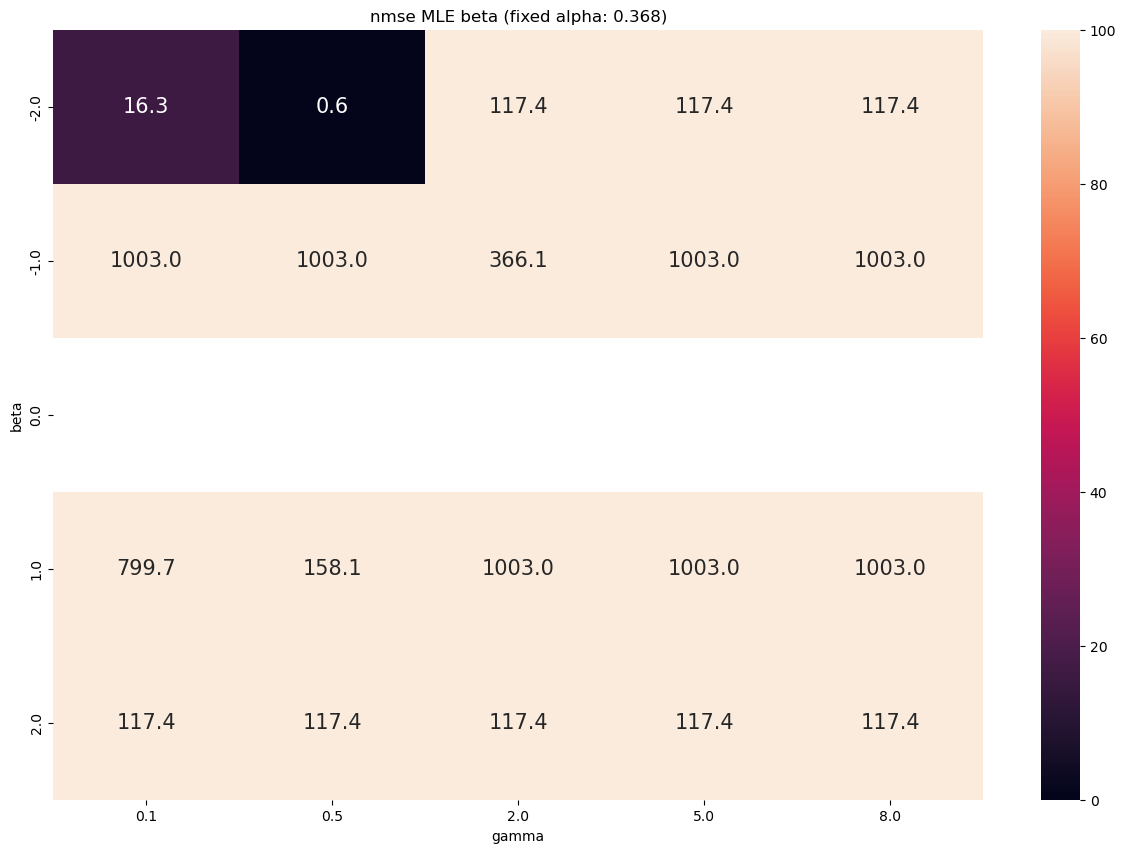

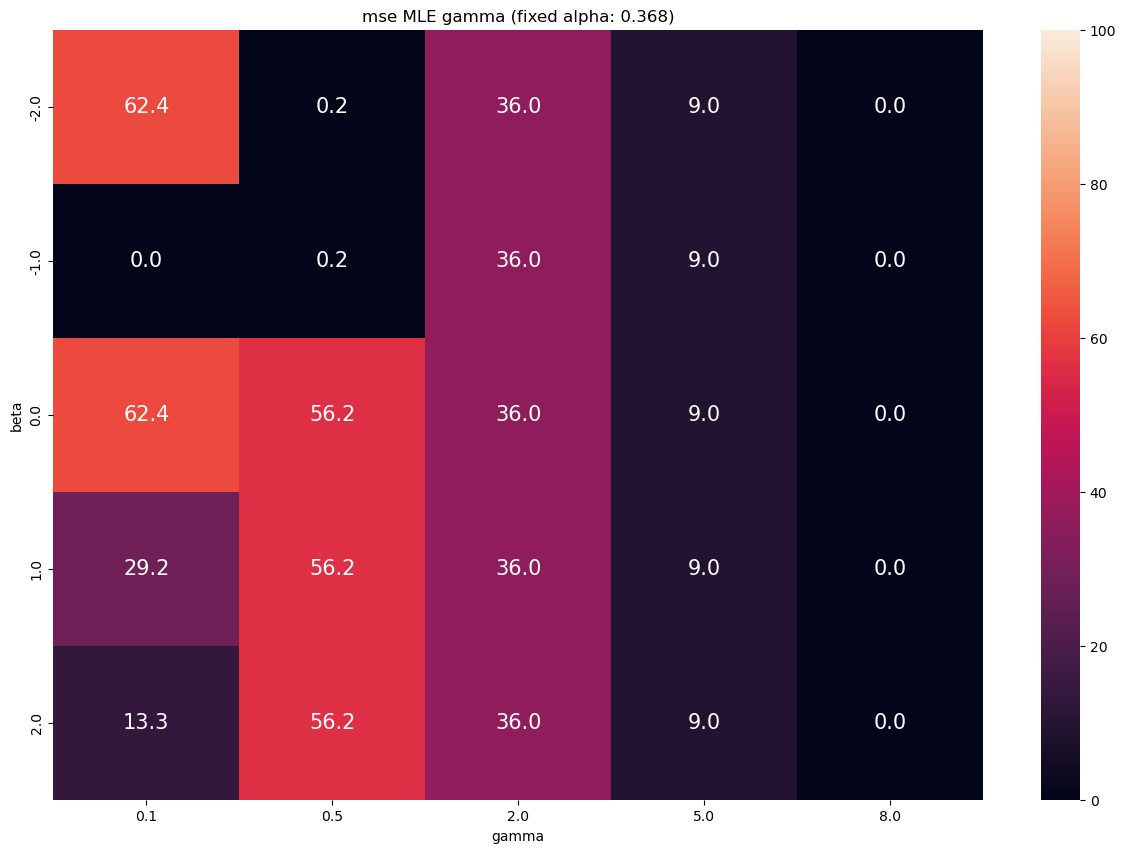

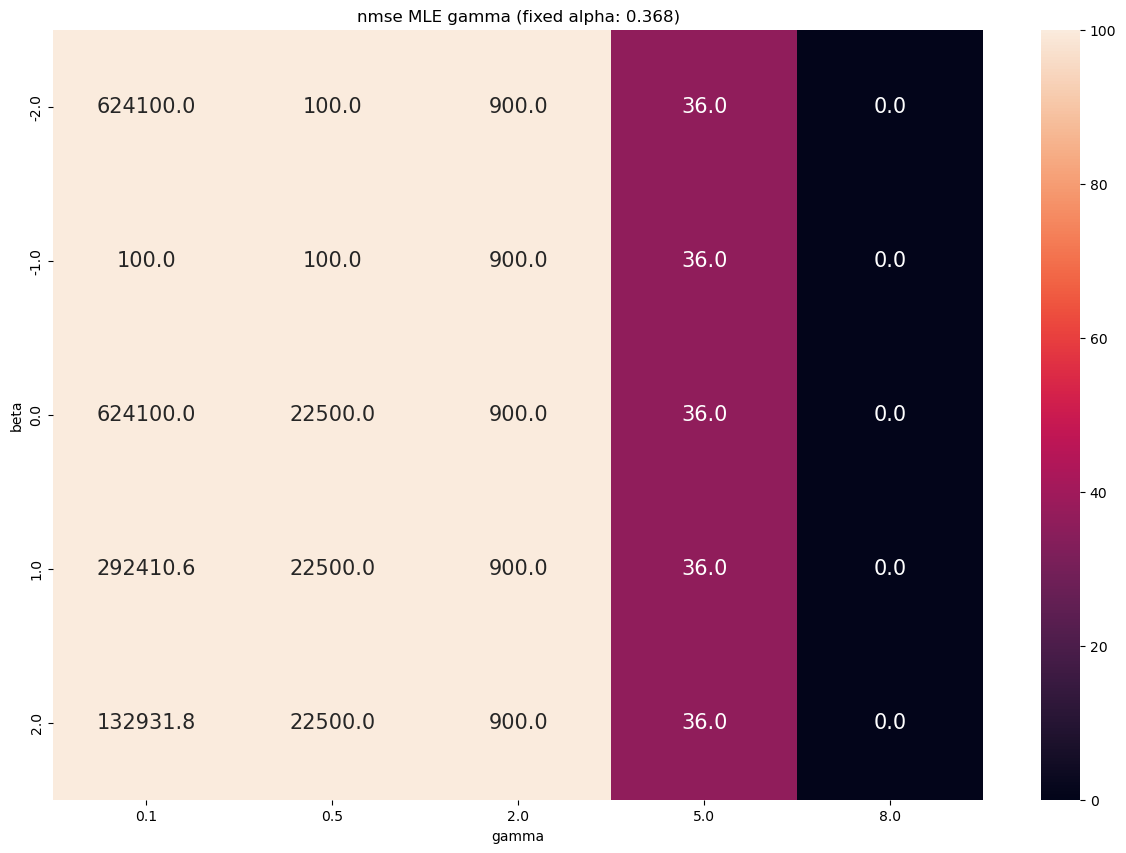

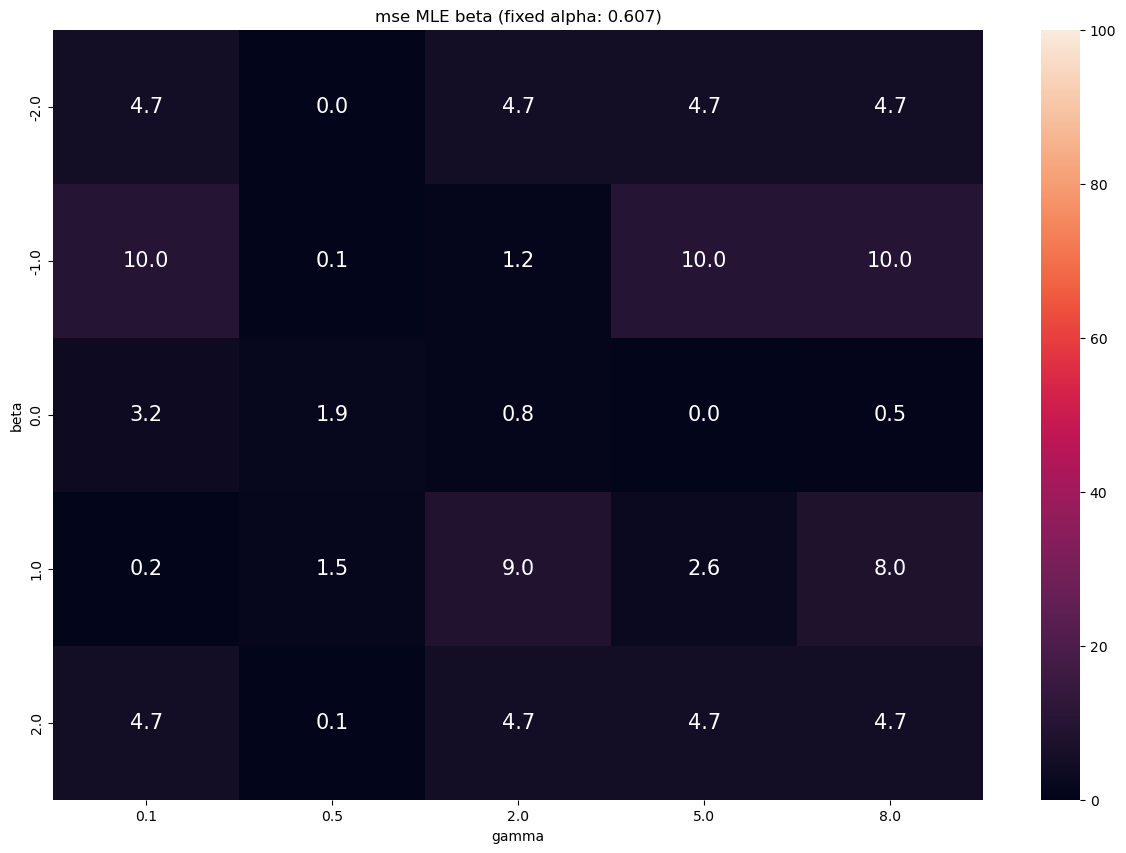

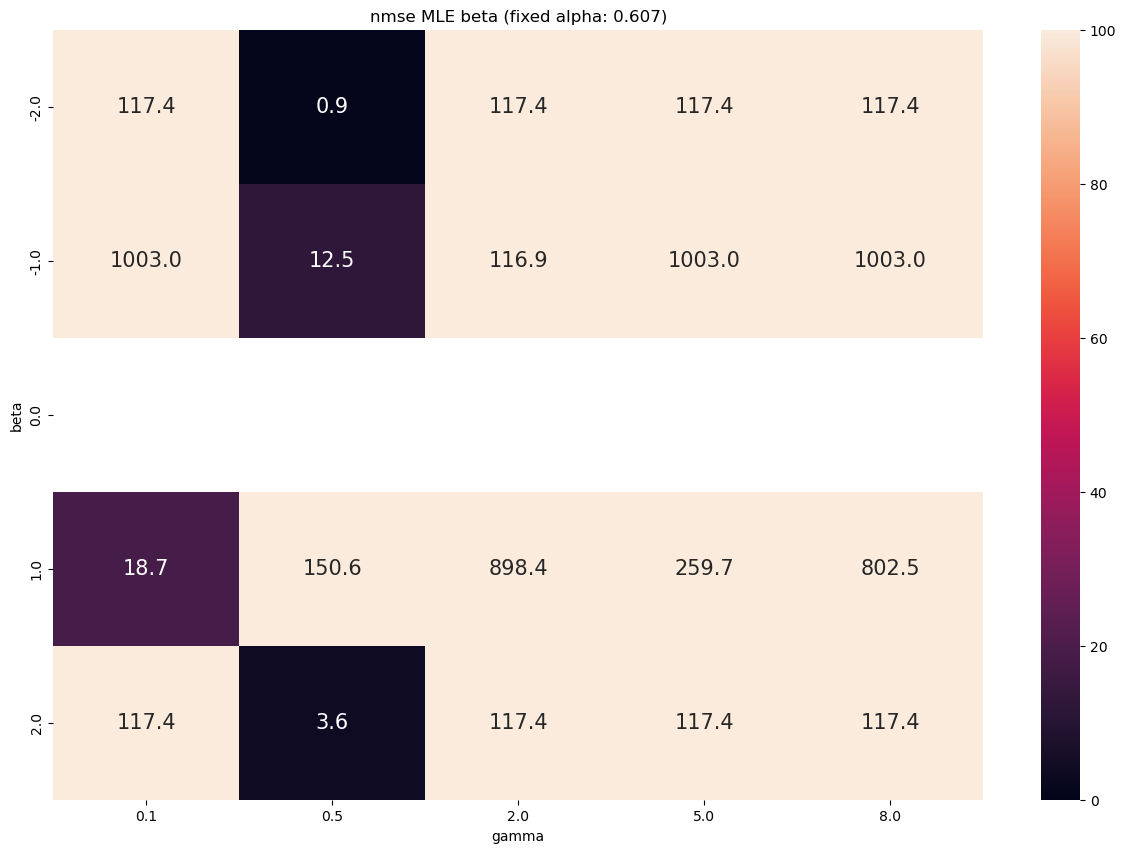

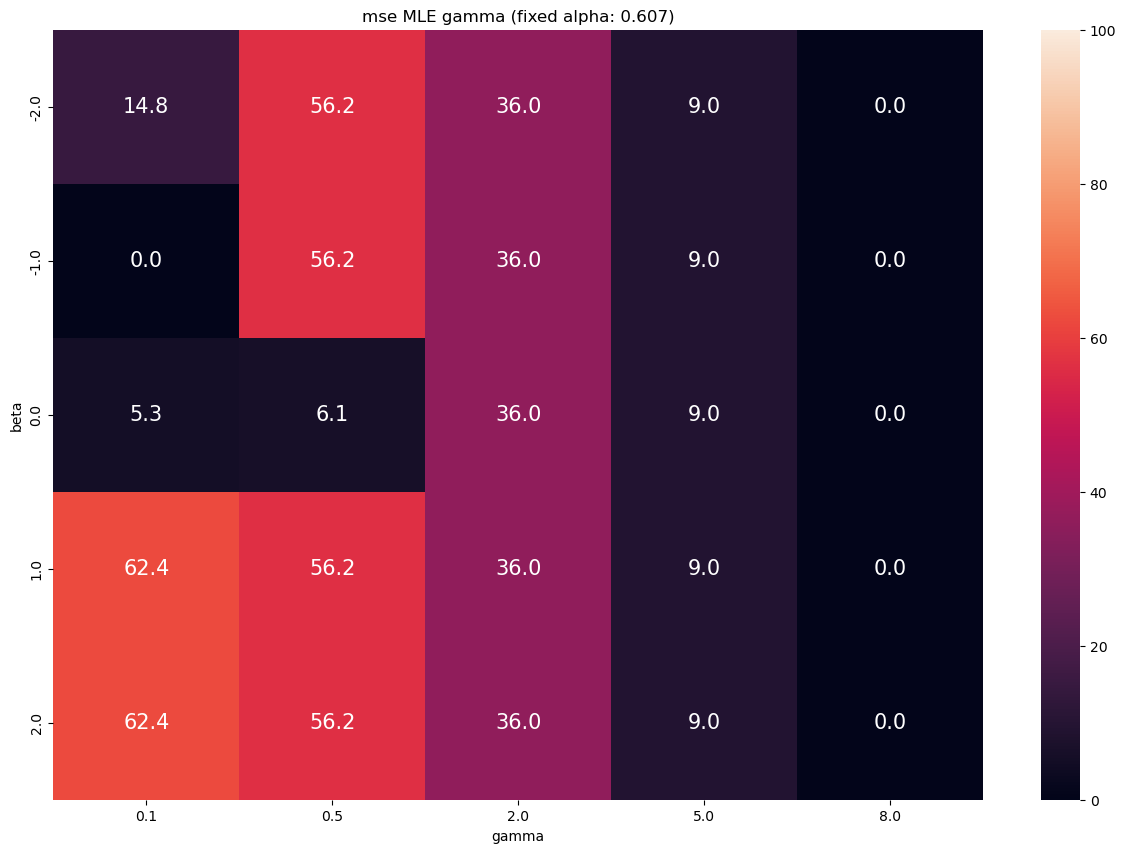

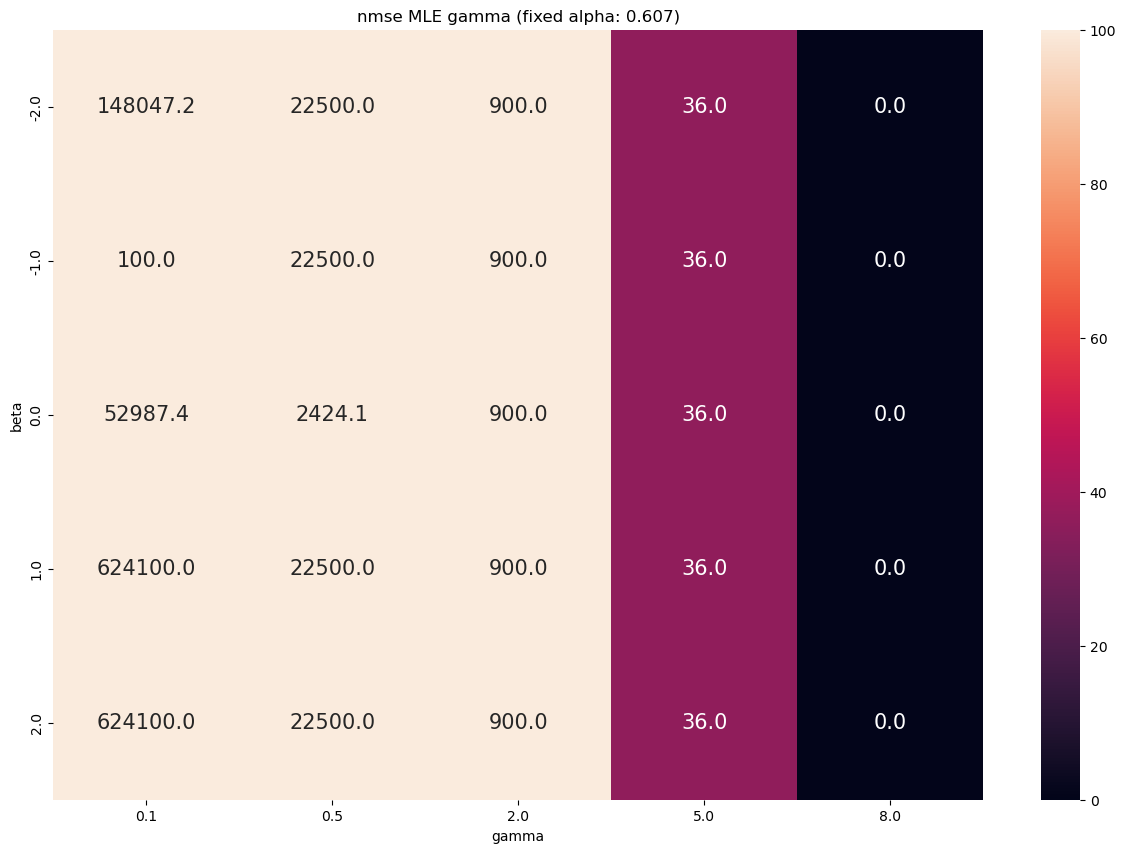

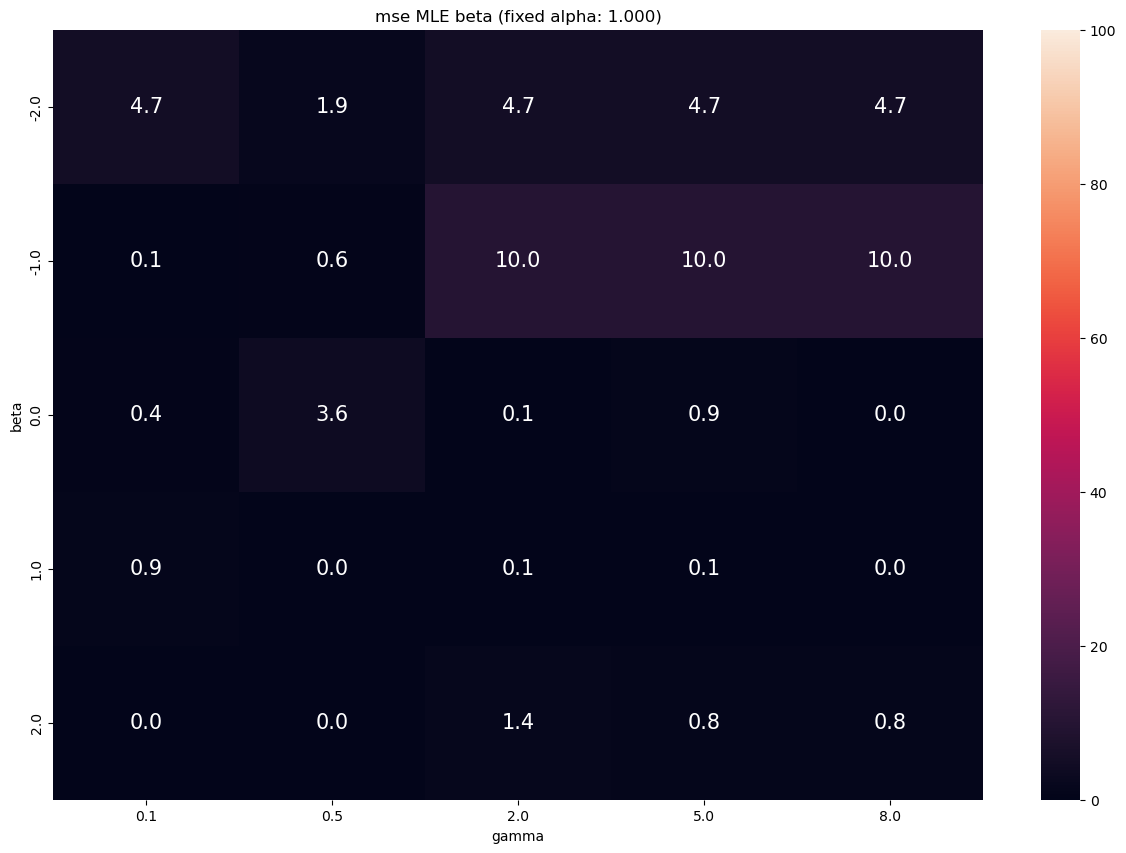

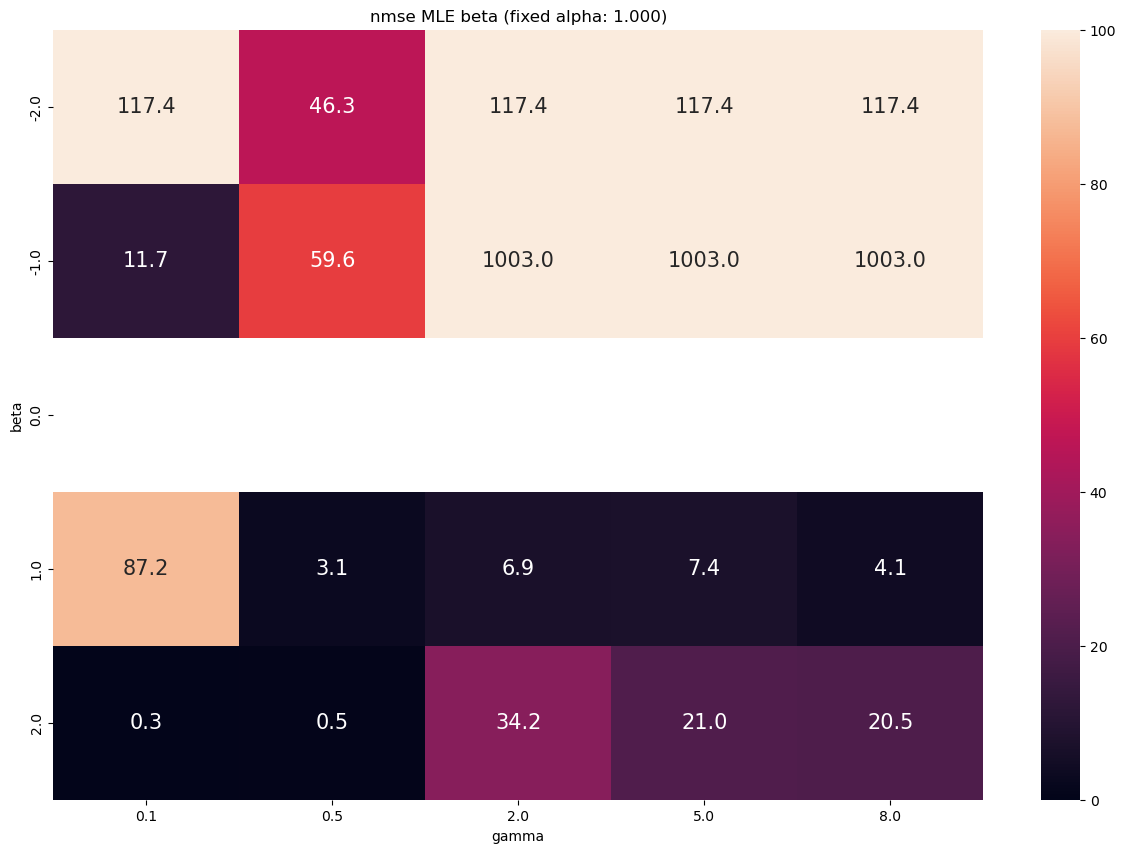

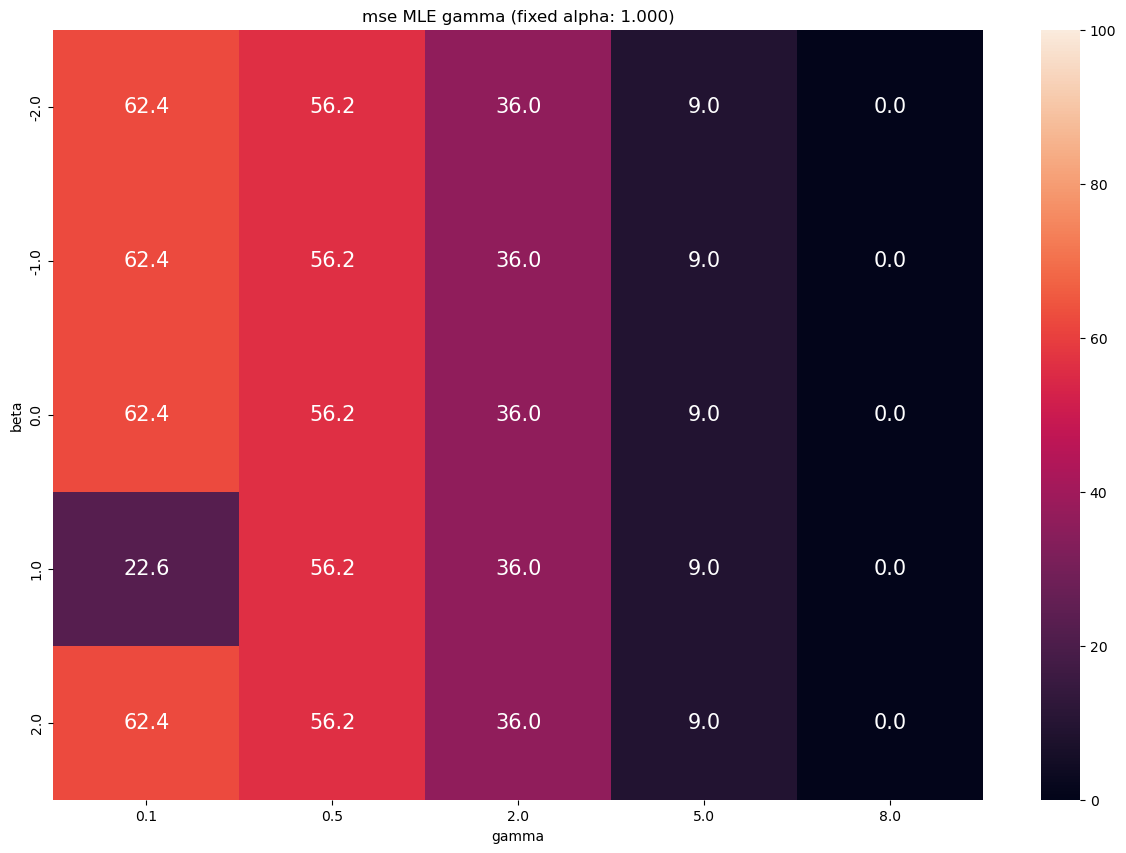

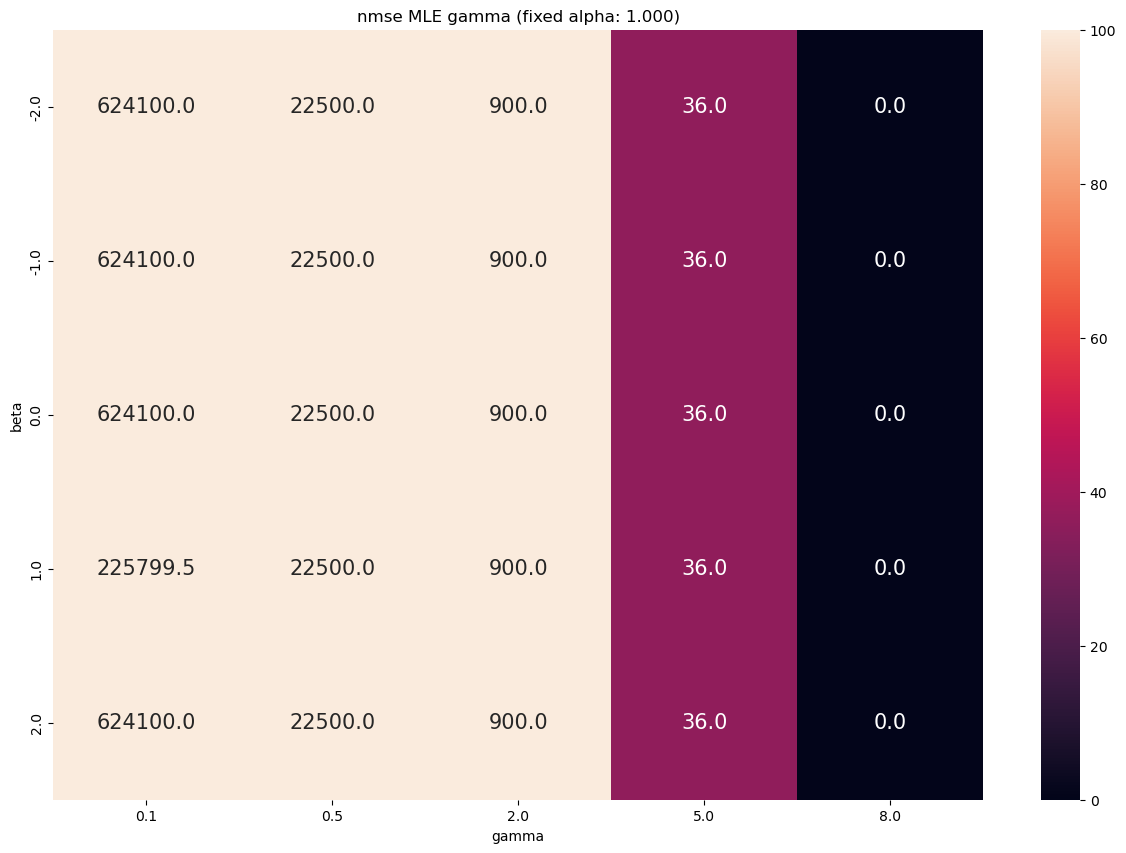

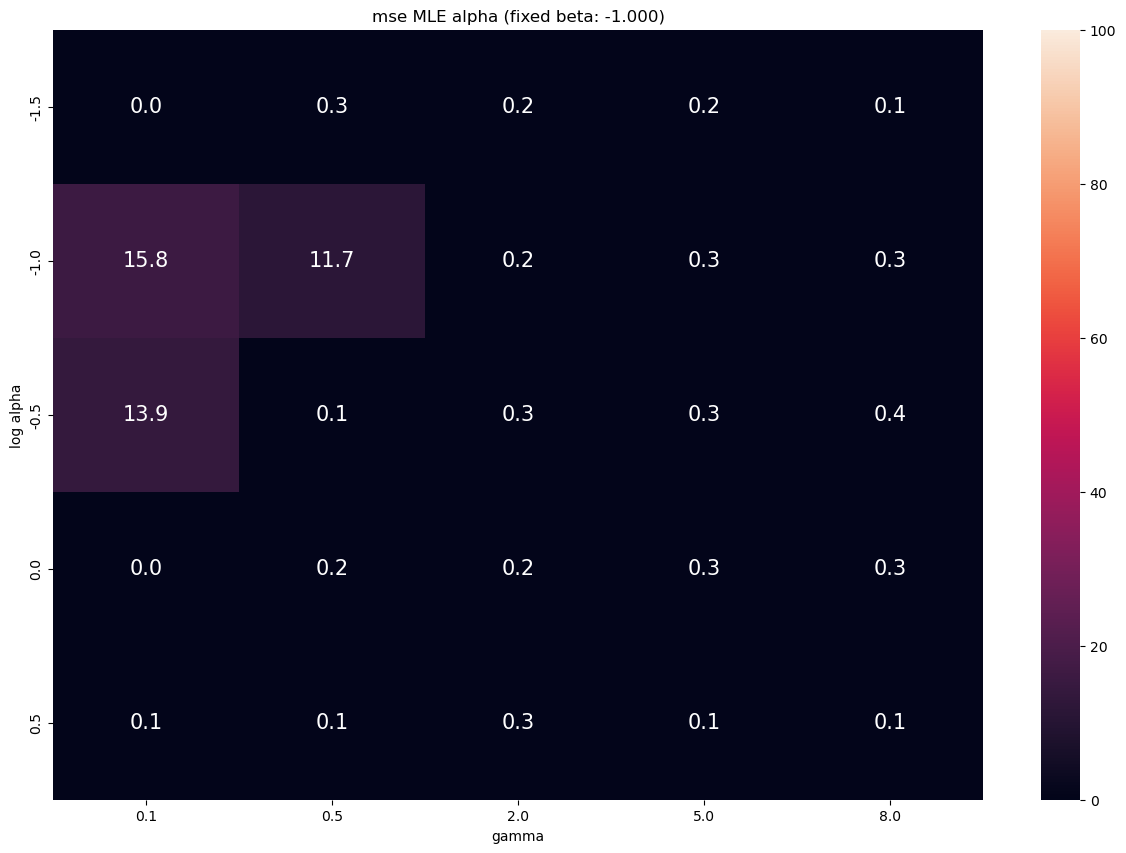

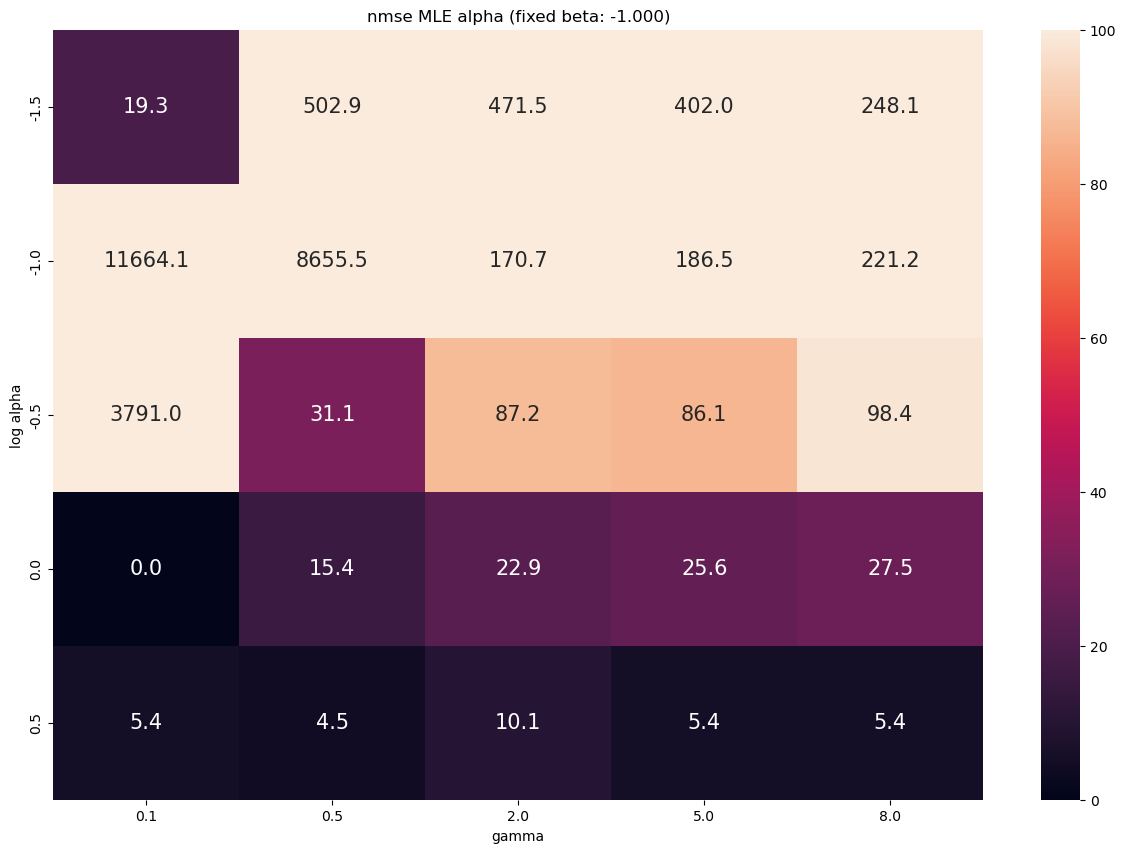

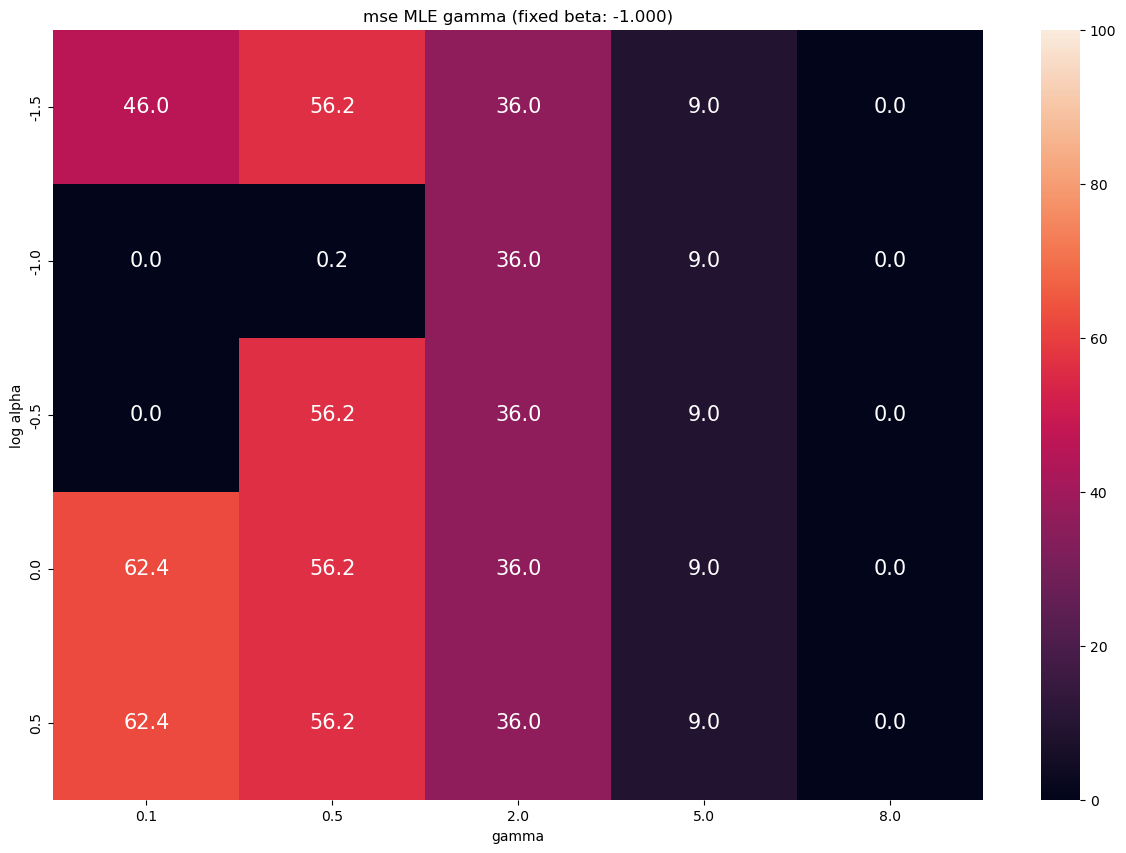

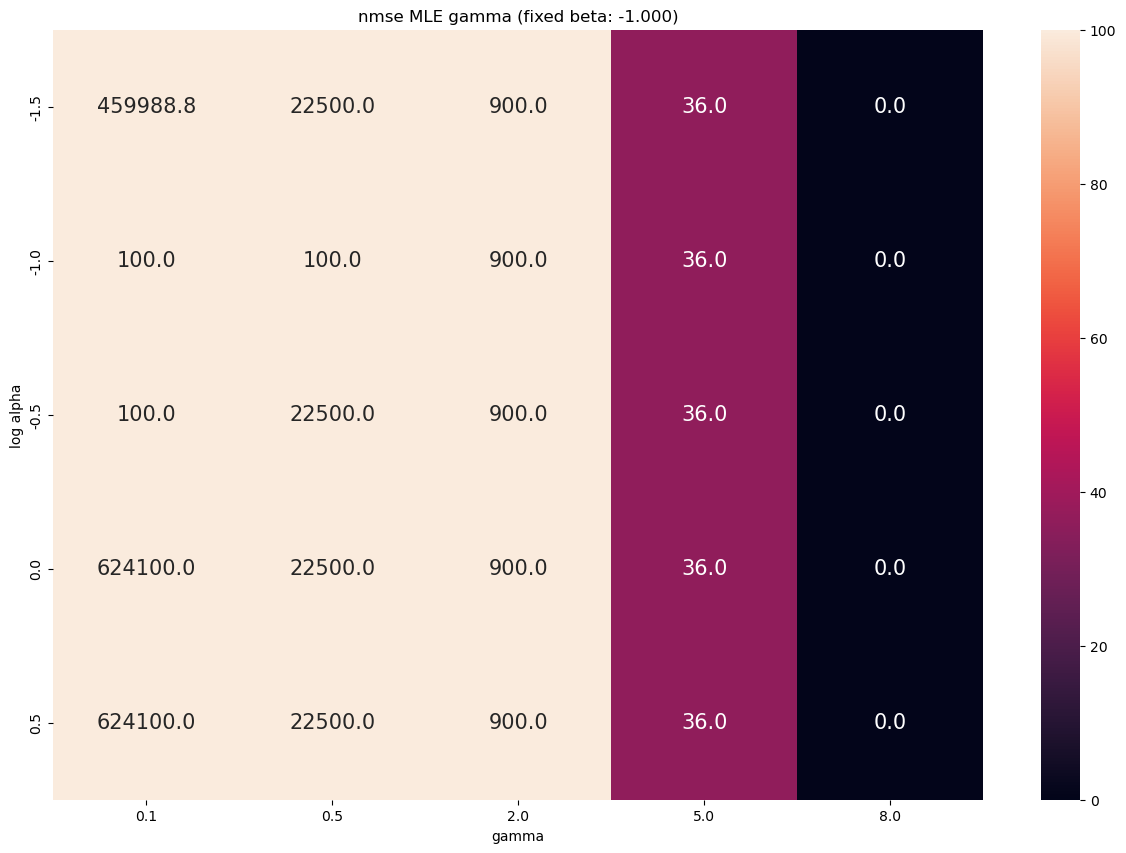

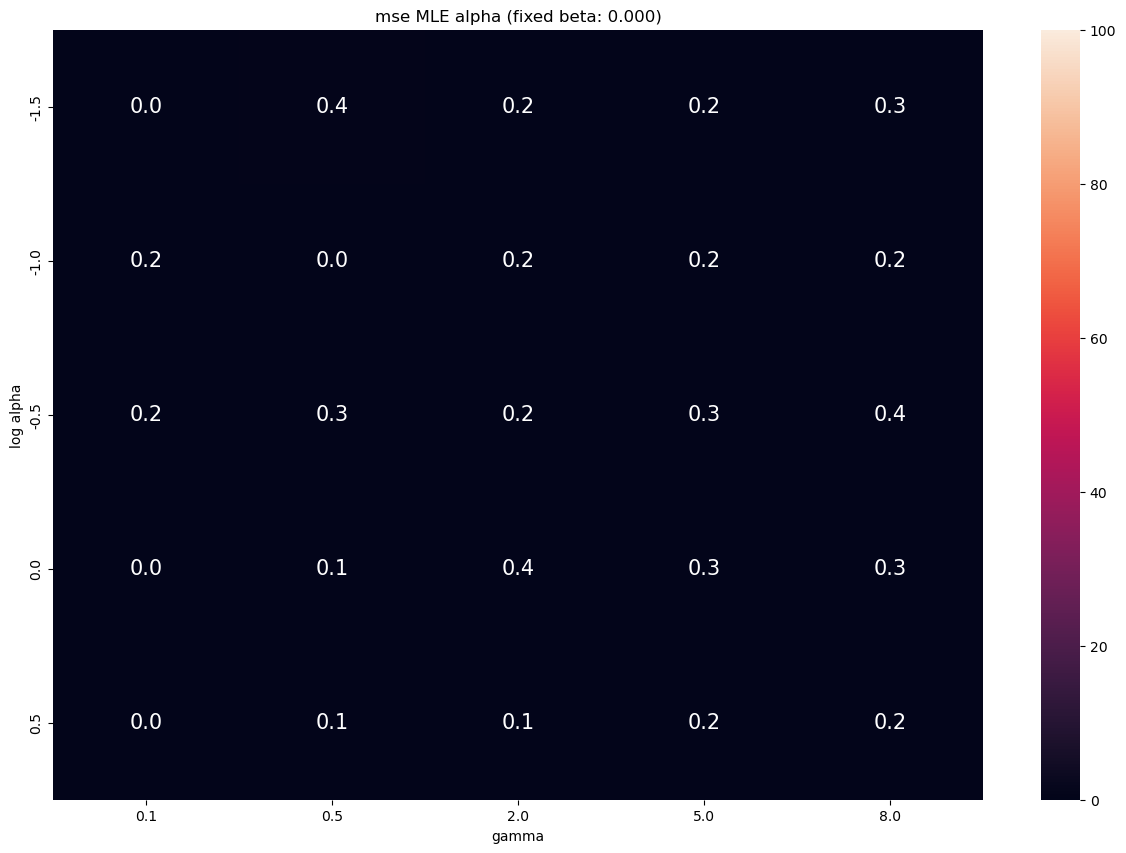

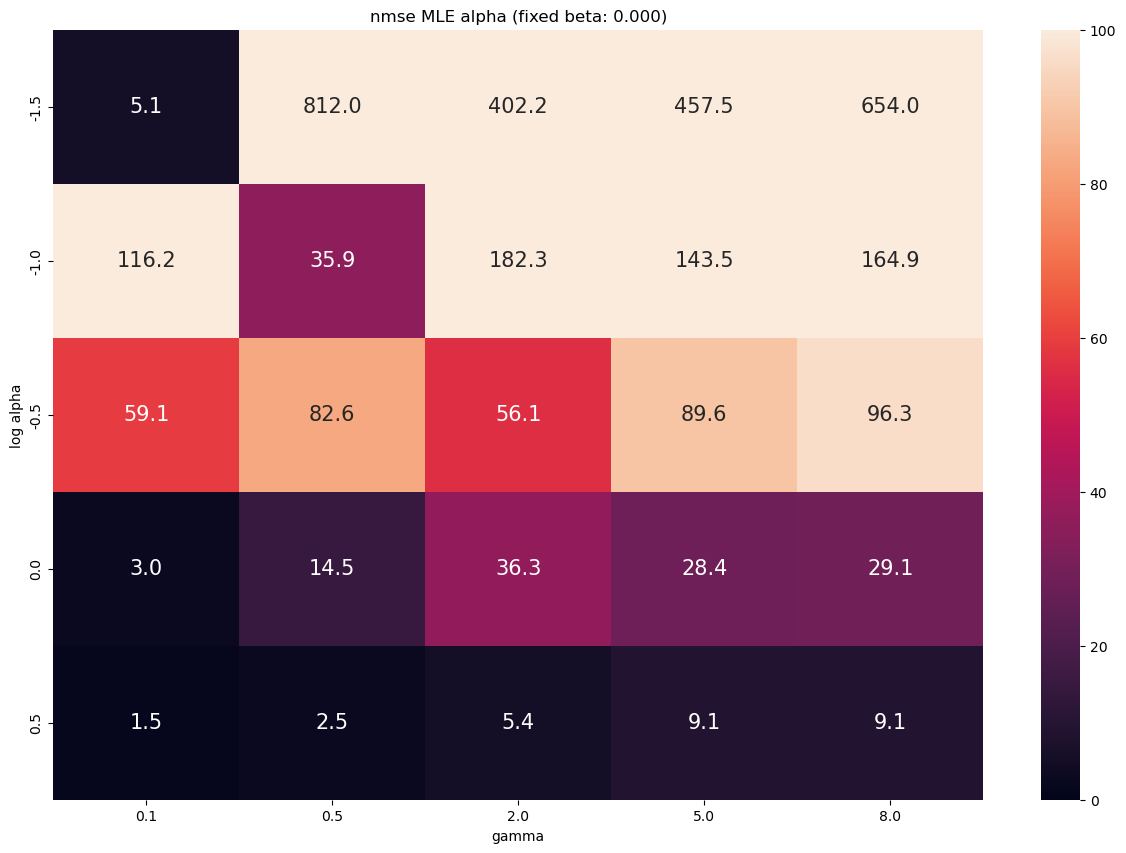

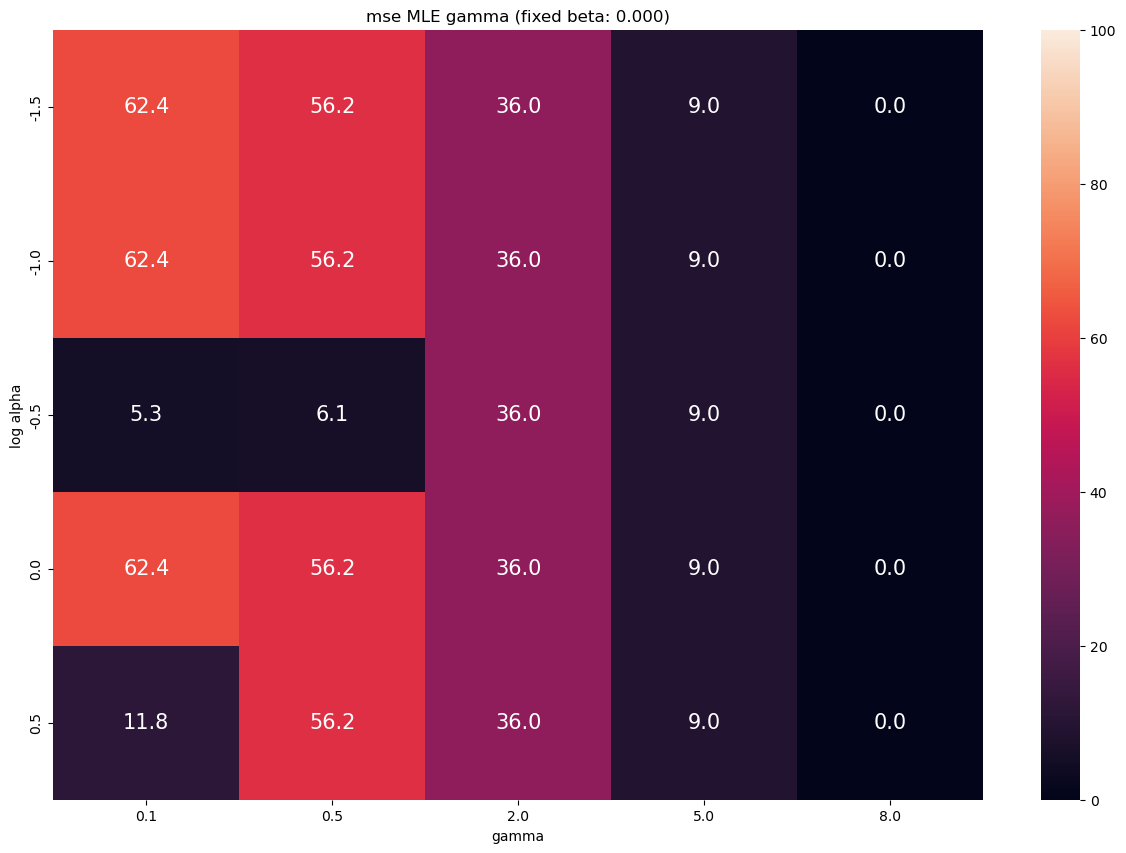

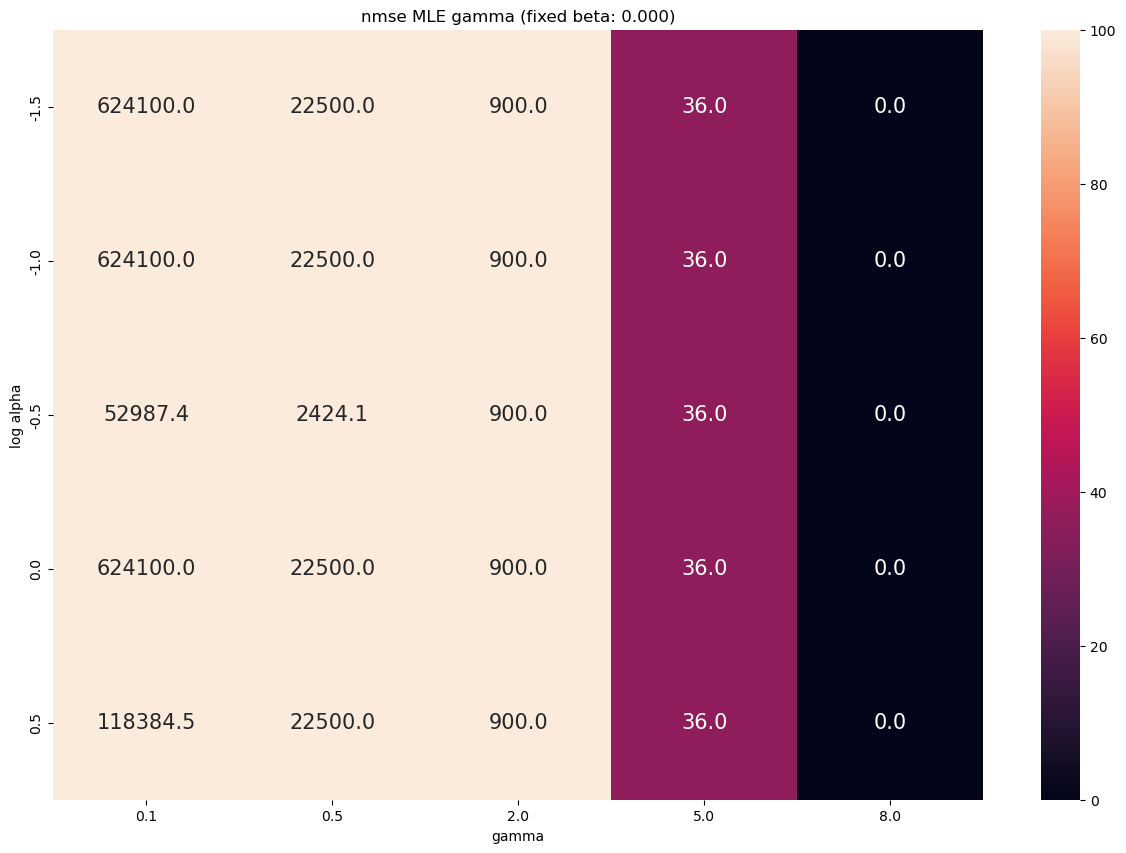

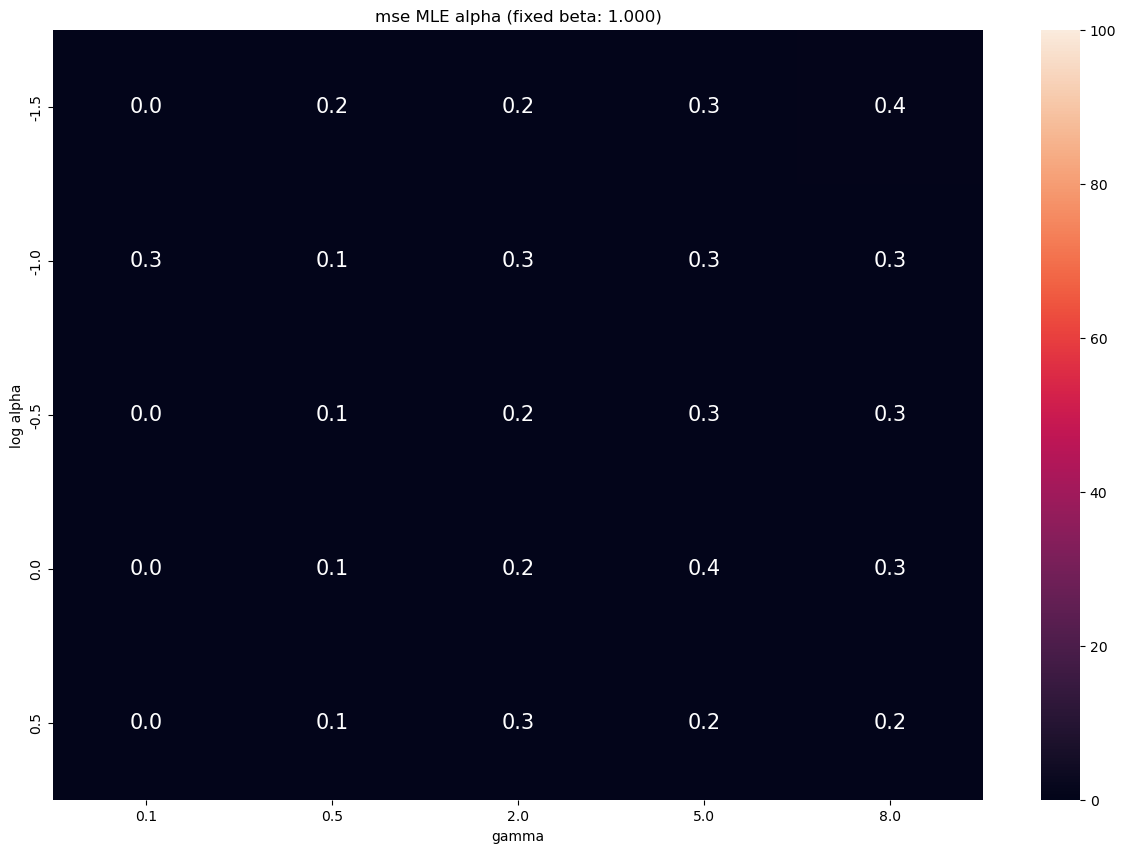

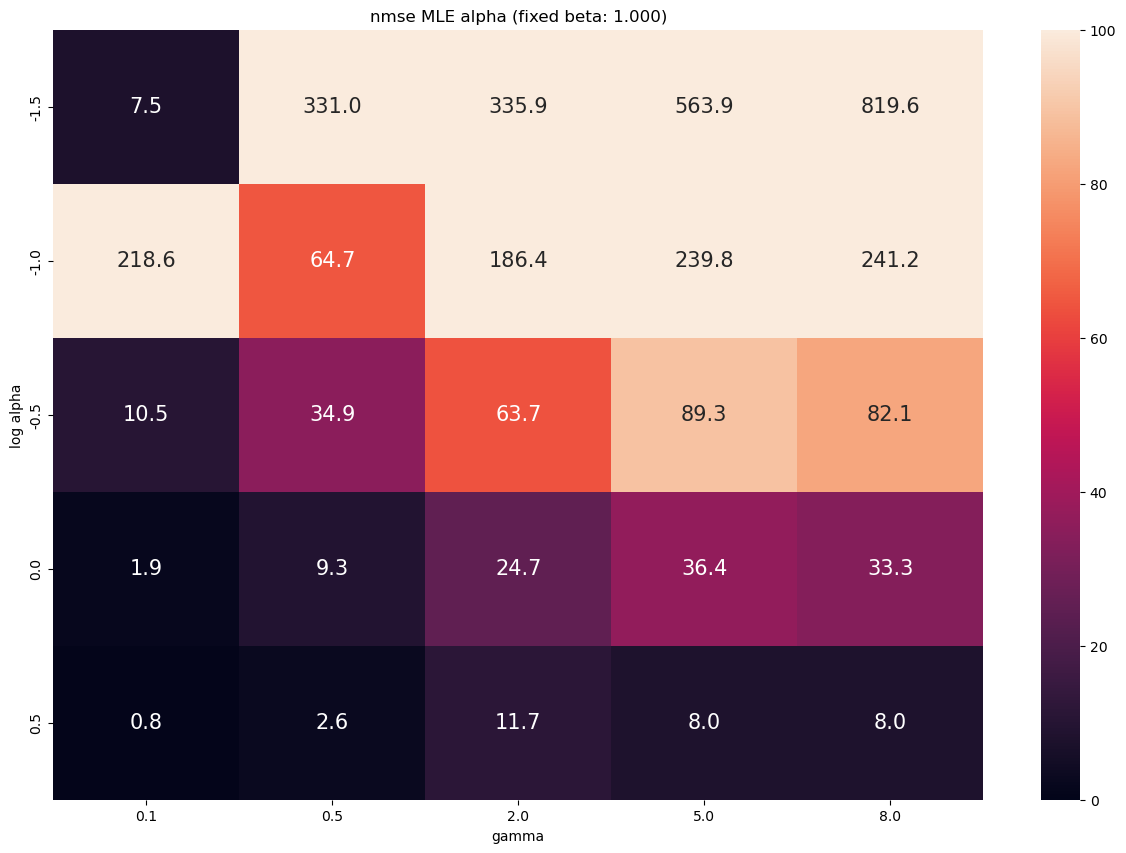

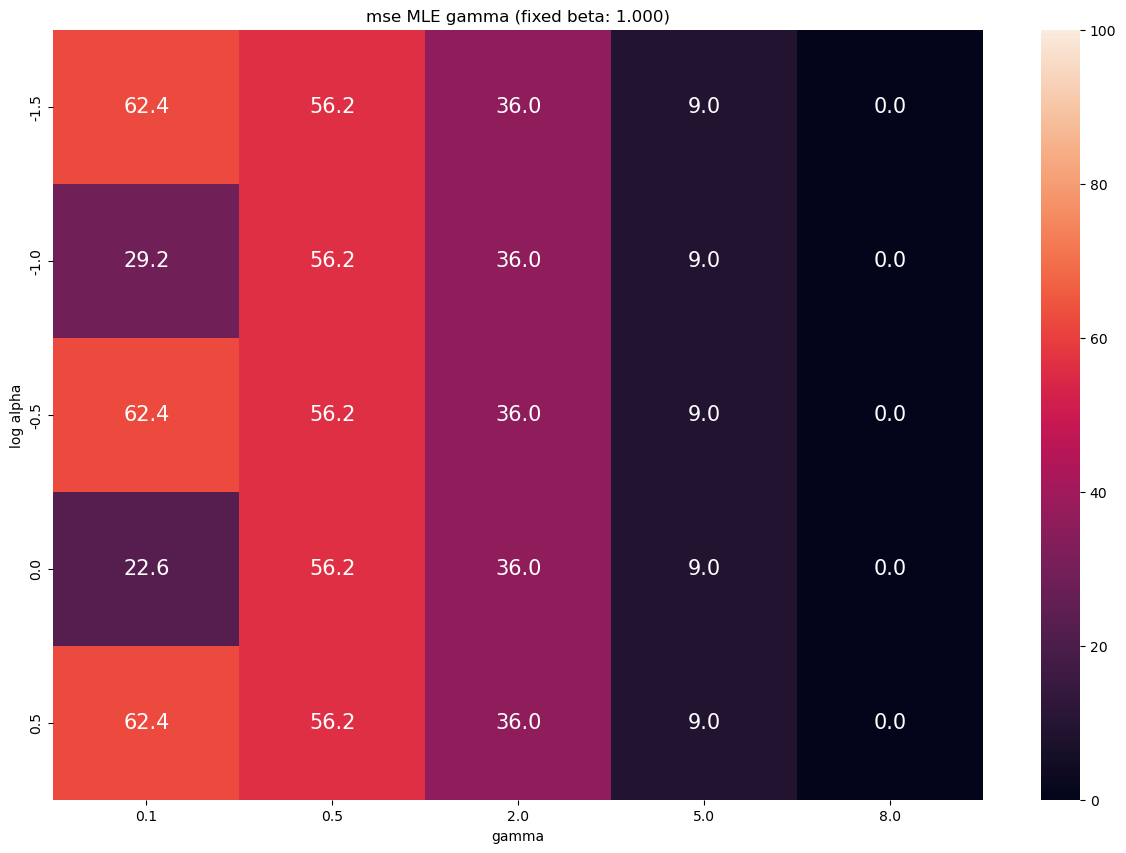

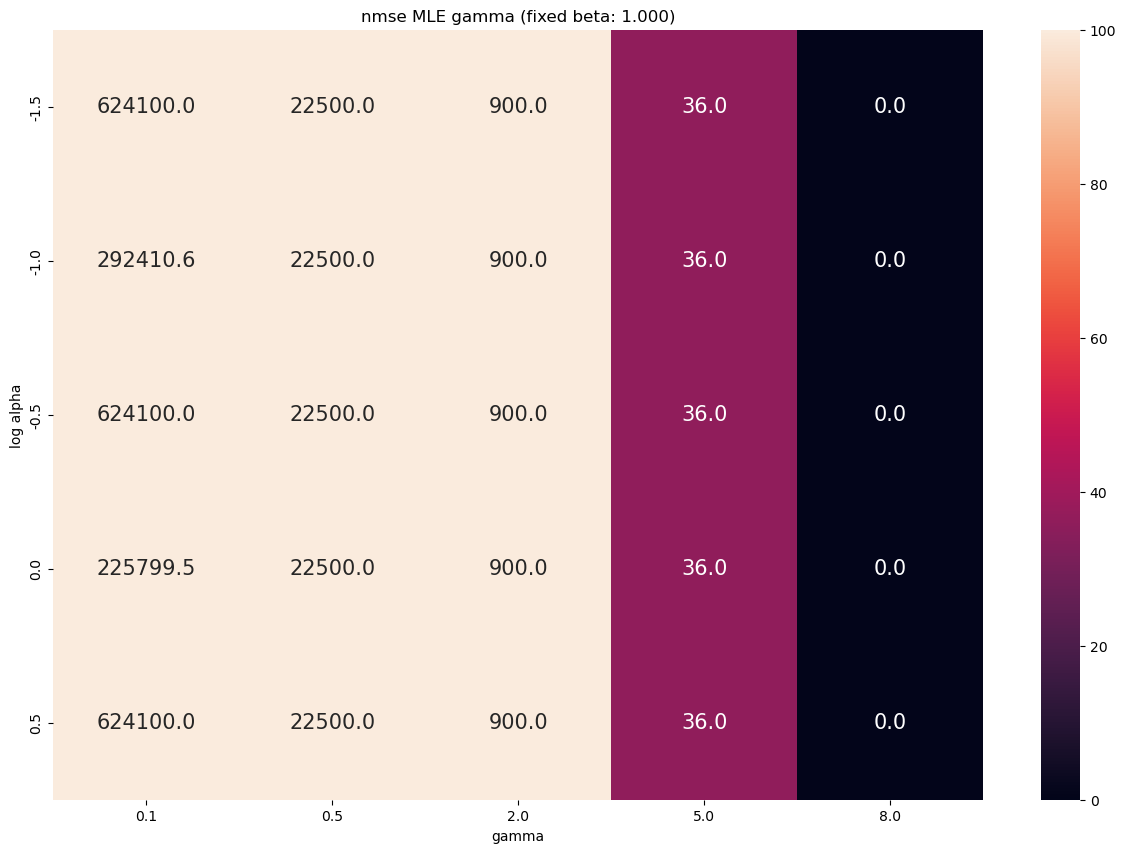

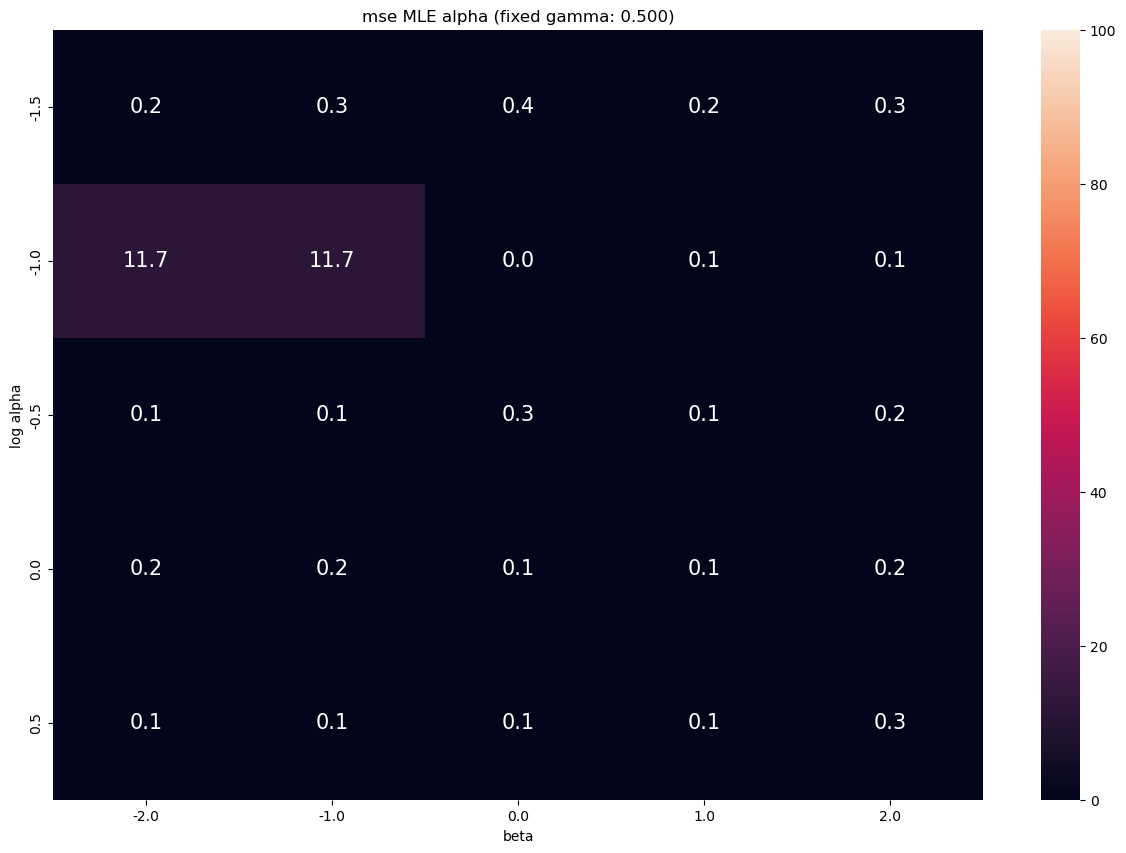

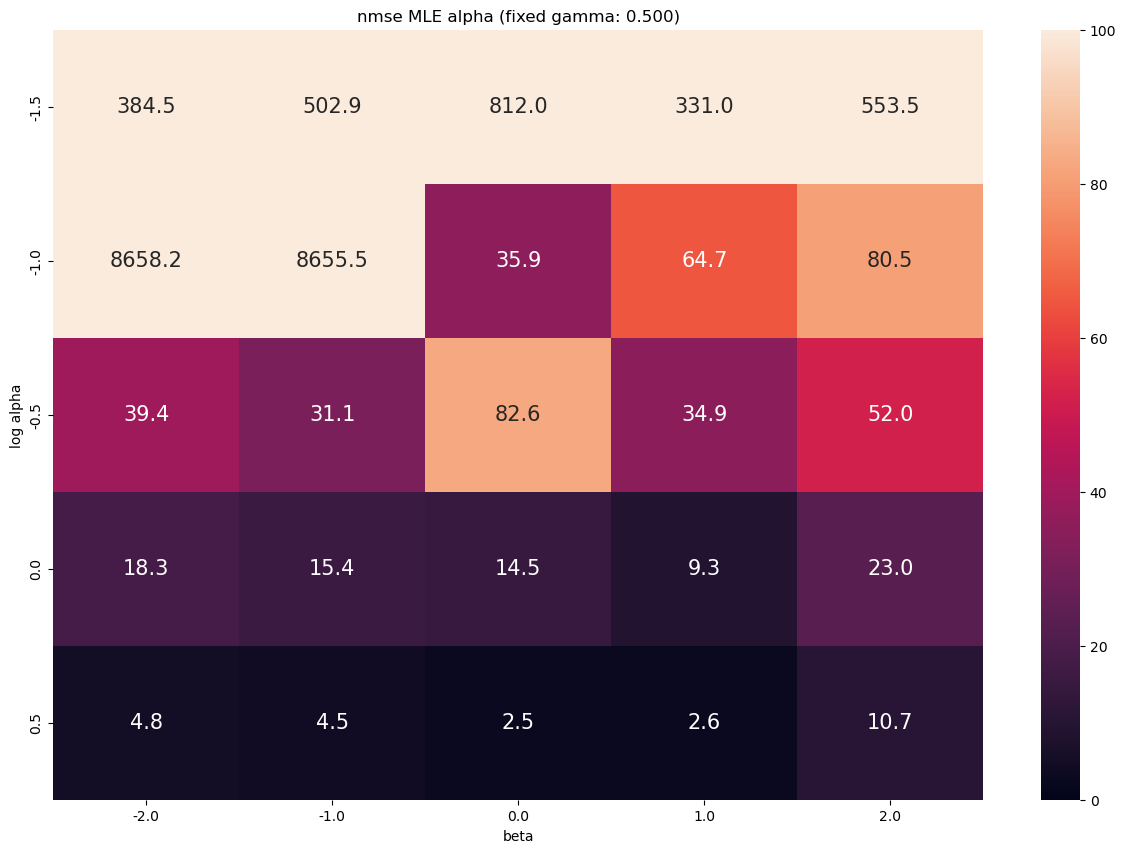

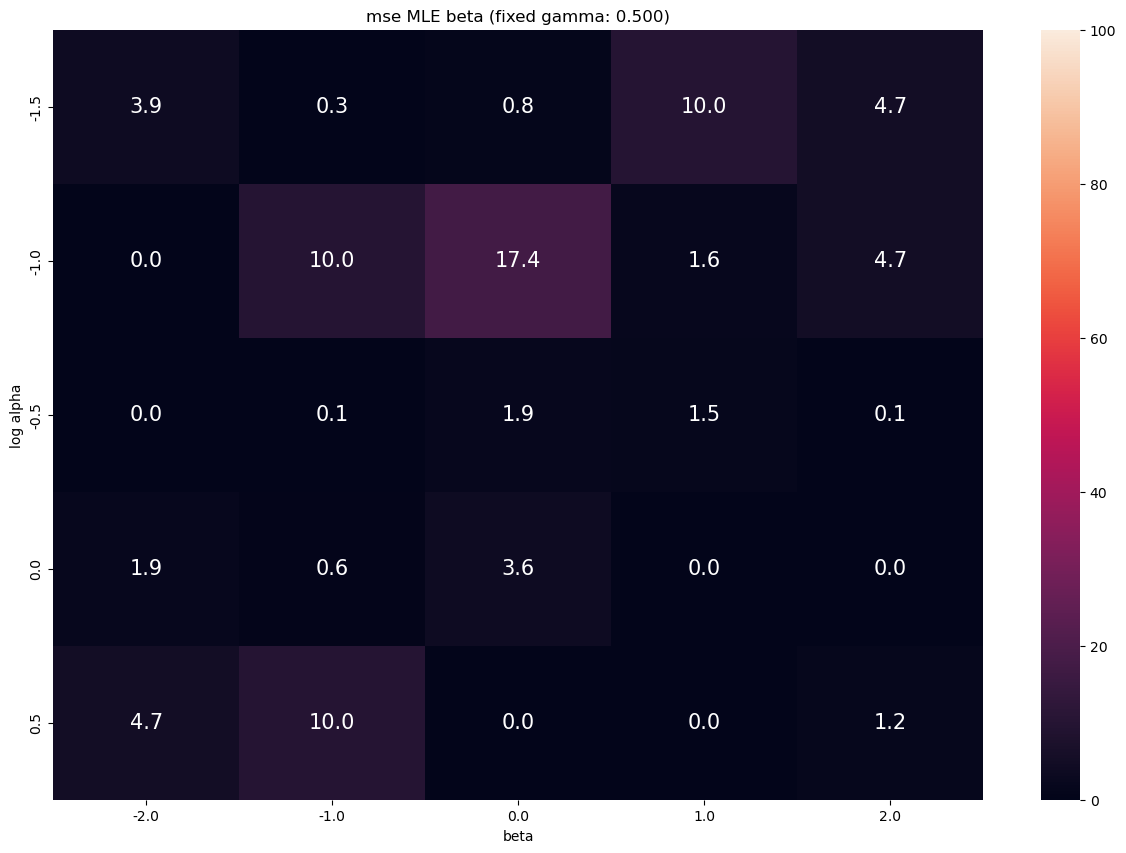

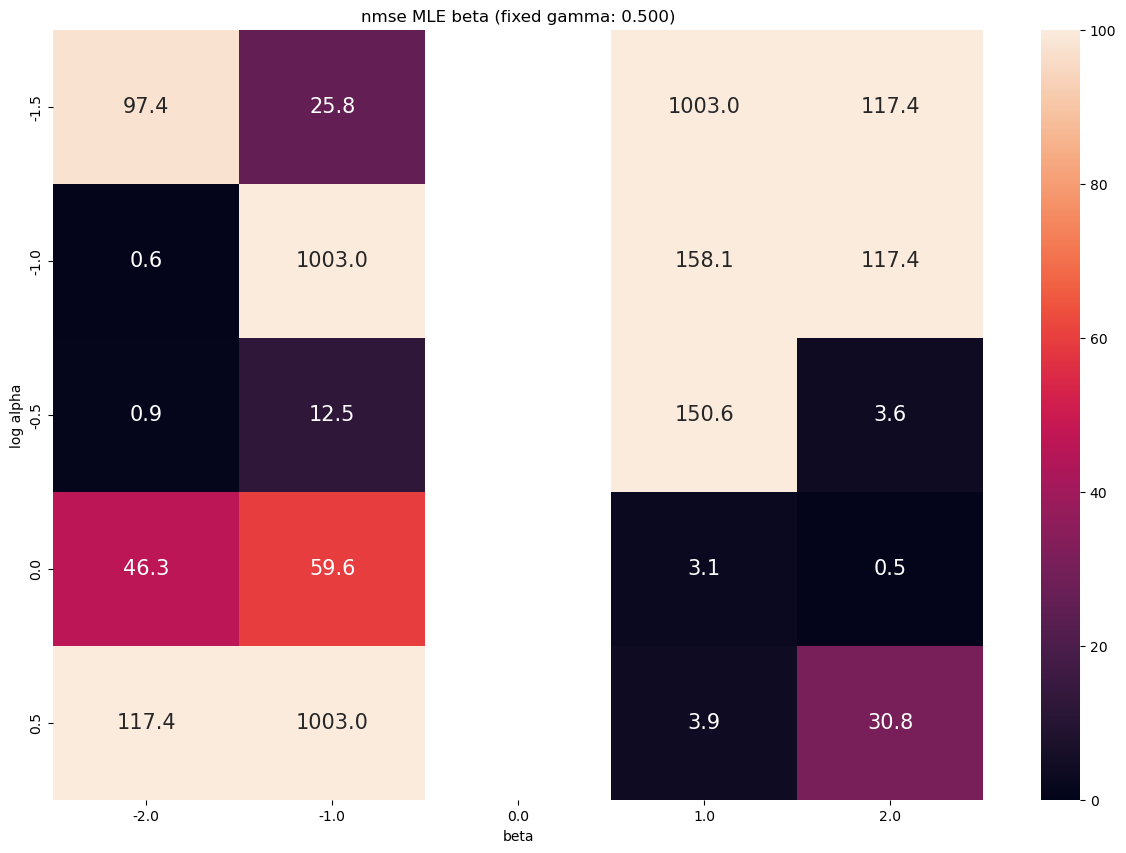

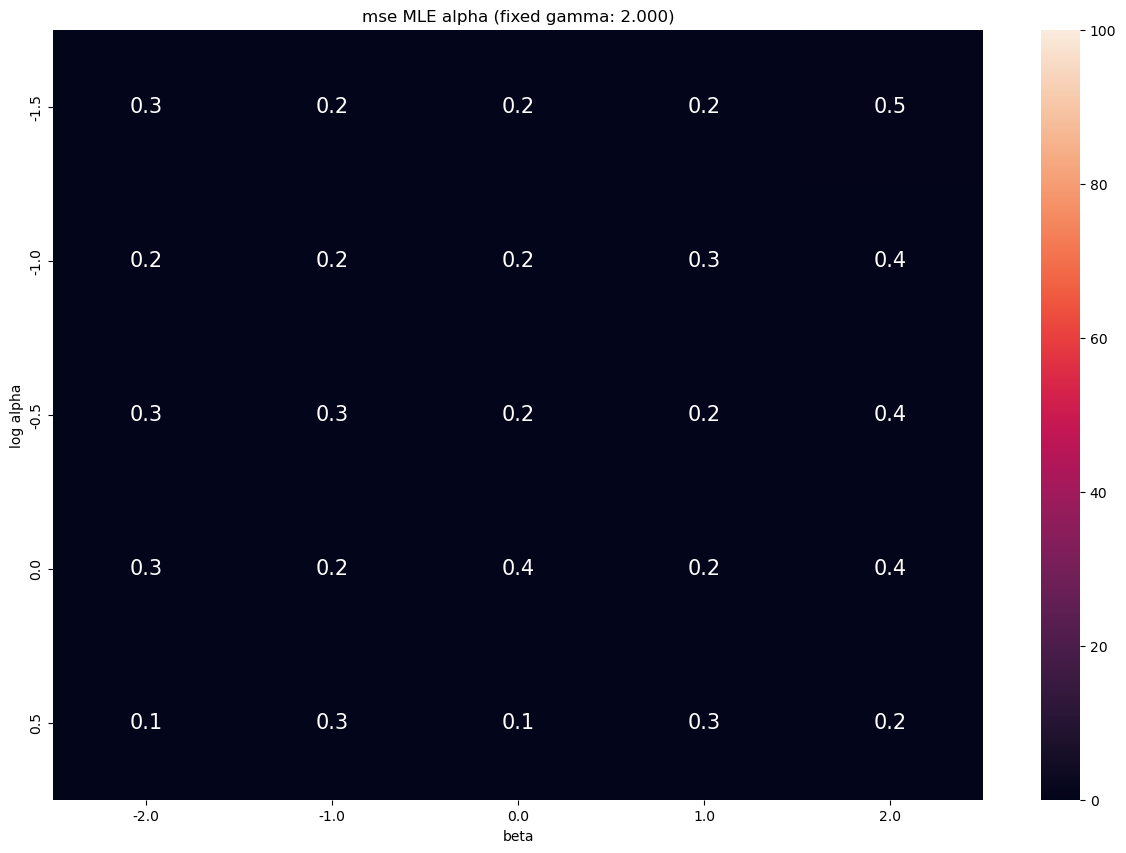

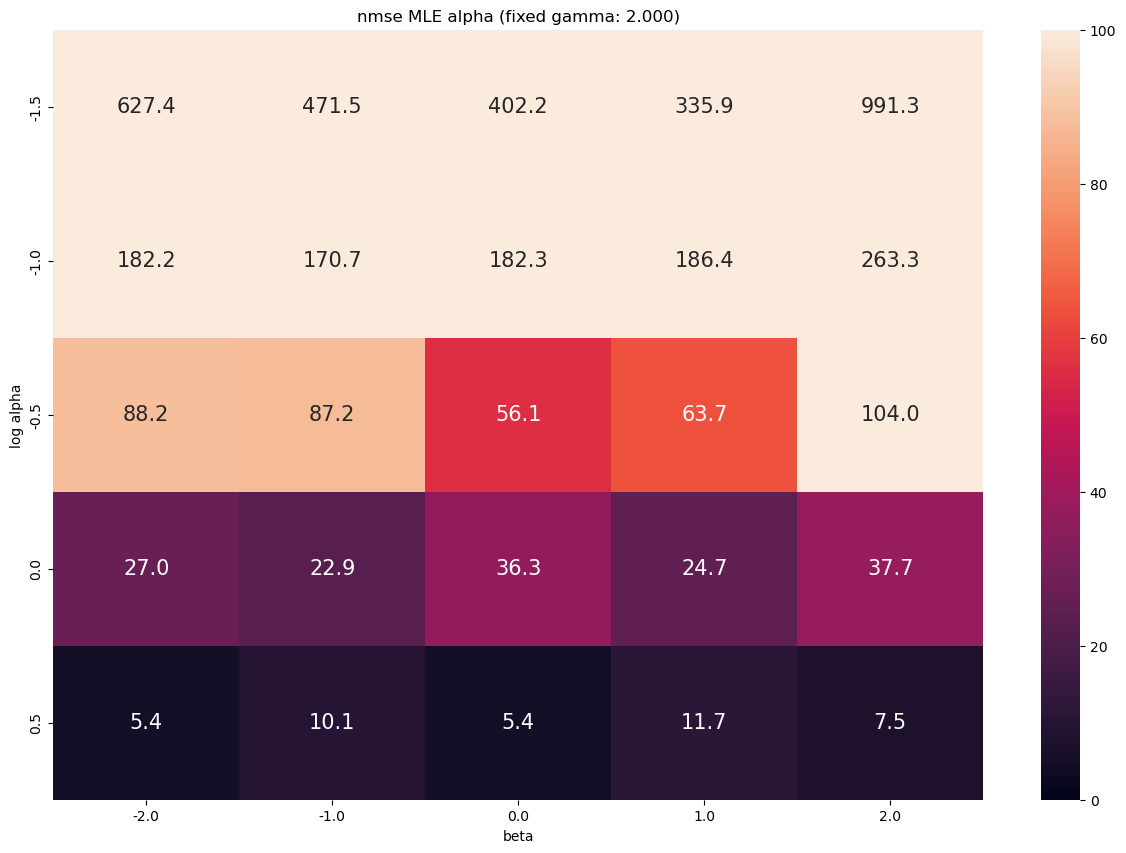

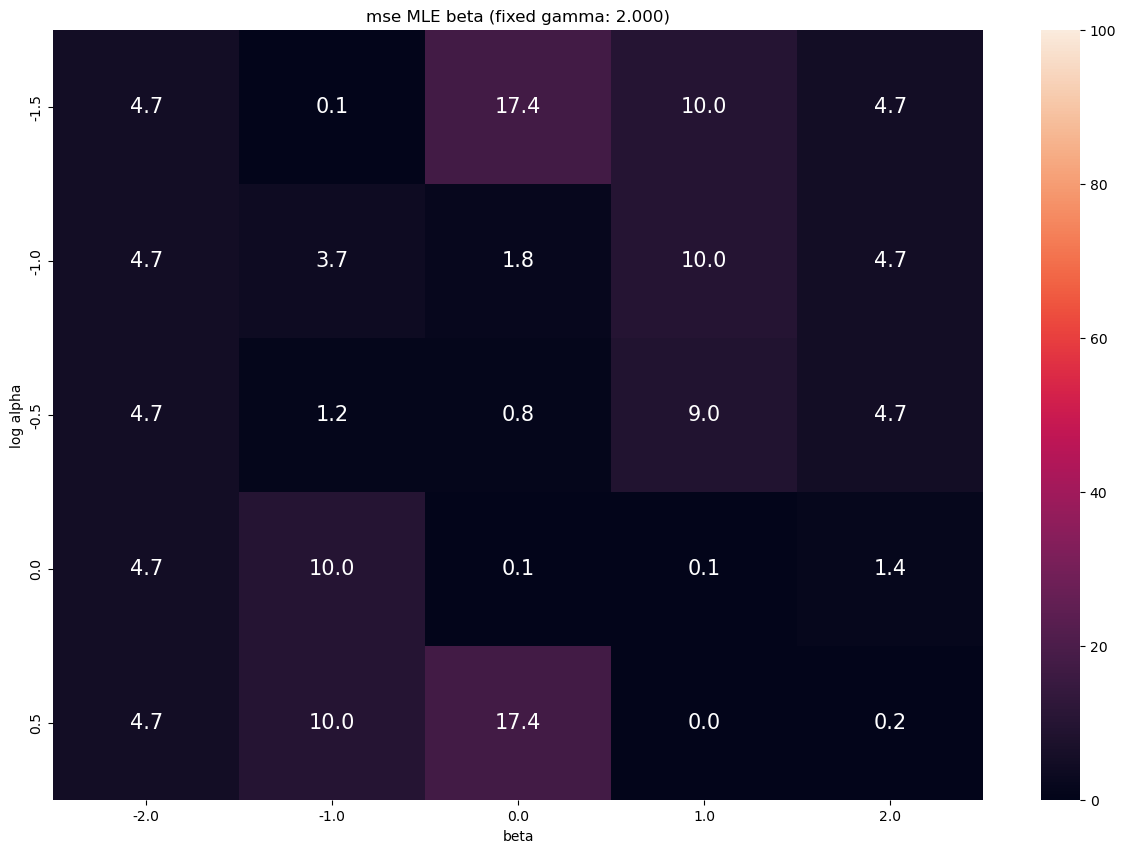

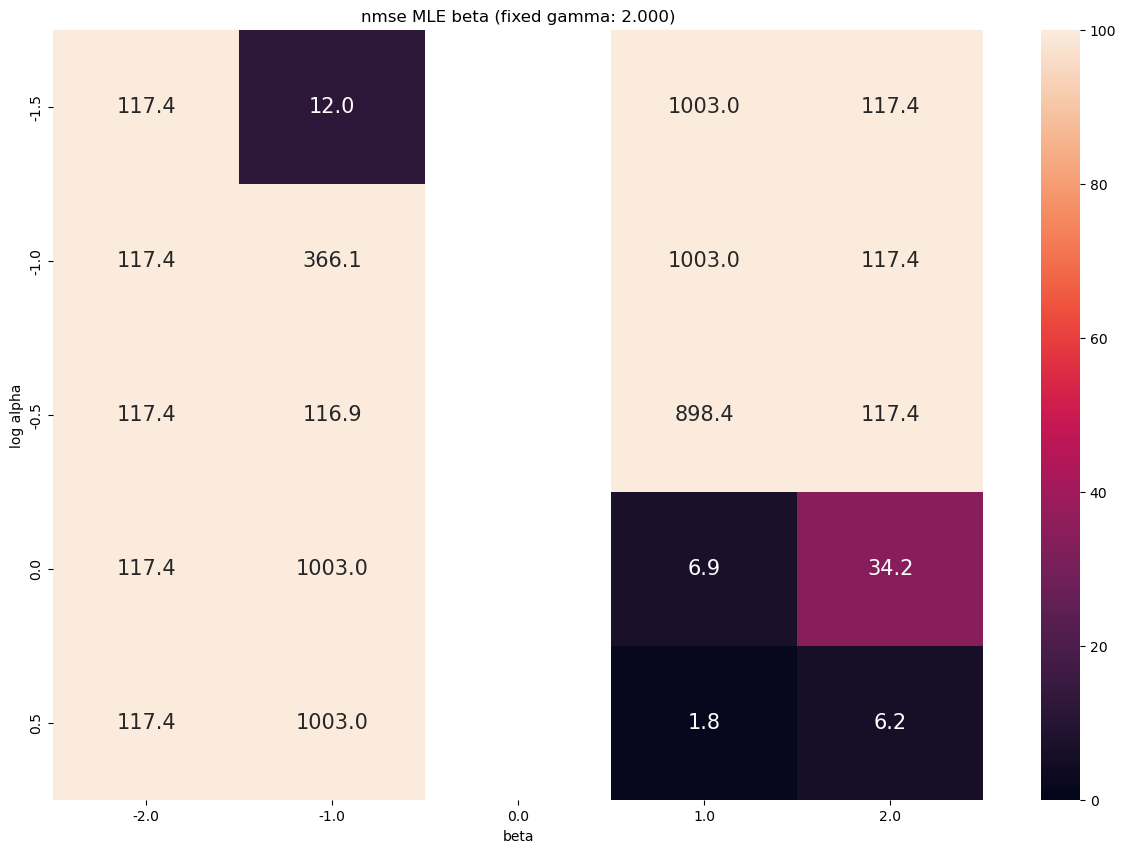

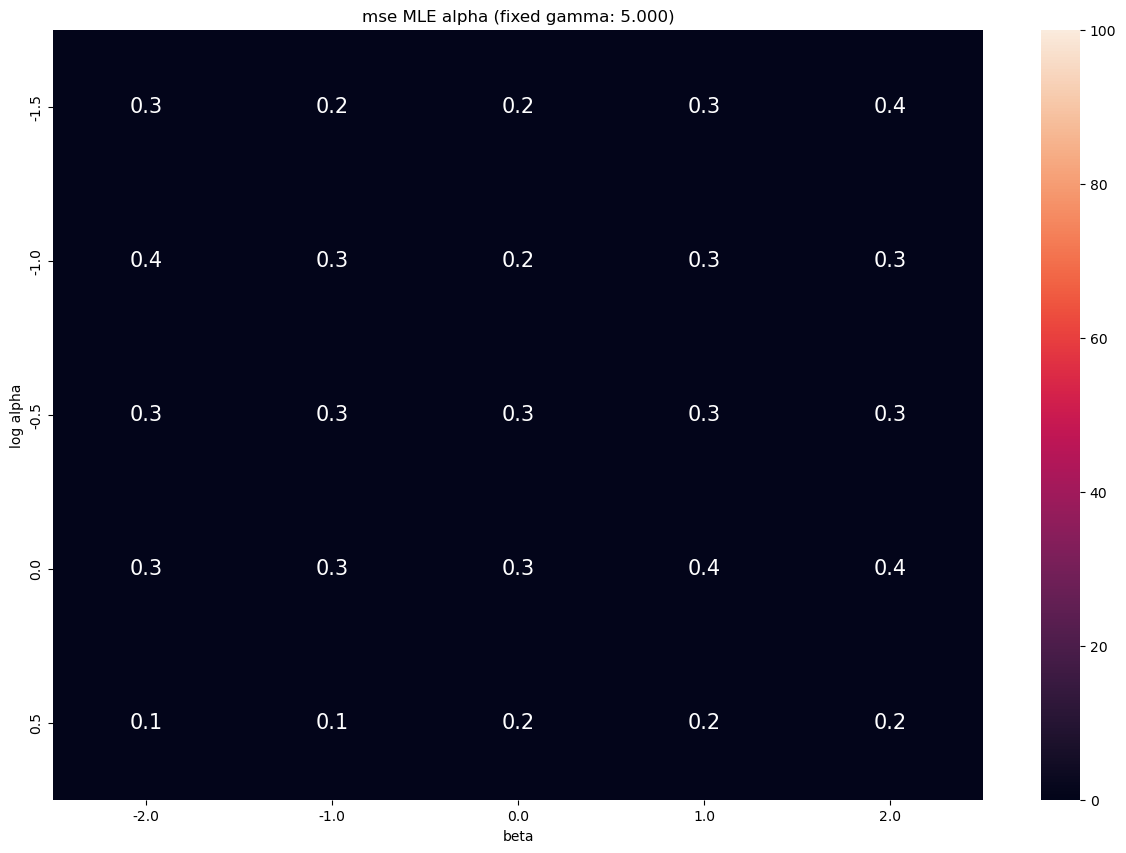

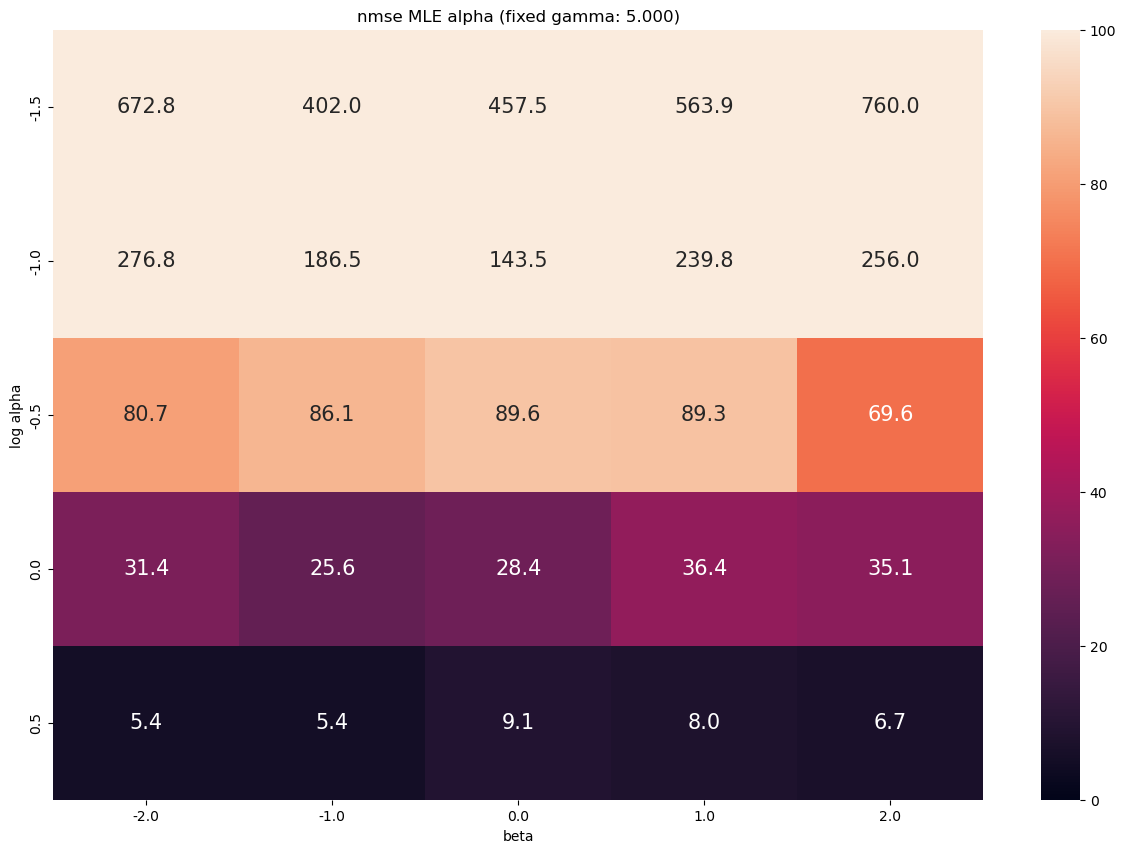

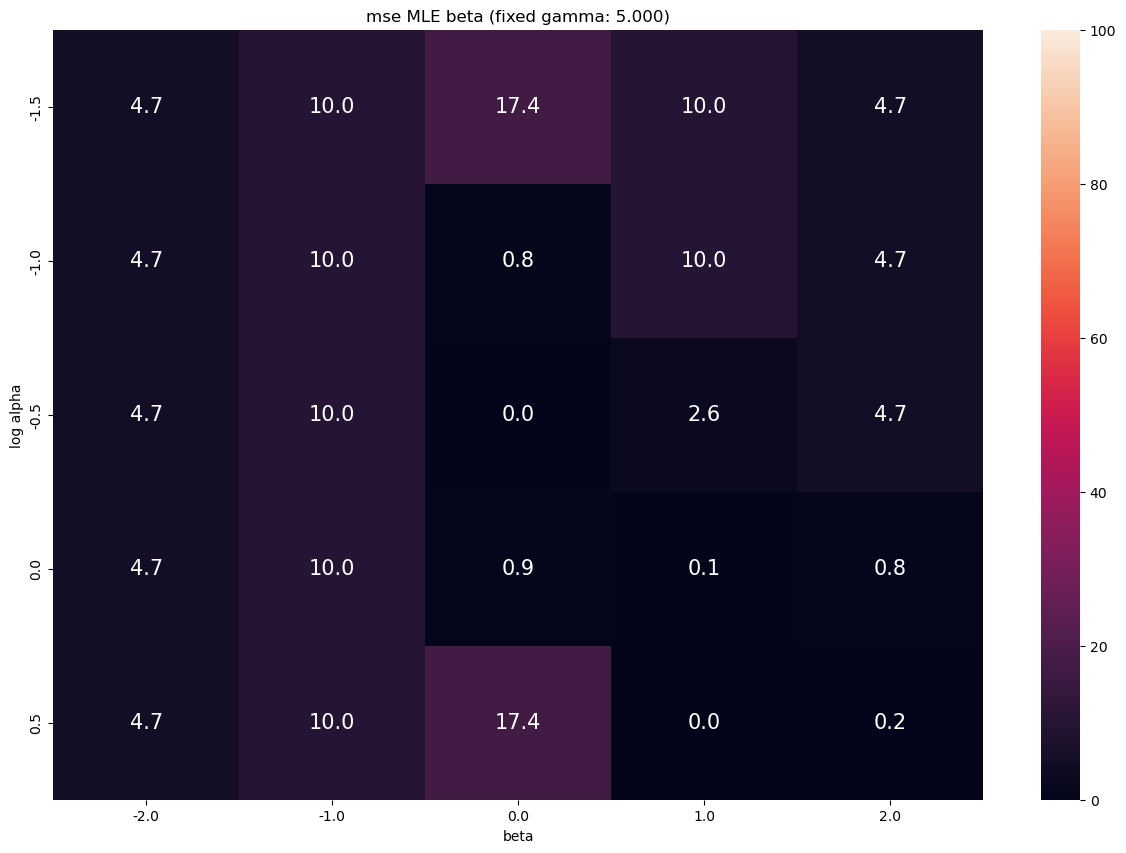

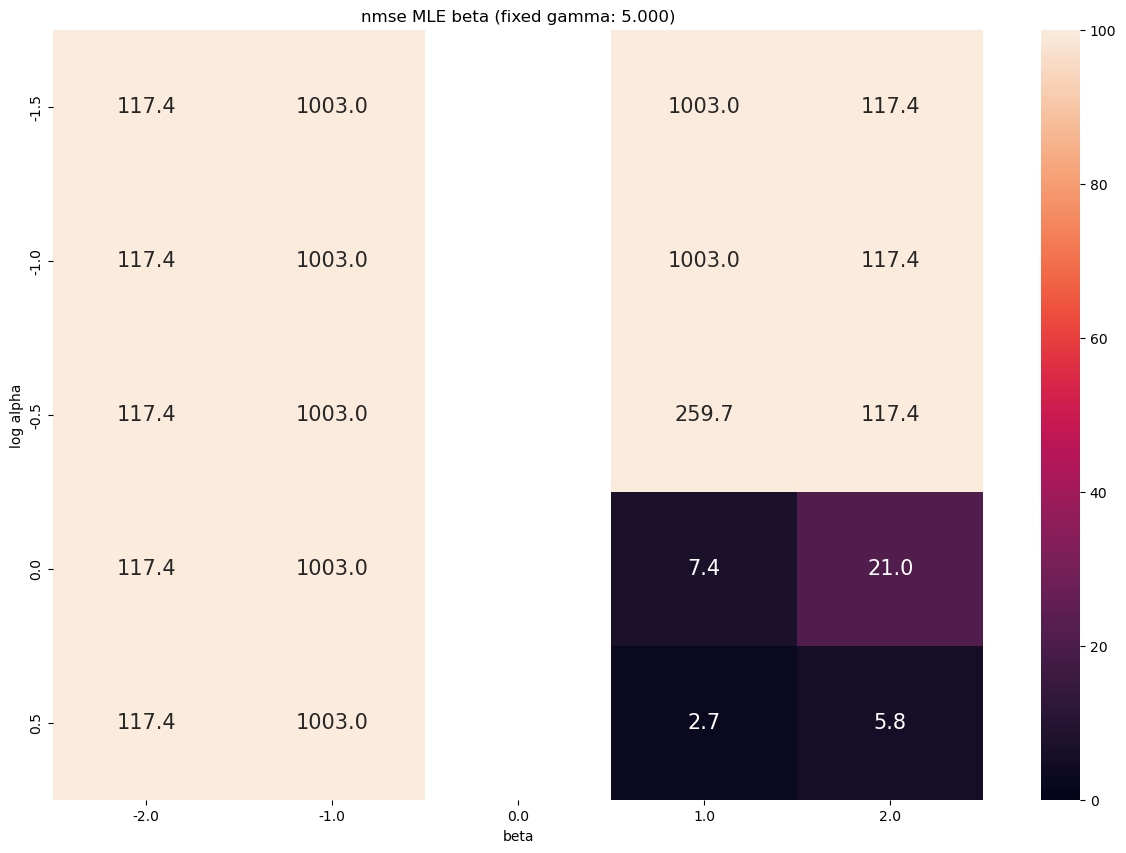

In [597]:


heatmap_save_vars(df,ver=ver,plot_diff=True)

heatmap_save_vars(df,ver=ver,model='bhm',type='agg')
heatmap_save_vars(df,ver=ver,model='mle',type='')
# mle_df

# heatmap_difference(df,var_fixed='',var_fixed_value=1.0,vars_plot=[],ver=''):
# heatmap_difference(df,ver=ver)
